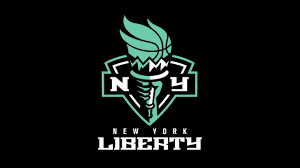
# Game Attendance
## New York Liberty

## Summary


WNBA viewership is on the rise; the 2022-2023 season was the highest viewed season in WNBA history, with an average of 379 thousand viewers. Game attendance is also on the up, after a steep decline in 2020 thanks to Covid and a postponed season that ended up in the Wubble, where no fans were able to attend games, with the condensed season being strictly televised. With this growing interest, the New York Liberty is curious how their game-by-game attendance for the upcoming season will be affected. They have tasked their data team with forecasting game attendance so that other cross-functional teams, such as marketing, ticketing, concessions, etc., can plan for the upcoming 2023-2024 season accordingly. This is going to be achieved using Time Series.

Viewership data was hard to come by, so to obtain the necessary game attendance data, I scrubbed game-by-game attendance tables for every team in the WNBA since the league started back in 1997 from https://acrossthetimeline.com/. Each team's data was saved into individual CSV's, from which I then pulled the information specific to the New York Liberty, which I then concatenated with the New York Liberty data set I had created, making a new dataset of every game, home or away, that they had ever played, which I turned into a CSV to be pulled into a notebook. 

Beyond scrubbing the data to create my own dataset, there were a few more things that needed to be done in order to prep the data for modeling. I dropped all the unecessary columns within the dataset, then enacted datetime to the dataframe and set this as our new index. Any null values were then turned int NANs and dropped, then lastly as each season spans just a few months out of the year, I interpolated the data so that we would be dealing with a consistent line. Once the series was ready, I tested for stationarity, which the data wasn't too bad! But I still decided to try each of the transformers to see which gave us the most stationary dataset. 
This included:
- Log Transform
- Square Root
- Subtracted Rolling Mean
- Differenced
I found that the differenced dataframe got us the closest to '0' (with a p-value of 2.098931e-23), so I ran with that dataframe.

Once I had landed on the dataframe that was ready for modeling, I checked for partial correlation and autocorrelation to helpm me narrow down the best models to move forward with. First, as my baseline, I ran a Naive model, shifting the data by one game, which gave me MSE(mean squared error) of 32.5, so not a bad start! Next, based on the partial correlation, I ran an AR (Auto Regressive) model, with 17 lags, whcih returned and MSE of 14.7, cutting our baseline by more than half! Finally, based on the autocorrelation I ran an MA (Moving Average) model, with 3 lags, which brought our MSE down just a tad to a 14.6. This seems like the best model to move forward with, but I decided to run a SARIMAX just to be sure that this model did indeed contain the best possible parameters. From the SARIMAX I found that TK.

After determing the best model, I ran some diagnostics on my differenced data. Their didn't seem to be any obvious seasonality and the correlelogram inferred that the time series residuals have low correlation with lagged versions of itself, while the density plot and Normal Q-Q plot showing us that the residuals are normally distributed.
Based on these observations it seems that we have a satisfactory fit to help forecast future values.

To validate the model, I ran a forecast, but did so with the parameters that the SARIMAX suggested, but unfortunately it came out with a higher MSE, so then I ran it gaain for my best model, which resulted in null values. Think I'm going to have to run a broader SARIMAX to find the best oevrall parameters before we can run a successful forecast.

In [1]:
from random import gauss as gs
import pandas as pd
import numpy as np
from numpy import log, sqrt
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.pylab import rcParams
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from pandas.plotting import autocorrelation_plot

import itertools

import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose

%matplotlib inline

## Business & Data Understanding

The 2022-2023 season was the highest viewed season, with an average of 379 thousand viewers, in WNBA history, so the New York Liberty is curious how the WNBA's rising popualarity will affect their game by game attendance. They have tasked their data team with forecasting the game attendance for the upcoming season so that other cross-functional teams, such as marketing, ticketing, concessions, etc., can plan for the upcoming 2023-2024 season accordingly. 

To obtain the necessary data, I scrubbed game-by-game attendance data for every team in the WNBA since the league started back in 1997 from https://acrossthetimeline.com/. Data specifically for the New York Liberty was combined into it's own data set and turned into a CSV. 

The data contained in this resulting dataset consists of:
- Date: the exact month/day/year the game was played
- Opponent: who the Liberty played against. Note that for away games this column will just say "New York Liberty", as this infirmation was pulled from tables that belong to other teams, so to decipher who the Liberty played you will need to observe the 'Arena' and 'Location' columns.
- Segement: this denotes the time of the season that the game was played. Whether it was a regular season, a specific round of the playoffs, semifinals, or finals.
- Arena: the arena in which the game was played.
- Location: the location of the arena that thegame was played in, by city and state.
- Attendance: the number of people, in thousands, that attended the game.

In [2]:
# Pulling in the CSV I created
NYL_Final_df = pd.read_csv('/Users/aheinke/Documents/Flatiron/WNBA-Viewership/Team_CSVs/Final_csv.csv')
NYL_Final_df

,Unnamed: 0.1,Unnamed: 0,Date,Opponent,Segment,Arena,Location,Attendance
0,0,0,"June 29, 1997",Phoenix Mercury,Regular season,Madison Square Garden,"New York, NY",17780
1,1,1,"July 2, 1997",Houston Comets,Regular season,Madison Square Garden,"New York, NY",8792
2,2,2,"July 10, 1997",Charlotte Sting,Regular season,Madison Square Garden,"New York, NY",9951
3,3,3,"July 15, 1997",Cleveland Rockers,Regular season,Madison Square Garden,"New York, NY",8554
4,4,4,"July 17, 1997",Utah Starzz,Regular season,Madison Square Garden,"New York, NY",9017
...,...,...,...,...,...,...,...,...
892,356,10,"July 5, 2018",New York Liberty,Regular season,Capital One Arena,"Washington, DC",4674
893,379,13,"August 25, 2019",New York Liberty,Regular season,Entertainment and Sports Arena,"Washington, DC",4200
894,390,2,"May 21, 2021",New York Liberty,Regular season,Entertainment and Sports Arena,"Washington, DC",1050
895,409,5,"June 3, 2022",New York Liberty,Regular season,Entertainment and Sports Arena,"Washington, DC",3857


In [3]:
# Checking the CSV for null values and data types
NYL_Final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 897 entries, 0 to 896
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  897 non-null    int64 
 1   Unnamed: 0    897 non-null    int64 
 2   Date          897 non-null    object
 3   Opponent      897 non-null    object
 4   Segment       897 non-null    object
 5   Arena         897 non-null    object
 6   Location      897 non-null    object
 7   Attendance    897 non-null    int64 
dtypes: int64(3), object(5)
memory usage: 56.2+ KB


In [4]:
# Turning our inital dataframe into datetime and organizing it by year so that we can plot it to see 
# what we're working with
NYL_Final_df['Date'] = pd.to_datetime(NYL_Final_df['Date'])
NYL_Final_df['year'] = NYL_Final_df['Date'].dt.year

<Axes: xlabel='year', ylabel='Attendance'>

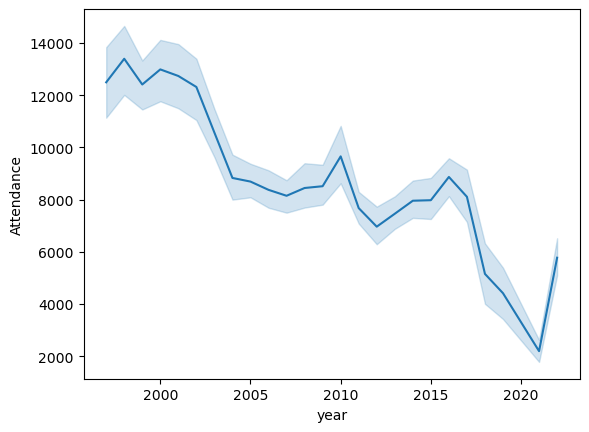

In [5]:
sns.lineplot(x = NYL_Final_df['year'], y = NYL_Final_df['Attendance'])

In [6]:
# Sorting the dates of the games in ascending order as they got all mixed up when creating the CSV
NYL_Final_df.sort_values(by = 'Date', inplace = True)
NYL_Final_df

,Unnamed: 0.1,Unnamed: 0,Date,Opponent,Segment,Arena,Location,Attendance,year
687,0,0,1997-06-21,New York Liberty,Regular season,Great Western Forum,"Los Angeles, CA",14284,1997
784,0,0,1997-06-23,New York Liberty,Regular season,ARCO Arena,"Sacramento, CA",15259,1997
621,1,1,1997-06-26,New York Liberty,Regular season,Compaq Center,"Houston, TX",8931,1997
0,0,0,1997-06-29,Phoenix Mercury,Regular season,Madison Square Garden,"New York, NY",17780,1997
1,1,1,1997-07-02,Houston Comets,Regular season,Madison Square Garden,"New York, NY",8792,1997
...,...,...,...,...,...,...,...,...,...
478,255,17,2022-08-12,New York Liberty,Regular season,Gateway Center Arena,"Atlanta, GA",3138,2022
449,449,17,2022-08-14,Atlanta Dream,Regular season,Barclays Center,"Brooklyn, NY",7561,2022
528,285,18,2022-08-17,New York Liberty,First Round,Wintrust Arena,"Chicago, IL",7524,2022
529,286,19,2022-08-20,New York Liberty,First Round,Wintrust Arena,"Chicago, IL",7732,2022


After scrubbing, there were a few more things that needed to be done in order to prep the data for modeling. So we're going to prepare our final dataframe which we will then turn into a datetime, and finally run some transformations depending on the stationarity. 

I dropped all the unecessary columns within the dataset, then enacted datetime to the dataframe and set this as our new index. Any null values were then turned int NANs and dropped, then lastly as each season spans just a few months out of the year, I interpolated the data so that we would be dealing with a consistent line. Once the series was ready, I tested for stationarity, which the data wasn't too bad! But I still decided to try each of the transformers to see which gave us the most stationary dataset. 
This included:
- Log Transform
- Square Root
- Subtracted Rolling Mean
- Differenced
I found that the differenced dataframe got us the closest to '0' (with a p-value of 2.098931e-23), so I ran with that dataframe.

In [7]:
# Creating our final dataframe by dropping all of the columns we don't need
NYL_Final_ts = NYL_Final_df.drop(['Unnamed: 0.1', 'Unnamed: 0', 'Opponent', 'Segment', 'Arena', 'Location',\
                                 'year'], axis = 1)
NYL_Final_ts.head()

,Date,Attendance
687,1997-06-21,14284
784,1997-06-23,15259
621,1997-06-26,8931
0,1997-06-29,17780
1,1997-07-02,8792


In [8]:
# Turning the dataframe into a time series using datetime
NYL_Final_ts['Date'] = pd.to_datetime(NYL_Final_ts['Date'])

In [9]:
# Setting our date column as the index
NYL_Final_ts.set_index('Date', inplace = True)
NYL_Final_ts.head()

,Attendance
Date,
1997-06-21,14284
1997-06-23,15259
1997-06-26,8931
1997-06-29,17780
1997-07-02,8792


In [10]:
# Replacing '0' values with Nan's and then dropping them
if (NYL_Final_ts['Attendance'] <= 0).any():
    NYL_Final_ts.loc[NYL_Final_ts['Attendance'] <= 0, 'Attendance'] = np.nan
    NYL_Final_ts.dropna(inplace = True)

In [11]:
# As a season lasts just a few months, we're interpolating the data so that it's a continuous line
NYL_Final_ts_fill = NYL_Final_ts.interpolate()
NYL_Final_ts_fill.head(10)

,Attendance
Date,
1997-06-21,14284.0
1997-06-23,15259.0
1997-06-26,8931.0
1997-06-29,17780.0
1997-07-02,8792.0
1997-07-04,10239.0
1997-07-05,7689.0
1997-07-07,13731.0
1997-07-09,8913.0


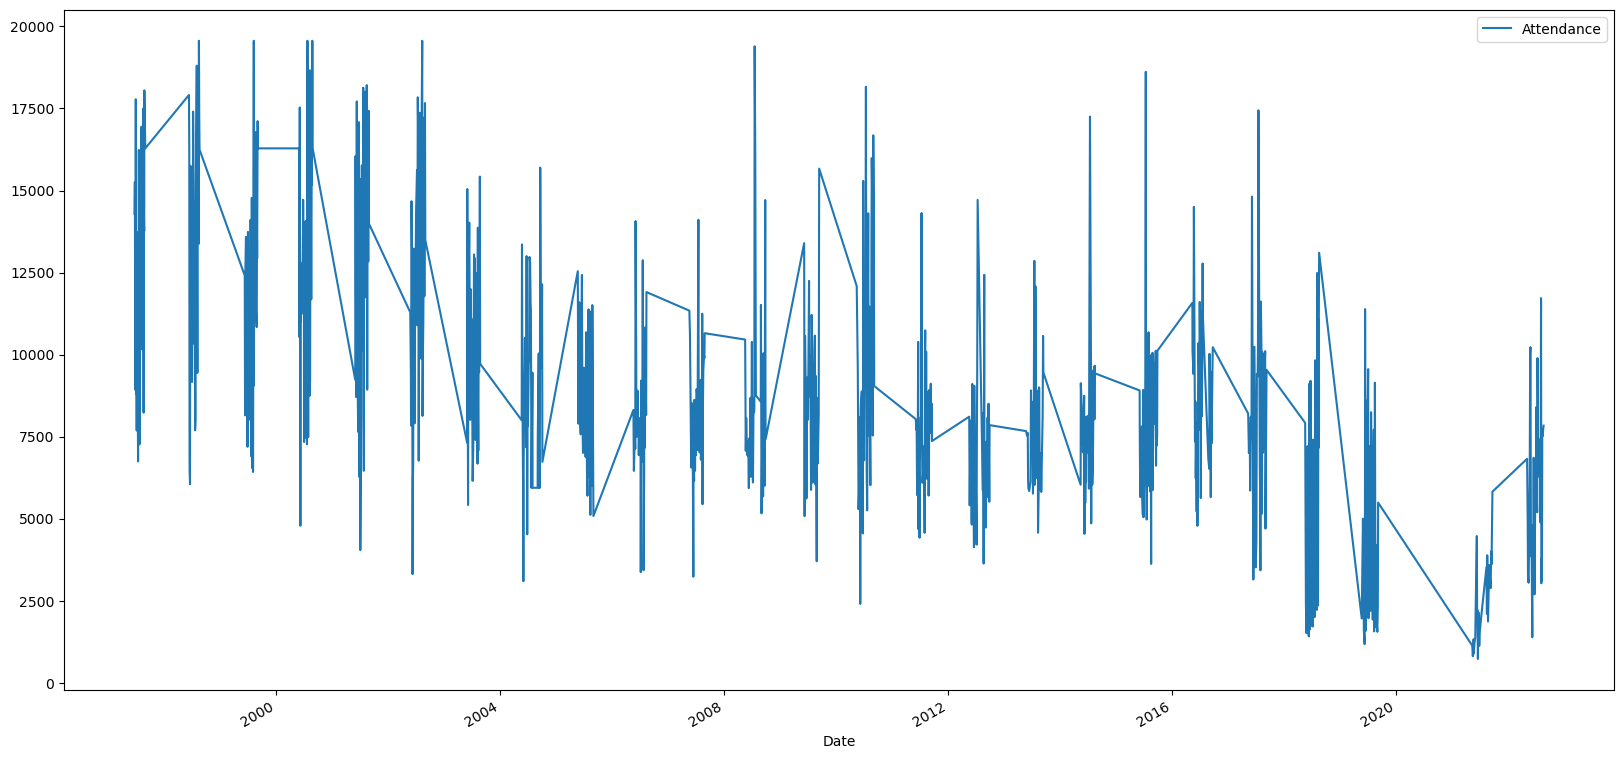

In [12]:
# Plotting our final datetime
NYL_Final_ts_fill.plot(figsize = (20,10));

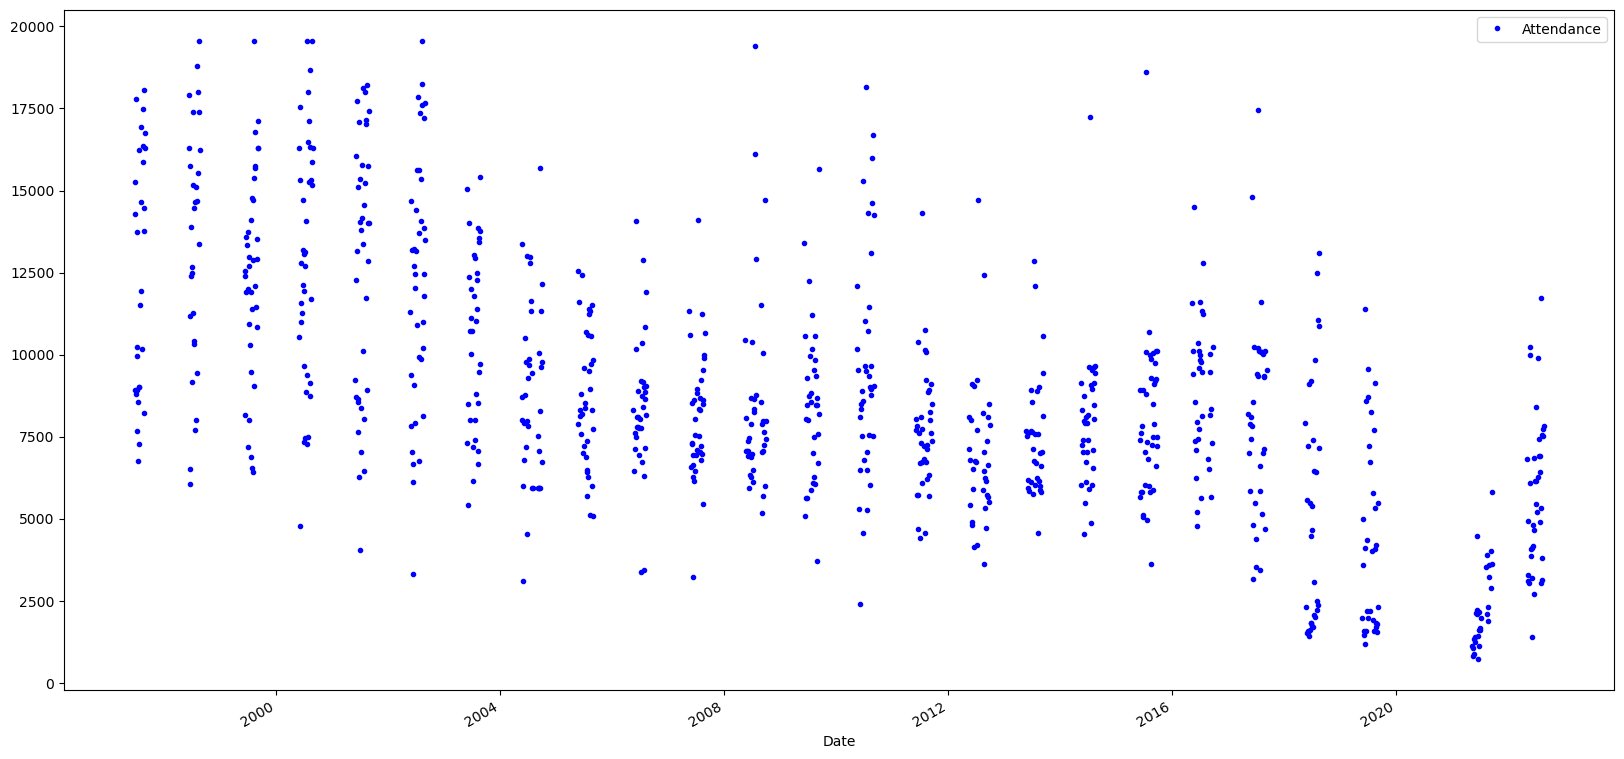

In [13]:
NYL_Final_ts_fill.plot(figsize = (20,10), style = '.b');

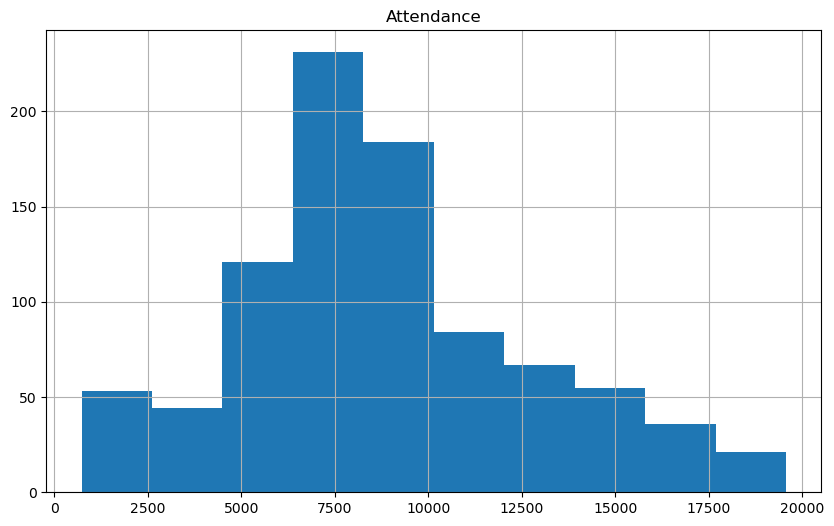

In [14]:
NYL_Final_ts_fill.hist(figsize = (10,6));

In [15]:
# Running a Dickey Fuller to give us a baseline for our transformations
dftest = adfuller(NYL_Final_ts_fill)

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -2.181939
p-value                          0.212866
#Lags Used                      20.000000
Number of Observations Used    875.000000
Critical Value (1%)             -3.437846
Critical Value (5%)             -2.864849
Critical Value (10%)            -2.568532
dtype: float64


The stationarity off the bat isn't terrible, our p-value is at a 0.21, but the data is not stationary, so we have to do some transformations.

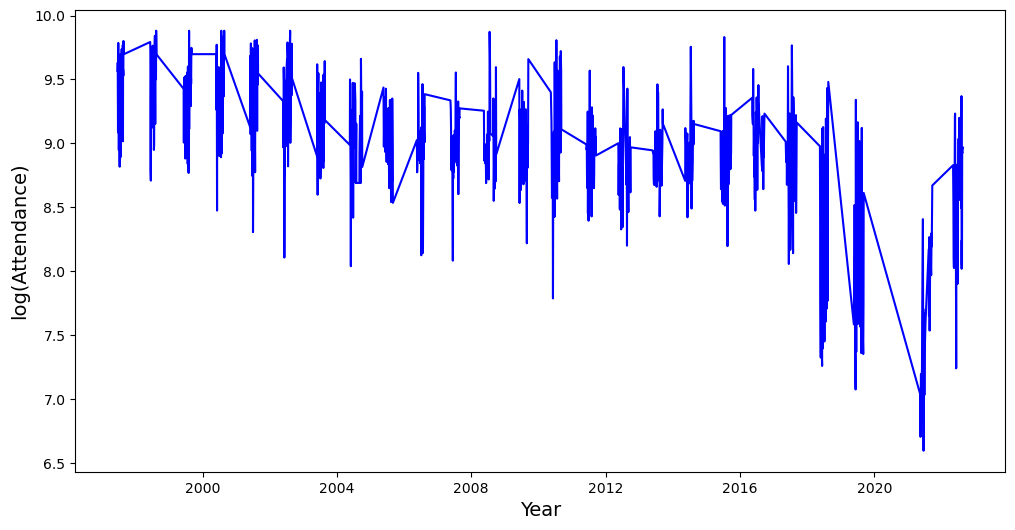

In [16]:
# Log Transforming the data
log_transform = log(NYL_Final_ts_fill)
fig = plt.figure(figsize = (12,6))
plt.plot(log_transform, color = 'blue')
plt.xlabel('Year', fontsize = 14)
plt.ylabel('log(Attendance)', fontsize = 14)
plt.show()

In [17]:
# Checking the result against our baseline
dftest = adfuller(log_transform)

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -2.330193
p-value                          0.162415
#Lags Used                      15.000000
Number of Observations Used    880.000000
Critical Value (1%)             -3.437803
Critical Value (5%)             -2.864830
Critical Value (10%)            -2.568522
dtype: float64


This is looking better! Our p-value has dropped to 0.16, but we can push this further.

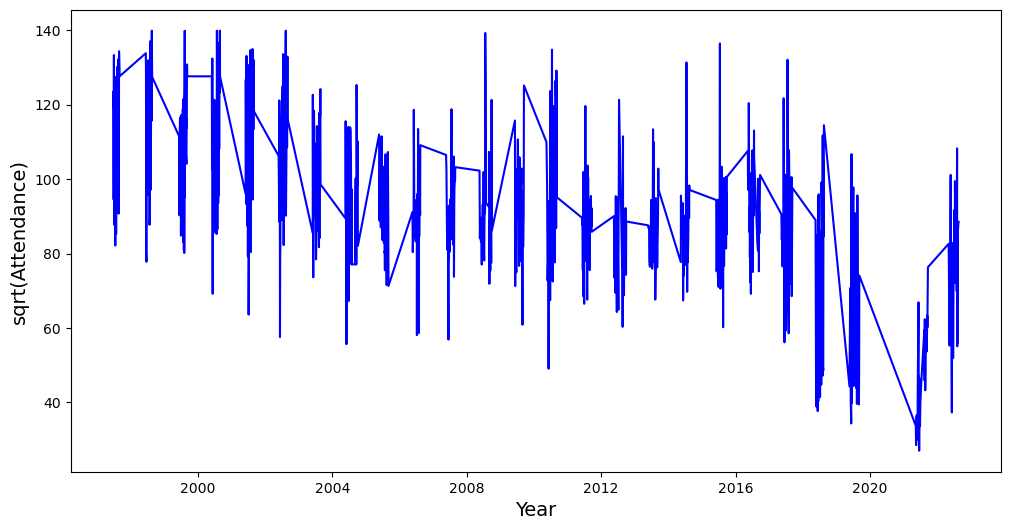

In [18]:
# Doing a square root transformation
sqrt_transform = NYL_Final_ts = sqrt(NYL_Final_ts_fill)
fig = plt.figure(figsize = (12,6))
plt.plot(sqrt_transform, color = 'blue')
plt.xlabel('Year', fontsize = 14)
plt.ylabel('sqrt(Attendance)', fontsize = 14)
plt.show()

In [19]:
# Again checking this against our baseline
dftest = adfuller(sqrt_transform)

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                  -2.312931
p-value                          0.167831
#Lags Used                      15.000000
Number of Observations Used    880.000000
Critical Value (1%)             -3.437803
Critical Value (5%)             -2.864830
Critical Value (10%)            -2.568522
dtype: float64


This is about the same, but a little bit worse, with a p-value of 0.17.

In [20]:
# Setti g our selves up for a subtracted rolling mean
roll_mean = NYL_Final_ts_fill.rolling(window = 4, center = False).mean()
roll_std = NYL_Final_ts_fill.rolling(window = 4, center = False).std()

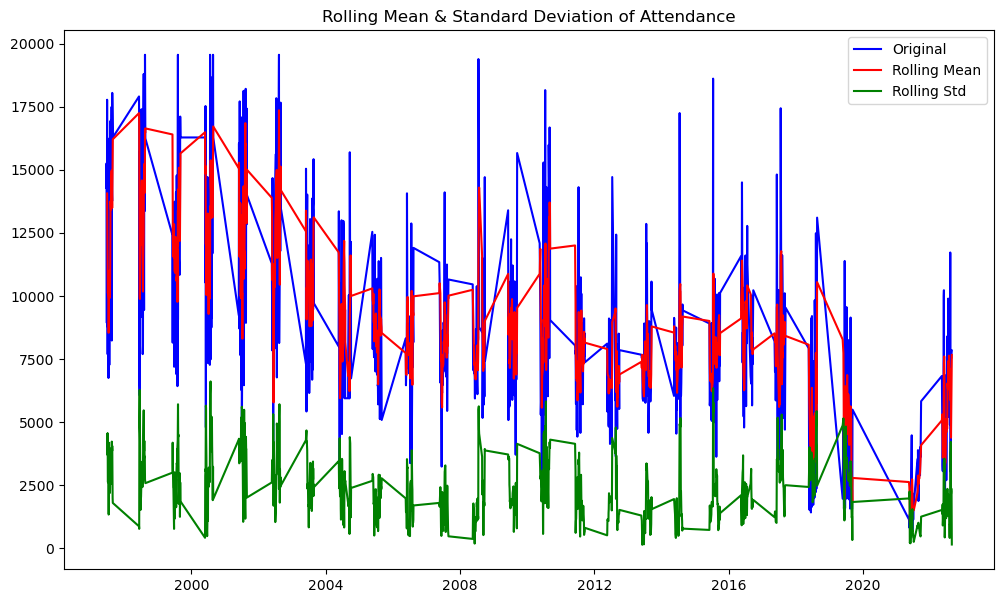

In [21]:
fig = plt.figure(figsize = (12,7))
plt.plot(NYL_Final_ts_fill, color = 'blue', label = 'Original')
plt.plot(roll_mean, color = 'red', label = 'Rolling Mean')
plt.plot(roll_std, color = 'green', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Standard Deviation of Attendance')
plt.show(block = False)

In [22]:
NYL_Final_ts_fill_minus_roll_mean = NYL_Final_ts_fill - roll_mean
NYL_Final_ts_fill_minus_roll_mean.head(10)

,Attendance
Date,
1997-06-21,NaN
1997-06-23,NaN
1997-06-26,NaN
1997-06-29,3716.50
1997-07-02,-3898.50
1997-07-04,-1196.50
1997-07-05,-3436.00
1997-07-07,3618.25
1997-07-09,-1230.00


In [23]:
NYL_Final_ts_fill_minus_roll_mean.dropna(inplace = True)

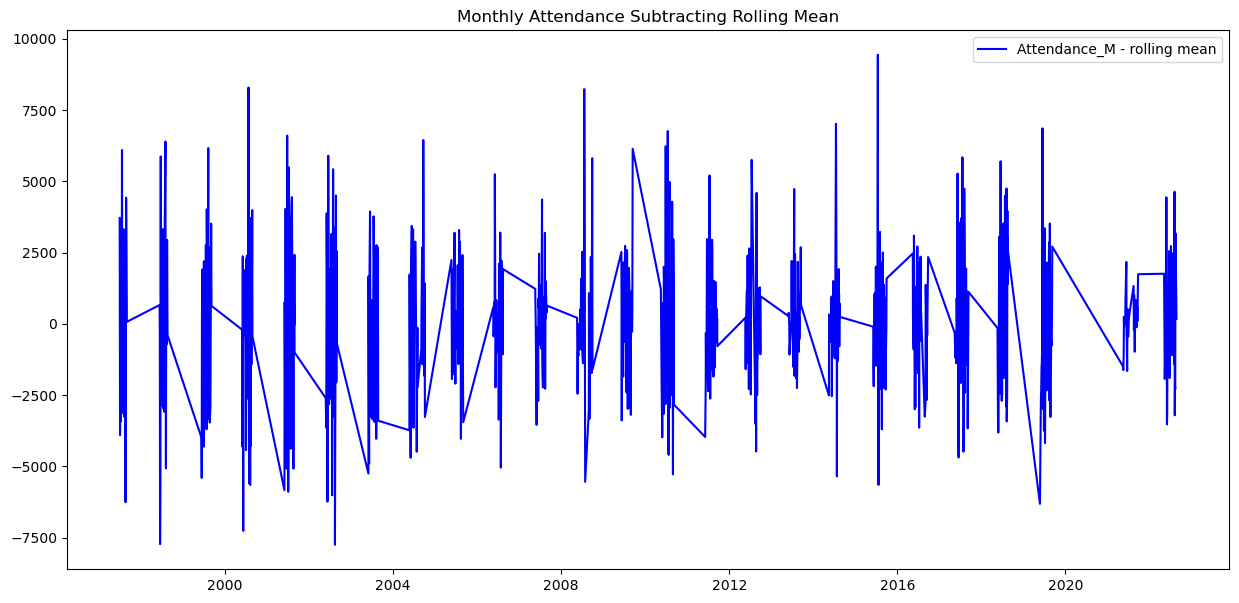

In [24]:
fig = plt.figure(figsize = (15,7))
plt.plot(NYL_Final_ts_fill_minus_roll_mean, color = 'blue',label = 'Attendance_M - rolling mean')
plt.legend(loc = 'best')
plt.title('Monthly Attendance Subtracting Rolling Mean')
plt.show(block = False)

In [25]:
# Comparing against our baseline
dftest = adfuller(NYL_Final_ts_fill_minus_roll_mean)

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -1.017493e+01
p-value                        6.932543e-18
#Lags Used                     1.900000e+01
Number of Observations Used    8.730000e+02
Critical Value (1%)           -3.437863e+00
Critical Value (5%)           -2.864856e+00
Critical Value (10%)          -2.568536e+00
dtype: float64


Okay! Now we are finally getting somewhere. With a subtracted rolling mean we were able to get our p-value to almst a '0', coming in at 6.932543e-18.

In [26]:
# Lastly, we're differencing our data
NYL_Final_ts_fill_diff = NYL_Final_ts_fill.diff(periods = 1)
NYL_Final_ts_fill_diff.head(10)

,Attendance
Date,
1997-06-21,NaN
1997-06-23,975.0
1997-06-26,-6328.0
1997-06-29,8849.0
1997-07-02,-8988.0
1997-07-04,1447.0
1997-07-05,-2550.0
1997-07-07,6042.0
1997-07-09,-4818.0


In [27]:
NYL_Final_ts_fill_diff.dropna(inplace = True)

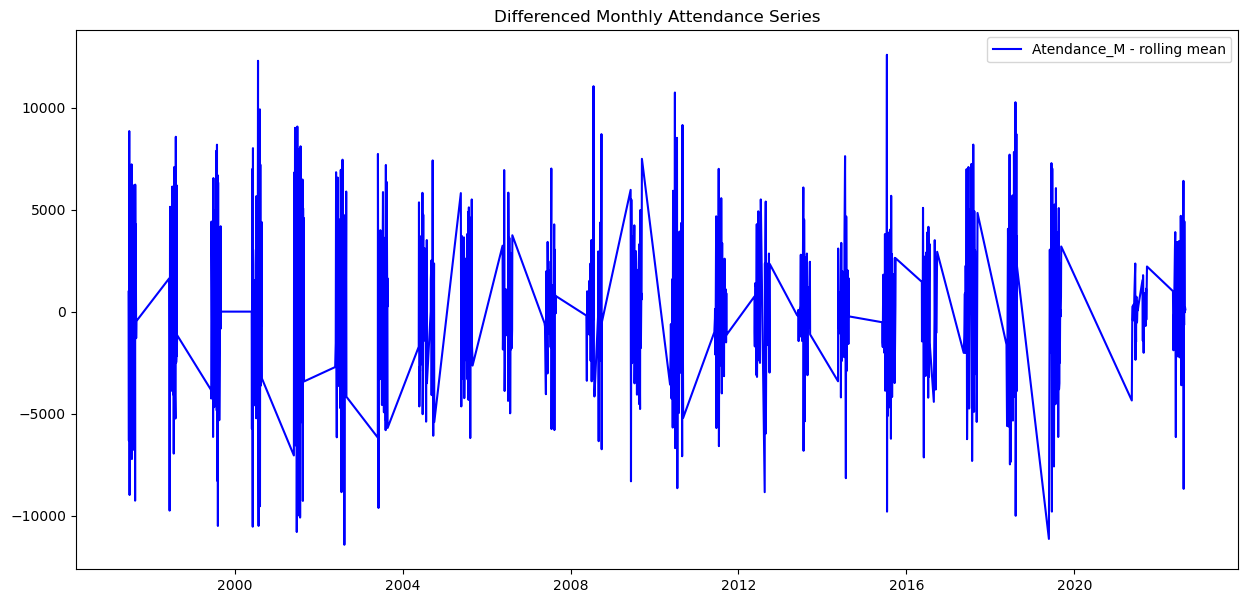

In [28]:
fig = plt.figure(figsize = (15,7))
plt.plot(NYL_Final_ts_fill_diff, color = 'blue',label = 'Atendance_M - rolling mean')
plt.legend(loc = 'best')
plt.title('Differenced Monthly Attendance Series')
plt.show(block = False)

In [29]:
dftest = adfuller(NYL_Final_ts_fill_diff)

dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                -9.198868e+00
p-value                        2.027488e-15
#Lags Used                     2.100000e+01
Number of Observations Used    8.730000e+02
Critical Value (1%)           -3.437863e+00
Critical Value (5%)           -2.864856e+00
Critical Value (10%)          -2.568536e+00
dtype: float64


Seems that this transformation gave us the smallest p-value, with 2.027488e-15. So we are going to move forward with this datetime!

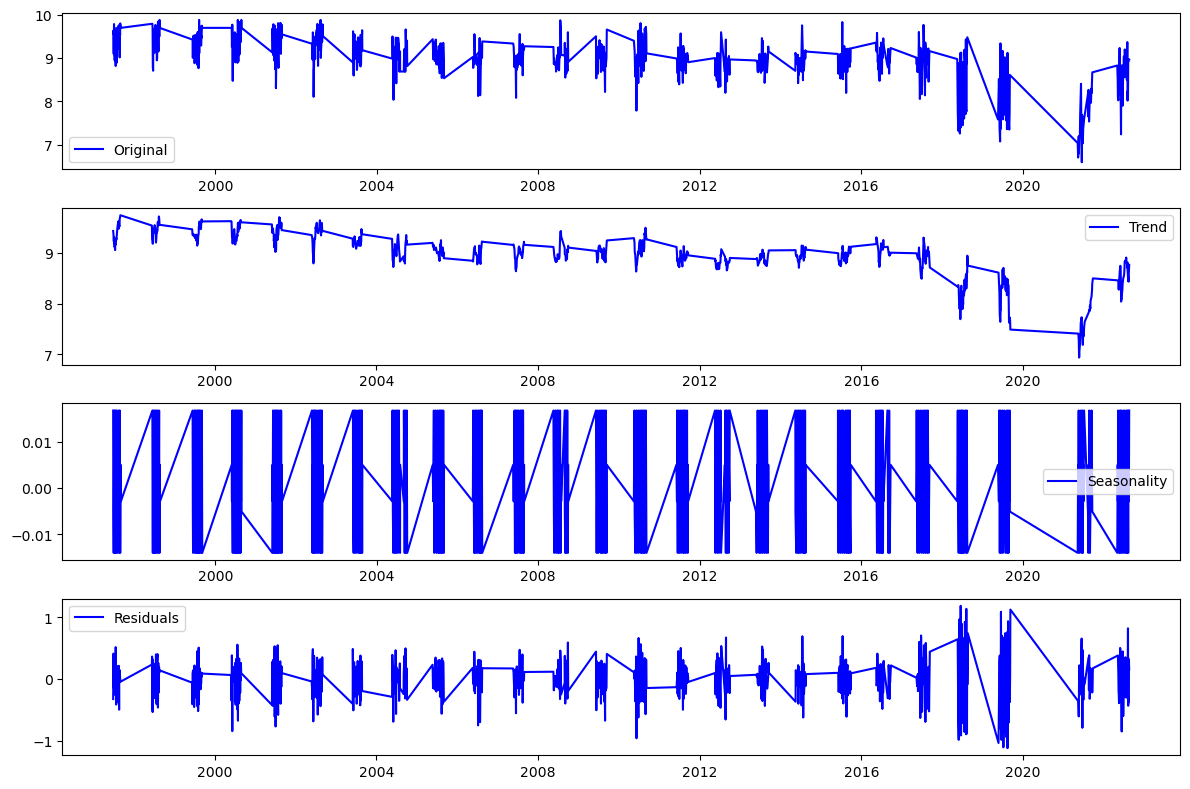

In [30]:
# Running a decomposition to check our trends, seasonality, and residuals.
decomposition = seasonal_decompose(np.log(NYL_Final_ts_fill), period = 5)
 
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (12,8))
plt.subplot(411)
plt.plot(np.log(NYL_Final_ts_fill), label = 'Original', color = 'blue')
plt.legend(loc = 'best')
plt.subplot(412)
plt.plot(trend, label = 'Trend', color = 'blue')
plt.legend(loc = 'best')
plt.subplot(413)
plt.plot(seasonal,label = 'Seasonality', color = 'blue')
plt.legend(loc = 'best')
plt.subplot(414)
plt.plot(residual, label = 'Residuals', color = 'blue')
plt.legend(loc = 'best')
plt.tight_layout()

Based on this decomposition, it looks like we have a bit of a trend and seasonality, but our residuals are pretty minimal. 

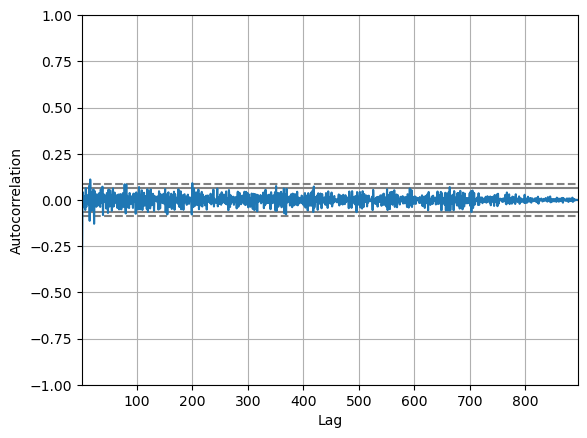

In [31]:
# Plotting autocrrelation
autocorrelation_plot(NYL_Final_ts_fill_diff)
pyplot.show()

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


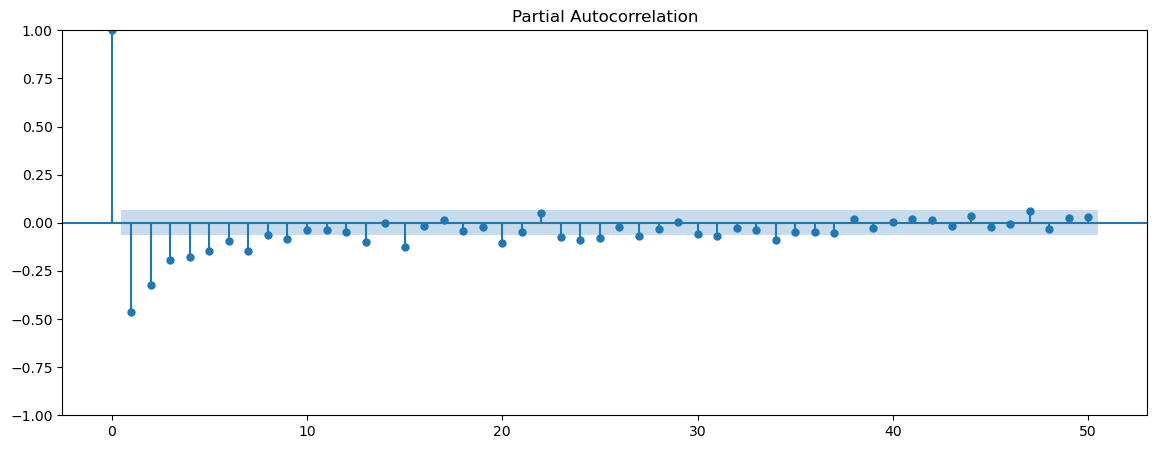

In [32]:
#PACF PLOT. Looking at the partial autocorrelation, which will help guide my AR
# The first lag closest to '0' seems to be 17, so we're running with it
rcParams['figure.figsize'] = 14, 5

plot_pacf(NYL_Final_ts_fill_diff, lags = 50);

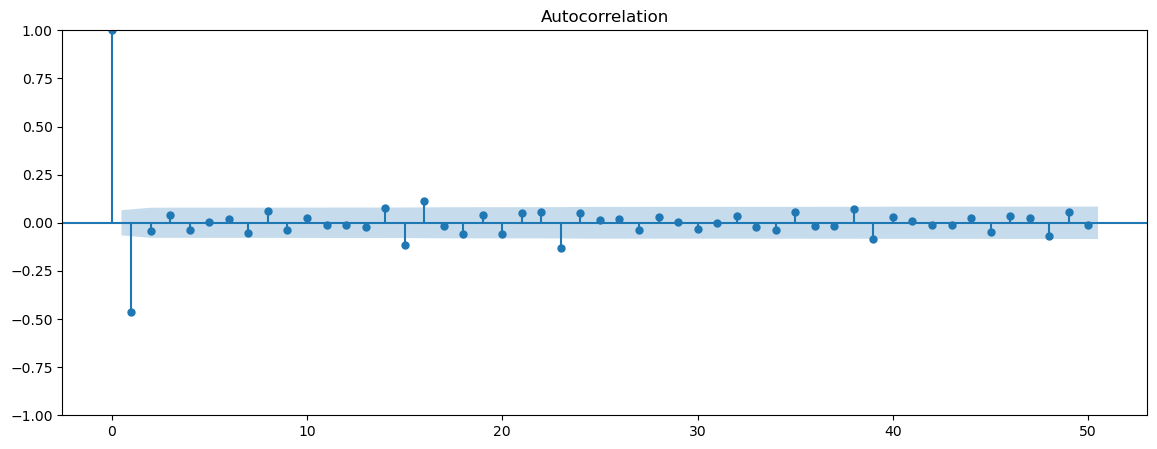

In [33]:
#ACF PLOT. Looking at the autocorrelation, which will help guide my MA
# The first lag closest to '0' seems to be 3, so we're running with it
rcParams['figure.figsize'] = 14, 5

plot_acf(NYL_Final_ts_fill_diff, lags = 50);

## Modeling

Once I had landed on the dataframe that was ready for modeling, I checked for partial correlation and autocorrelation to help me narrow down the best models to move forward with. First, as my baseline, I ran a Naive model, shifting the data by one game, which gave me MSE(mean squared error) of 32.5, so not a bad start! Next, based on the partial correlation, I ran an AR (Auto Regressive) model, with 17 lags, whcih returned and MSE of 14.7, cutting our baseline by more than half! Finally, based on the autocorrelation I ran an MA (Moving Average) model, with 3 lags, which brought our MSE down just a tad to a 14.6. This seems like the best model to move forward with, but I decided to run a SARIMAX just to be sure that this model did indeed contain the best possible parameters. From the SARIMAX, it is suggesting that I use: order = (1, 0, 1), seasonal_order = (0, 1, 1, 12). We will run this and see what happens!

In [34]:
# Setting the cutoff for our model
cutoff = round(NYL_Final_ts_fill_diff.shape[0] * 0.8)
cutoff

716

In [35]:
# Assigning each part of the cutoff to either the train or test
train = NYL_Final_ts_fill_diff[:cutoff]

test = NYL_Final_ts_fill_diff[cutoff:]

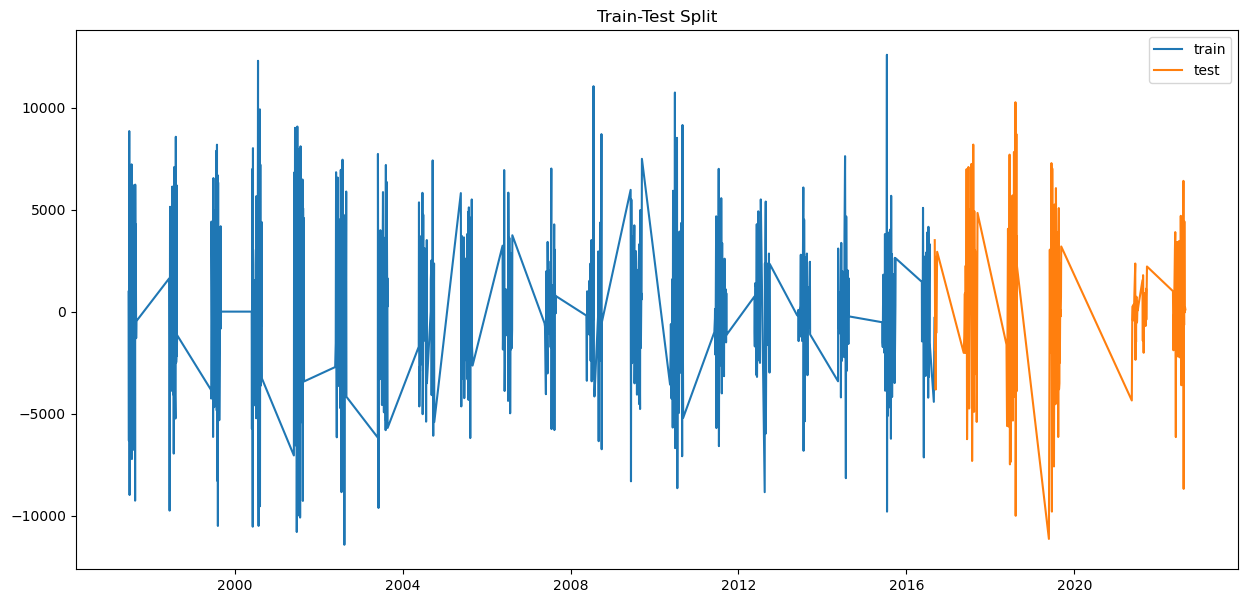

In [36]:
fig, ax = plt.subplots(figsize = (15, 7))
ax.plot(train, label = 'train')
ax.plot(test, label = 'test')
ax.set_title('Train-Test Split');
plt.legend();

In [37]:
train

,Attendance
Date,
1997-06-23,975.0
1997-06-26,-6328.0
1997-06-29,8849.0
1997-07-02,-8988.0
1997-07-04,1447.0
...,...
2016-07-17,1341.0
2016-07-20,3314.0
2016-07-21,-1525.0


In [38]:
# Running our baseline model, a naive, which we are shifting forward by one game
naive = train.shift(1)
naive

,Attendance
Date,
1997-06-23,NaN
1997-06-26,975.0
1997-06-29,-6328.0
1997-07-02,8849.0
1997-07-04,-8988.0
...,...
2016-07-17,-3194.0
2016-07-20,1341.0
2016-07-21,3314.0


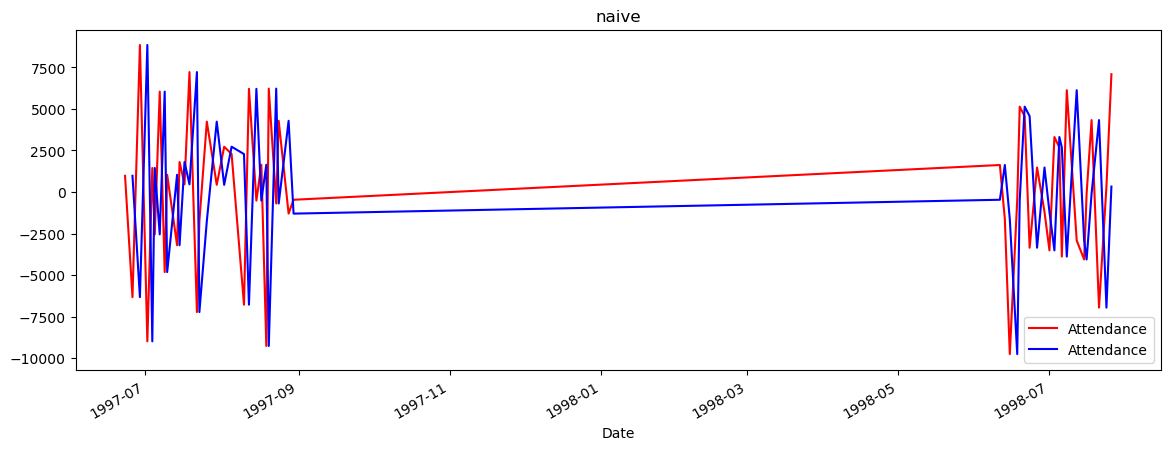

In [39]:
fig, ax = plt.subplots()

train[0:50].plot(ax = ax, c = 'r', label = 'original')
naive[0:50].plot(ax = ax, c = 'b', label = 'shifted')
ax.set_title('naive')
ax.legend();

In [40]:
naive_rmse = np.sqrt(mean_squared_error(train[1:], naive.dropna()))

6526.933661022196

In [41]:
# For the next model, running an AR (Auto Regressive) model
# With that lag of 17 that we identified in our partial correltion graph
att_ar_17 = ARIMA(train, order = (17, 0, 0)).fit()
att_ar_17.predict()

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Date
1997-06-23     -10.837763
1997-06-26    -466.728089
1997-06-29    3508.680234
1997-07-02   -3401.287201
1997-07-04    3672.370913
                 ...     
2016-07-17     599.477609
2016-07-20   -1091.305032
2016-07-21   -3265.391728
2016-08-26   -1358.865040
2016-09-01    1995.223836
Name: predicted_mean, Length: 716, dtype: float64

In [42]:
att_ar_17.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Attendance   No. Observations:                  716
Model:                ARIMA(17, 0, 0)   Log Likelihood               -6738.836
Date:                Fri, 31 Mar 2023   AIC                          13515.673
Time:                        11:53:43   BIC                          13602.572
Sample:                             0   HQIC                         13549.229
                                - 716                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -10.8378     18.026     -0.601      0.548     -46.168      24.493
ar.L1         -0.7859      0.034    -23.147      0.000      -0.852      -0.719
ar.L2         -0.6795      0.047    -14.597      0.000      -0.771      -0.588
ar.L3         -0.5703      0.052    -10.891      0.000      -0.673      -0.468
ar.L4         -0.5171      0.056     -9.237      0.000      -0.627      -0.407
ar.L5         -0.4413      0.058     -7.581      0.000      -0.555      -0.327
ar.L6         -0.3959      0.058     -6.865      0.000      -0.509      -0.283
ar.L7         -0.3608      0.058     -6.221      0.000      -0.474      -0.247
ar.L8         -0.2945      0.064     -4.607      0.000      -0.420      -0.169
ar.L9         -0.2814      0.063     -4.472      0.000      -0.405      -0.158
ar.L10        -0.1998      0.062     -3.199      0.001      -0.322      -0.077
ar.L11        -0.2338      0.057     -4.091      0.000      -0.346      -0.122
ar.L12        -0.2195      0.060     -3.682      0.000      -0.336      -0.103
ar.L13        -0.2078      0.059     -3.537      0.000      -0.323      -0.093
ar.L14        -0.1141      0.053     -2.138      0.033      -0.219      -0.009
ar.L15        -0.1332      0.051     -2.613      0.009      -0.233      -0.033
ar.L16        -0.0237      0.044     -0.542      0.588      -0.109       0.062
ar.L17        -0.0124      0.035     -0.351      0.725      -0.082       0.057
sigma2      8.668e+06   3.88e+05     22.339      0.000    7.91e+06    9.43e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                32.78
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.24
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.93
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.93e+14. Standard errors may be unstable.
"""

In [43]:
y_hat_ar17 = att_ar_17.predict()
ar17_rmse = np.sqrt(mean_squared_error(train, y_hat_ar17))

In [44]:
train.index

DatetimeIndex(['1997-06-23', '1997-06-26', '1997-06-29', '1997-07-02',
               '1997-07-04', '1997-07-05', '1997-07-07', '1997-07-09',
               '1997-07-10', '1997-07-14',
               ...
               '2016-07-06', '2016-07-08', '2016-07-10', '2016-07-13',
               '2016-07-15', '2016-07-17', '2016-07-20', '2016-07-21',
               '2016-08-26', '2016-09-01'],
              dtype='datetime64[ns]', name='Date', length=716, freq=None)

In [45]:
train_with_ind = train.reset_index()
train_with_ind.head()

,Date,Attendance
0,1997-06-23,975.0
1,1997-06-26,-6328.0
2,1997-06-29,8849.0
3,1997-07-02,-8988.0
4,1997-07-04,1447.0


In [46]:
split = TimeSeriesSplit()
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog = train_with_ind.iloc[train_ind, -1], order = (17, 0, 0)).fit()
    preds = ar.predict(start = val_ind[0], end = val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

5007.119969498538
3070.872571328782
3094.352735192037
3438.001906566605
3110.735982542501


In [47]:
att_ar_17.arparams

array([-0.78585759, -0.67950547, -0.57030565, -0.51705041, -0.44129162,
       -0.39594894, -0.36079141, -0.29449546, -0.28136996, -0.19978715,
       -0.23381721, -0.21952727, -0.20783344, -0.11410048, -0.13315034,
       -0.02373101, -0.01241736])

In [48]:
lr = LinearRegression()
lr.fit(np.array(train.diff().shift(1).dropna()).reshape(-1, 1), train[1:].diff().dropna())
print(lr.coef_)

[[-0.6486719]]


In [49]:
# For the final model, running an MA (Moving Average) model
# With that lag of 3 that we identified in our autocorreltion graph
att_ma_3 = ARIMA(train, order = (0, 0, 3)).fit()
att_ma_3.predict()

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Date
1997-06-23      -5.525072
1997-06-26    -453.905030
1997-06-29    3407.616119
1997-07-02   -3370.343547
1997-07-04    3898.955893
                 ...     
2016-07-17     361.468998
2016-07-20    -950.959566
2016-07-21   -3577.762663
2016-08-26   -2041.258788
2016-09-01    1598.283416
Name: predicted_mean, Length: 716, dtype: float64

In [50]:
att_ma_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             Attendance   No. Observations:                  716
Model:                 ARIMA(0, 0, 3)   Log Likelihood               -6733.885
Date:                Fri, 31 Mar 2023   AIC                          13477.771
Time:                        11:53:45   BIC                          13500.639
Sample:                             0   HQIC                         13486.601
                                - 716                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -5.5251      5.423     -1.019      0.308     -16.154       5.104
ma.L1         -0.8345      0.035    -23.621      0.000      -0.904      -0.765
ma.L2         -0.0619      0.048     -1.290      0.197      -0.156       0.032
ma.L3         -0.0600      0.038     -1.580      0.114      -0.134       0.014
sigma2      9.135e+06   1.34e-05   6.79e+11      0.000    9.13e+06    9.13e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                26.87
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.46   Skew:                             0.30
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 9.31e+26. Standard errors may be unstable.
"""

In [51]:
y_hat_ma3 = att_ma_3.predict()
ma3_rmse = np.sqrt(mean_squared_error(train, y_hat_ma3))

In [52]:
# Comparing our two models AIC
print(f'AR17 AIC:         {att_ar_17.aic}')
print(f'MA3 AIC:         {att_ma_3.aic}')

AR17 AIC:         13515.672547601218
MA3 AIC:         13477.770757957573


In [53]:
# Comparing our three models RMSE
print(f'Naive RMSE:       {naive_rmse}')
print(f'AR17 RMSE:        {ar17_rmse}')
print(f'MA3 RMSE:         {ma3_rmse}')

AR17 RMSE:         2961.507760175795
MA3 RMSE:         2939.5827183122033


In [54]:
for train_ind, val_ind in split.split(train_with_ind):
    ar = ARIMA(endog = train_with_ind.iloc[train_ind, -1], order = (0, 0, 3)).fit()
    preds = ar.predict(start = val_ind[0], end = val_ind[-1])
    true = train_with_ind.iloc[val_ind, -1]
    print(np.sqrt(mean_squared_error(true, preds)))

5021.490736438422
3129.523643911238


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3074.2757175243505
3419.7150634540176
3136.311369165297


In [55]:
p = d = q = range(0, 3)

pdq = list(itertools.product(p, d, q))

pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [56]:
# Running a SARIMAX to nail down the best possible parameters
# Takes a minute to run
ans = []
for comb in pdq:
    for combs in pdqs:
        try:
            mod = sm.tsa.statespace.SARIMAX(NYL_Final_ts_fill_diff,
                                            order = comb,
                                            seasonal_order = combs,
                                            enforce_stationarity = False,
                                            enforce_invertibility = False)

            output = mod.fit()
            ans.append([comb, combs, output.aic])
            print('ARIMA {} x {}: AIC Calculated={}'.format(comb, combs, output.aic))
        except:
            continue

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65161D+00    |proj g|=  2.74625D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    1      0      1      0     0     0   2.746D-07   9.652D+00
  F =   9.6516097422959906     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 0, 0, 12): AIC Calculated=17278.381438709825
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0       

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.43986D+00    |proj g|=  2.92322D-03

At iterate   10    f=  9.43985D+00    |proj g|=  7.54864D-03

At iterate   15    f=  9.43889D+00    |proj g|=  9.32524D-02

At iterate   20    f=  9.42060D+00    |proj g|=  2.16343D-01

At iterate   25    f=  9.39709D+00    |proj g|=  9.73335D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2     26     37      1     0     0   1.094D-07   9.397D+00
  F =   9.3970943560320865     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (0, 1, 1, 12): AIC Calculated=16824.798897297434
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.30564D+00    |proj g|=  1.98194D-02

At iterate   10    f=  9.30527D+00    |proj g|=  6.78622D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     14      1     0     0   6.786D-05   9.305D+00
  F =   9.3052709012098820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (0, 1, 2, 12): AIC Calculated=16662.43491316569
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02786D+01    |proj g|=  2.92175D-06

   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      4      7      1     0     0   5.970D-05   9.688D+00
  F =   9.6882940745741397     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (0, 2, 1, 12): AIC Calculated=17346.04639348771
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47426D+00    |proj g|=  2.26690D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.43273D+00    |proj g|=  2.46482D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     13      1     0     0   8.890D-05   9.432D+00
  F =   9.4316296236986297     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (0, 2, 2, 12): AIC Calculated=16888.617026420547
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52797D+00    |proj g|=  4.98996D-06

           * * *

Tit   = total number of iterations
Tnf   = tot

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.37983D+00    |proj g|=  2.02634D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     13      1     0     0   3.783D-06   9.380D+00
  F =   9.3798305336206180     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 0) x (1, 0, 2, 12): AIC Calculated=16797.896655180906
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58053D+00    |proj g|=  6.86065D-06

           * * *

Tit   = total number of iterations
Tnf   = tot

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.42077D+00    |proj g|=  5.47674D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     15      1     0     0   5.996D-05   9.421D+00
  F =   9.4207668193002760     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (1, 1, 1, 12): AIC Calculated=16869.172606547494
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32187D+00    |proj g|=  1.48428D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.28143D+00    |proj g|=  1.27483D-03

At iterate   10    f=  9.28120D+00    |proj g|=  1.11402D-02

At iterate   15    f=  9.28047D+00    |proj g|=  4.95993D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     29      1     0     0   4.960D-05   9.280D+00
  F =   9.2804726340722254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (1, 1, 2, 12): AIC Calculated=16620.046014989282
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA (0, 0, 0) x (1, 2, 0, 12): AIC Calculated=17607.336005747933
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59701D+00    |proj g|=  2.93455D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.52227D+00    |proj g|=  3.76711D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      7     13      1     0     0   6.762D-05   9.522D+00
  F =   9.5222580406516375     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (1, 2, 1, 12): AIC Calculated=17050.84189276643
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47822D+00    |proj g|=  4.47269D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.38942D+00    |proj g|=  1.82165D-01

At iterate   10    f=  9.33172D+00    |proj g|=  1.70273D-01

At iterate   15    f=  9.31128D+00    |proj g|=  3.94570D-02

At iterate   20    f=  9.31126D+00    |proj g|=  8.53959D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   8.540D-05   9.311D+00
  F =   9.3112592543223265     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (1, 2, 2, 12): AIC Calculated=16675.154065236966
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38017D+00    |proj g|=  2.97003D-02

At iterate    5    f=  9.37971D+00    |proj g|=  7.66461D-03


 This problem is unconstrained.



At iterate   10    f=  9.37500D+00    |proj g|=  1.06152D-01

At iterate   15    f=  9.37393D+00    |proj g|=  1.08083D-02

At iterate   20    f=  9.37379D+00    |proj g|=  9.71750D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     39      1     0     0   2.232D-04   9.374D+00
  F =   9.3737921726019078     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (2, 0, 2, 12): AIC Calculated=16789.087988957413
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA (0, 0, 0) x (2, 1, 0, 12): AIC Calculated=16836.548644476847
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39571D+00    |proj g|=  4.41136D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.29587D+00    |proj g|=  5.48042D-02

At iterate   10    f=  9.29558D+00    |proj g|=  1.00620D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     22      1     0     0   5.103D-05   9.296D+00
  F =   9.2955810827669616     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (2, 1, 1, 12): AIC Calculated=16647.09013815286
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34789D+00    |proj g|=  1.21894D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.27734D+00    |proj g|=  7.18598D-03

At iterate   10    f=  9.27730D+00    |proj g|=  4.35782D-03

At iterate   15    f=  9.27695D+00    |proj g|=  5.66168D-02

At iterate   20    f=  9.27594D+00    |proj g|=  6.98431D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     33      1     0     0   4.394D-05   9.276D+00
  F =   9.2759385186869174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (2, 1, 2, 12): AIC Calculated=16613.929948449582
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     13      1     0     0   1.250D-05   9.552D+00
  F =   9.5523376621692293     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (0, 0, 0) x (2, 2, 0, 12): AIC Calculated=17104.68441528292
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49579D+00    |proj g|=  1.97042D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.34814D+00    |proj g|=  4.27330D-02

At iterate   10    f=  9.34636D+00    |proj g|=  6.68845D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   6.688D-05   9.346D+00
  F =   9.3463612481735723     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (2, 2, 1, 12): AIC Calculated=16737.986634230696
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33628D+00    |proj g|=  2.27522D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.32148D+00    |proj g|=  1.84661D-02

At iterate   10    f=  9.29747D+00    |proj g|=  4.59852D-01

At iterate   15    f=  9.26830D+00    |proj g|=  3.06295D-02

At iterate   20    f=  9.26680D+00    |proj g|=  7.81890D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     35      1     0     0   7.819D-05   9.267D+00
  F =   9.2668020454379025     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 0) x (2, 2, 2, 12): AIC Calculated=16597.575661333845
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7     10      1     0     0   3.743D-05   9.133D+00
  F =   9.1330423791706945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 0, 2, 12): AIC Calculated=16356.145858715543
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65994D+00    |proj g|=  1.79607D-01
  ys=-2.719E-02  -gs= 8.107E-04 BFGS update SKIPPED

At iterate    5    f=  9.62619D+00    |proj g|=  4.12024D-02

           *

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32462D+00    |proj g|=  1.44013D-01

At iterate    5    f=  9.28520D+00    |proj g|=  4.08154D-02

At iterate   10    f=  9.28347D+00    |proj g|=  1.21773D-04

At iterate   15    f=  9.28346D+00    |proj g|=  8.84786D-03

At iterate   20    f=  9.28195D+00    |proj g|=  7.67950D-02

At iterate   25    f=  9.26467D+00    |proj g|=  1.71791D-01

At iterate   30    f=  9.16054D+00    |proj g|=  1.40022D-01

At iterate   35    f=  9.14617D+00    |proj g|=  3.33459D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     38     49      1     

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.15503D+00    |proj g|=  1.58000D-01

At iterate   10    f=  9.15325D+00    |proj g|=  7.80430D-04

At iterate   15    f=  9.15325D+00    |proj g|=  2.00500D-03

At iterate   20    f=  9.15316D+00    |proj g|=  2.82608D-02

At iterate   25    f=  9.13794D+00    |proj g|=  2.98456D-01

At iterate   30    f=  9.01667D+00    |proj g|=  1.25040D-01

At iterate   35    f=  9.01430D+00    |proj g|=  4.37802D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     45      1     0     0   7.890D-06   9.014D+00
  F =   9.0143013808425856     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-1.478E-02  -gs= 2.623E-03 BFGS update SKIPPED

At iterate    5    f=  1.00303D+01    |proj g|=  1.11629D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     35      1     1     0   4.161D-04   1.003D+01
  F =   10.030320460542443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 2, 0, 12): AIC Calculated=17958.273624370973
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76575D+00    |proj g|=  6.79742D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.63162D+00    |proj g|=  6.96142D-02
  ys=-1.480E-04  -gs= 6.509E-04 BFGS update SKIPPED

At iterate   10    f=  9.62591D+00    |proj g|=  3.64188D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     27      1     1     0   1.438D-04   9.626D+00
  F =   9.6258100677989056     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 2, 1, 12): AIC Calculated=17236.20002136004
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.44210D+00    |proj g|=  1.05561D-01

At iterate   10    f=  9.43594D+00    |proj g|=  4.54853D-02

At iterate   15    f=  9.43570D+00    |proj g|=  9.84306D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     21      1     0     0   9.843D-05   9.436D+00
  F =   9.4356984931270773     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (0, 2, 2, 12): AIC Calculated=16897.900302697468
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.13293D+00    |proj g|=  1.86904D-03

At iterate   10    f=  9.13247D+00    |proj g|=  2.62051D-02

At iterate   15    f=  9.13106D+00    |proj g|=  8.52750D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     23      1     0     0   3.936D-05   9.131D+00
  F =   9.1310583401056320     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 0, 2, 12): AIC Calculated=16354.59442878908
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.40396D+00    |proj g|=  4.48252D-03

At iterate   10    f=  9.40394D+00    |proj g|=  1.95962D-03

At iterate   15    f=  9.40181D+00    |proj g|=  5.12295D-02

At iterate   20    f=  9.36297D+00    |proj g|=  3.15523D-02

At iterate   25    f=  9.36178D+00    |proj g|=  4.41969D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     28     41      1     0     0   3.103D-06   9.362D+00
  F =   9.3617667704589103     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (1, 1, 0, 12): AIC Calculated=16763.56251912145
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.28583D+00    |proj g|=  7.81641D-02

At iterate   10    f=  9.28267D+00    |proj g|=  9.45717D-04

At iterate   15    f=  9.28267D+00    |proj g|=  5.41198D-04

At iterate   20    f=  9.28258D+00    |proj g|=  7.90016D-03

At iterate   25    f=  9.27597D+00    |proj g|=  6.05413D-02

At iterate   30    f=  9.16441D+00    |proj g|=  1.96923D-01

At iterate   35    f=  9.14446D+00    |proj g|=  2.93586D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     38     55      1     0     0   6.377D-07   9.144D+00
  F =   9.1444562909693552     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19010D+00    |proj g|=  1.09523D-01

At iterate    5    f=  9.15366D+00    |proj g|=  3.97970D-02

At iterate   10    f=  9.15221D+00    |proj g|=  1.21265D-04

At iterate   15    f=  9.15221D+00    |proj g|=  2.45361D-03
  ys=-1.884E-04  -gs= 1.183E-04 BFGS update SKIPPED

At iterate   20    f=  9.15191D+00    |proj g|=  1.43663D-02

At iterate   25    f=  9.15185D+00    |proj g|=  4.50165D-04

At iterate   30    f=  9.15181D+00    |proj g|=  9.25411D-03

At iterate   35    f=  9.14713D+00    |proj g|=  8.86150D-02

At iterate   40    f=  9.03598D+00    |proj g|=  1.74105D-01

At iterate   45    f=  9.01438D+00    |proj g|=  4.46419D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.01403D+00    |proj g|=  3.49559D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     73      1     1     0   3.496D-05   9.014D+00
  F =   9.0140274935027644     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (0, 0, 1) x (1, 1, 2, 12): AIC Calculated=16145.10921336995
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74560D+00    |proj g|=  8.28657D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.73704D+00    |proj g|=  4.01443D-04

At iterate   10    f=  9.73704D+00    |proj g|=  1.40620D-03

At iterate   15    f=  9.73669D+00    |proj g|=  1.93053D-02

At iterate   20    f=  9.70812D+00    |proj g|=  1.59154D-01

At iterate   25    f=  9.63527D+00    |proj g|=  4.12561D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     29     33      1     0     0   8.435D-06   9.635D+00
  F =   9.6352119859074872     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 0, 1) x (1, 2, 0, 12): AIC Calculated=17253.0294547744
RUNNING THE L-BFGS-B CODE

           * * *

Mac

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.59187D+00    |proj g|=  7.96796D-02

At iterate   10    f=  9.59032D+00    |proj g|=  9.37691D-05

At iterate   15    f=  9.59029D+00    |proj g|=  3.15466D-03

At iterate   20    f=  9.58865D+00    |proj g|=  2.46734D-02

At iterate   25    f=  9.31678D+00    |proj g|=  5.39178D-01

At iterate   30    f=  9.23371D+00    |proj g|=  1.10344D-01

At iterate   35    f=  9.22797D+00    |proj g|=  3.82773D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     37     54      1     0     0   2.218D-06   9.228D+00
  F =   9.2279654949255079     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.46600D+00    |proj g|=  2.75173D-02

At iterate   10    f=  9.44575D+00    |proj g|=  7.50718D-02

At iterate   15    f=  9.43546D+00    |proj g|=  2.26602D-02

At iterate   20    f=  9.43507D+00    |proj g|=  2.19997D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     31      1     0     0   1.199D-04   9.435D+00
  F =   9.4350675271233992     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (1, 2, 2, 12): AIC Calculated=16898.770873550886
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.15310D+00    |proj g|=  1.55657D-03

At iterate   10    f=  9.15259D+00    |proj g|=  3.36887D-02

At iterate   15    f=  9.15146D+00    |proj g|=  1.00084D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   1.641D-04   9.151D+00
  F =   9.1514550535641312     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (2, 0, 1, 12): AIC Calculated=16391.104545879796
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16210D+00    |proj g|=  1.83200D-01

At iterate    5    f=  9.13296D+00    |proj g|=  1.56826D-03

At iterate   10    f=  9.13233D+00    |proj g|=  5.21621D-02

At iterate   15    f=  9.13127D+00    |proj g|=  4.75696D-03

At iterate   20    f=  9.13093D+00    |proj g|=  2.72325D-02

At iterate   25    f=  9.12641D+00    |proj g|=  5.75952D-02

At iterate   30    f=  9.12512D+00    |proj g|=  3.34296D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     42      1     0     0   4.367D-05   9.125D+00
  F =   9.1251160476259727    

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.22512D+00    |proj g|=  2.44546D-03

At iterate   10    f=  9.22511D+00    |proj g|=  1.59516D-04

At iterate   15    f=  9.22510D+00    |proj g|=  3.65920D-03

At iterate   20    f=  9.22414D+00    |proj g|=  3.90579D-02

At iterate   25    f=  9.18371D+00    |proj g|=  1.92749D-01

At iterate   30    f=  9.14900D+00    |proj g|=  1.66360D-02

At iterate   35    f=  9.14881D+00    |proj g|=  1.73690D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     36     42      1     0     0   1.416D-06   9.149D+00
  F =   9.1488141061197688     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.20881D+00    |proj g|=  3.32863D-02

At iterate   10    f=  9.17786D+00    |proj g|=  4.13829D-02

At iterate   15    f=  9.17390D+00    |proj g|=  2.23036D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     35      1     0     0   1.214D-04   9.174D+00
  F =   9.1738936202256642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (2, 1, 1, 12): AIC Calculated=16431.269580203938
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.15132D+00    |proj g|=  1.66443D-02

At iterate   10    f=  9.15084D+00    |proj g|=  1.80646D-03

At iterate   15    f=  9.15062D+00    |proj g|=  3.66118D-03

At iterate   20    f=  9.15061D+00    |proj g|=  2.79390D-04

At iterate   25    f=  9.15060D+00    |proj g|=  3.24291D-03

At iterate   30    f=  9.14955D+00    |proj g|=  4.18079D-02

At iterate   35    f=  9.13675D+00    |proj g|=  1.68769D-01

At iterate   40    f=  9.08341D+00    |proj g|=  7.69701D-02

At iterate   45    f=  9.01887D+00    |proj g|=  1.17678D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.01004D+00    |proj g|=  5.33074D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     70      1     0     0   5.331D-03   9.010D+00
  F =   9.0100435189720240     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (0, 0, 1) x (2, 1, 2, 12): AIC Calculated=16139.977898959922
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.54192D+00    |proj g|=  7.27719D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.52622D+00    |proj g|=  7.41678D-03

At iterate   10    f=  9.52621D+00    |proj g|=  1.05603D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     18      1     0     0   2.614D-04   9.526D+00
  F =   9.5262093790541957     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (2, 2, 0, 12): AIC Calculated=17059.91478850701
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52104D+00    |proj g|=  7.06521D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.46734D+00    |proj g|=  5.61126D-02

At iterate   10    f=  9.46428D+00    |proj g|=  6.29653D-03

At iterate   15    f=  9.46406D+00    |proj g|=  1.14486D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     30      1     0     0   1.227D-04   9.464D+00
  F =   9.4640580432144414     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (2, 2, 1, 12): AIC Calculated=16950.66389735385
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.44545D+00    |proj g|=  9.39635D-03

At iterate   10    f=  9.44140D+00    |proj g|=  7.17200D-02

At iterate   15    f=  9.43671D+00    |proj g|=  7.14013D-02

At iterate   20    f=  9.43456D+00    |proj g|=  7.91199D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     31      1     0     0   9.848D-05   9.435D+00
  F =   9.4345457107839028     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 1) x (2, 2, 2, 12): AIC Calculated=16899.836822303187
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.11501D+00    |proj g|=  6.24082D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     15      1     0     0   5.612D-05   9.115D+00
  F =   9.1149612318289428     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (0, 0, 2, 12): AIC Calculated=16325.780604973808
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62128D+00    |proj g|=  1.10603D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.59567D+00    |proj g|=  3.62308D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     15      1     0     0   2.300D-05   9.596D+00
  F =   9.5956717184061215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (0, 1, 0, 12): AIC Calculated=17182.25237594696
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28202D+00    |proj g|=  1.45321D-01

At iterate    5    f=  9.25193D+00    |proj g|=  1.92166D-02

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.12348D+00    |proj g|=  3.30808D-02

At iterate   10    f=  9.12226D+00    |proj g|=  9.35835D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     20      1     0     0   1.196D-04   9.122D+00
  F =   9.1222612779598986     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (0, 1, 2, 12): AIC Calculated=16338.84768754822
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00309D+01    |proj g|=  1.17300D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00004D+01    |proj g|=  6.91380D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      6     17      1     0     0   1.576D-05   1.000D+01
  F =   10.000447599101095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (0, 2, 0, 12): AIC Calculated=17906.80120239096
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.72591D+00    |proj g|=  6.78784D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.58967D+00    |proj g|=  3.68728D-02

At iterate   10    f=  9.58931D+00    |proj g|=  1.76847D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     27      1     0     0   8.689D-05   9.589D+00
  F =   9.5892207200047235     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (0, 2, 1, 12): AIC Calculated=17172.705088808456
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42079D+00    |proj g|=  1.13539D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.40857D+00    |proj g|=  1.47150D-01

At iterate   10    f=  9.40007D+00    |proj g|=  3.05057D-02

At iterate   15    f=  9.39983D+00    |proj g|=  1.20461D-03

At iterate   20    f=  9.39982D+00    |proj g|=  1.00394D-04

At iterate   25    f=  9.39982D+00    |proj g|=  6.07731D-04

At iterate   30    f=  9.39963D+00    |proj g|=  9.96800D-03

At iterate   35    f=  9.38562D+00    |proj g|=  8.88052D-02

At iterate   40    f=  9.05273D+00    |proj g|=  3.85109D-01

At iterate   45    f=  8.93365D+00    |proj g|=  1.08823D+00


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.93027D+00    |proj g|=  1.14371D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     76      1     0     0   1.144D-02   8.930D+00
  F =   8.9302683835606320     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (0, 0, 2) x (0, 2, 2, 12): AIC Calculated=15995.18040657353
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28935D+00    |proj g|=  1.49859D-01

At iterate    5    f=  9.27806D+00    |proj g|=  7.32424D-03

   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate   10    f=  9.24413D+00    |proj g|=  1.07269D-02

At iterate   15    f=  9.24370D+00    |proj g|=  2.71131D-02

At iterate   20    f=  9.24353D+00    |proj g|=  3.62499D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     28      1     0     0   3.625D-05   9.244D+00
  F =   9.2435259491804036     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (1, 0, 1, 12): AIC Calculated=16555.911449032923
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.11492D+00    |proj g|=  6.21094D-03

At iterate   10    f=  9.11483D+00    |proj g|=  7.67991D-03

At iterate   15    f=  9.11381D+00    |proj g|=  3.49331D-02

At iterate   20    f=  9.11292D+00    |proj g|=  6.68623D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     32      1     0     0   2.786D-05   9.113D+00
  F =   9.1129181534013650     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (1, 0, 2, 12): AIC Calculated=16324.123494588444
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-1.111E-03  -gs= 5.744E-03 BFGS update SKIPPED

At iterate    5    f=  9.37885D+00    |proj g|=  1.47535D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     29      1     1     0   8.116D-05   9.379D+00
  F =   9.3786682651085460     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (1, 1, 0, 12): AIC Calculated=16795.8161945443
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31614D+00    |proj g|=  1.00099D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.25510D+00    |proj g|=  5.52475D-02

At iterate   10    f=  9.25105D+00    |proj g|=  7.89796D-03

At iterate   15    f=  9.25103D+00    |proj g|=  1.20625D-04

At iterate   20    f=  9.25103D+00    |proj g|=  3.53734D-03

At iterate   25    f=  9.25014D+00    |proj g|=  4.29507D-02

At iterate   30    f=  9.17155D+00    |proj g|=  3.34933D-01

At iterate   35    f=  9.13203D+00    |proj g|=  1.06707D-01

At iterate   40    f=  9.12898D+00    |proj g|=  2.56536D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     41     51      1     0     0   7.816D-06   9.129D+00
  F =   9.12898397301

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.12146D+00    |proj g|=  2.10842D-02

At iterate   10    f=  9.12098D+00    |proj g|=  2.20528D-03

At iterate   15    f=  9.12097D+00    |proj g|=  1.16427D-03

At iterate   20    f=  9.12088D+00    |proj g|=  5.13760D-03

At iterate   25    f=  9.12072D+00    |proj g|=  7.01396D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     54      1     0     0   1.419D-04   9.121D+00
  F =   9.1207245012528073     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (1, 1, 2, 12): AIC Calculated=16338.096857242526
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.70746D+00    |proj g|=  2.76207D-02

At iterate   10    f=  9.70745D+00    |proj g|=  1.25162D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     31      1     0     0   6.461D-05   9.707D+00
  F =   9.7074535567788960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (1, 2, 0, 12): AIC Calculated=17384.341866634222
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58365D+00    |proj g|=  1.20816D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.55414D+00    |proj g|=  6.18354D-02

At iterate   10    f=  9.55354D+00    |proj g|=  1.04471D-03

At iterate   15    f=  9.55354D+00    |proj g|=  9.58476D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     27      1     0     0   9.585D-05   9.554D+00
  F =   9.5535350359329296     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (1, 2, 1, 12): AIC Calculated=17110.827714319945
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.42775D+00    |proj g|=  3.24162D-02

At iterate   10    f=  9.42200D+00    |proj g|=  6.93808D-02

At iterate   15    f=  9.39980D+00    |proj g|=  1.97921D-02

At iterate   20    f=  9.39928D+00    |proj g|=  8.47435D-04

At iterate   25    f=  9.39927D+00    |proj g|=  1.00433D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     38      1     0     0   1.004D-04   9.399D+00
  F =   9.3992702635257572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (1, 2, 2, 12): AIC Calculated=16836.693771711107
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA (0, 0, 2) x (2, 0, 0, 12): AIC Calculated=16381.326560021675
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15748D+00    |proj g|=  1.46802D-01

At iterate    5    f=  9.14612D+00    |proj g|=  6.83009D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.14597D+00    |proj g|=  5.43280D-03

At iterate   15    f=  9.14511D+00    |proj g|=  3.86476D-02

At iterate   20    f=  9.14475D+00    |proj g|=  6.44336D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     29      1     0     0   2.705D-05   9.145D+00
  F =   9.1447545284156071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (2, 0, 1, 12): AIC Calculated=16381.110605863938
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.11482D+00    |proj g|=  1.59052D-02

At iterate   15    f=  9.11364D+00    |proj g|=  2.90549D-02

At iterate   20    f=  9.11313D+00    |proj g|=  3.64885D-03

At iterate   25    f=  9.11307D+00    |proj g|=  4.89853D-03

At iterate   30    f=  9.11240D+00    |proj g|=  3.87863D-02

At iterate   35    f=  9.10902D+00    |proj g|=  2.17185D-02

At iterate   40    f=  9.10751D+00    |proj g|=  2.04946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     64      1     0     0   1.315D-04   9.108D+00
  F =   9.1075057571614444     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.21809D+00    |proj g|=  1.05966D-01

At iterate    5    f=  9.20784D+00    |proj g|=  8.40230D-03

At iterate   10    f=  9.20775D+00    |proj g|=  1.32454D-04

At iterate   15    f=  9.20775D+00    |proj g|=  1.26068D-03

At iterate   20    f=  9.20765D+00    |proj g|=  1.59698D-02

At iterate   25    f=  9.19726D+00    |proj g|=  1.43241D-01

At iterate   30    f=  9.14688D+00    |proj g|=  6.93954D-02

At iterate   35    f=  9.14405D+00    |proj g|=  3.45026D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.19222D+00    |proj g|=  6.63586D-02

At iterate   10    f=  9.16668D+00    |proj g|=  8.22574D-02

At iterate   15    f=  9.15428D+00    |proj g|=  2.36391D-02

At iterate   20    f=  9.15391D+00    |proj g|=  1.19867D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     34      1     0     0   1.199D-04   9.154D+00
  F =   9.1539144333972509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (2, 1, 1, 12): AIC Calculated=16397.506835781078
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.12268D+00    |proj g|=  7.61903D-02

At iterate   10    f=  9.11991D+00    |proj g|=  6.52438D-03

At iterate   15    f=  9.11986D+00    |proj g|=  1.88590D-03

At iterate   20    f=  9.11966D+00    |proj g|=  1.18712D-02

At iterate   25    f=  9.11957D+00    |proj g|=  2.67210D-03

At iterate   30    f=  9.11957D+00    |proj g|=  1.20411D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     38      1     0     0   1.204D-04   9.120D+00
  F =   9.1195677013636551     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (2, 1, 2, 12): AIC Calculated=163

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-1.983E-03  -gs= 5.501E-03 BFGS update SKIPPED

At iterate    5    f=  9.50339D+00    |proj g|=  1.02773D-02

At iterate   10    f=  9.50310D+00    |proj g|=  1.83327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     27      1     1     0   8.142D-05   9.503D+00
  F =   9.5030973501233724     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (2, 2, 0, 12): AIC Calculated=17020.544256720837
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.44767D+00    |proj g|=  1.29068D-01

At iterate   10    f=  9.44063D+00    |proj g|=  1.97048D-02

At iterate   15    f=  9.43981D+00    |proj g|=  2.02664D-03

At iterate   20    f=  9.43981D+00    |proj g|=  1.39694D-04

At iterate   25    f=  9.43980D+00    |proj g|=  1.46850D-03

At iterate   30    f=  9.43948D+00    |proj g|=  1.39052D-02

At iterate   35    f=  9.41542D+00    |proj g|=  9.10535D-02

At iterate   40    f=  9.08449D+00    |proj g|=  3.75086D-01

At iterate   45    f=  9.03954D+00    |proj g|=  4.24920D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     67   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.40982D+00    |proj g|=  1.67956D-02

At iterate   10    f=  9.40826D+00    |proj g|=  1.88581D-02

At iterate   15    f=  9.39994D+00    |proj g|=  5.95869D-02

At iterate   20    f=  9.39881D+00    |proj g|=  6.61415D-04

At iterate   25    f=  9.39880D+00    |proj g|=  1.00386D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     30      1     0     0   1.004D-04   9.399D+00
  F =   9.3988037472517174     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 0, 2) x (2, 2, 2, 12): AIC Calculated=16837.858707580574
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.97587D+00    |proj g|=  5.06928D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     17      1     0     0   5.069D-05   9.976D+00
  F =   9.9758703200735876     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 1, 1, 12): AIC Calculated=17860.80787293172
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88571D+00    |proj g|=  1.93013D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.83374D+00    |proj g|=  1.82893D-02

At iterate   10    f=  9.83368D+00    |proj g|=  4.82004D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     20      1     0     0   4.820D-05   9.834D+00
  F =   9.8336836694147625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 1, 2, 12): AIC Calculated=17608.293768252424
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07807D+01    |proj g|=  1.77423D-06

  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  1.02668D+01    |proj g|=  5.25787D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      9     13      1     0     0   3.954D-05   1.027D+01
  F =   10.266688122915067     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 2, 1, 12): AIC Calculated=18381.37174001797
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00809D+01    |proj g|=  1.88417D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00501D+01    |proj g|=  3.09844D-01

At iterate   10    f=  1.00345D+01    |proj g|=  2.15435D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     25      1     0     0   4.961D-05   1.003D+01
  F =   10.034477226152639     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (0, 2, 2, 12): AIC Calculated=17967.714234813222
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00437D+01    |proj g|=  5.01270D-06

  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate   10    f=  9.88612D+00    |proj g|=  6.23324D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     14      1     0     0   6.233D-07   9.886D+00
  F =   9.8861216372206027     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 1, 0) x (1, 0, 2, 12): AIC Calculated=17704.15773062488
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00794D+01    |proj g|=  6.88374D-06

           * * *

Tit   = total number of iterations
Tnf   = tota

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.92613D+00    |proj g|=  2.26816D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     11      1     0     0   3.749D-05   9.926D+00
  F =   9.9261006222232968     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 1, 1, 12): AIC Calculated=17773.720113779702
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84453D+00    |proj g|=  1.69021D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.78627D+00    |proj g|=  1.24744D-03

At iterate   10    f=  9.78616D+00    |proj g|=  1.26424D-02

At iterate   15    f=  9.78554D+00    |proj g|=  4.51979D-02

At iterate   20    f=  9.78534D+00    |proj g|=  8.70909D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     51      1     0     0   1.252D-04   9.785D+00
  F =   9.7853391073804374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 1, 2, 12): AIC Calculated=17523.757002210983
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA (0, 1, 0) x (1, 2, 0, 12): AIC Calculated=18477.9031701598
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01408D+01    |proj g|=  2.49614D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00407D+01    |proj g|=  5.25839D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     18      1     0     0   1.214D-04   1.004D+01
  F =   10.040727017655065     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 2, 1, 12): AIC Calculated=17978.901361602566
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95862D+00    |proj g|=  4.87544D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.91098D+00    |proj g|=  7.54969D-02

At iterate   10    f=  9.87598D+00    |proj g|=  2.74008D-01

At iterate   15    f=  9.84873D+00    |proj g|=  1.14304D-01

At iterate   20    f=  9.84837D+00    |proj g|=  3.39273D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     30      1     0     0   3.393D-04   9.848D+00
  F =   9.8483697598465572     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (1, 2, 2, 12): AIC Calculated=17636.581870125337
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

ARIMA (0, 1, 0) x (2, 0, 1, 12): AIC Calculated=17725.540323606205
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89295D+00    |proj g|=  1.20517D-01

At iterate    5    f=  9.88581D+00    |proj g|=  1.83410D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.88125D+00    |proj g|=  4.38817D-02

At iterate   15    f=  9.88084D+00    |proj g|=  1.08579D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   1.838D-05   9.881D+00
  F =   9.8808424632965917     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (2, 0, 2, 12): AIC Calculated=17696.7080093009
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90341D+00    |proj g|=  7.39568D-06

    

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA (0, 1, 0) x (2, 1, 0, 12): AIC Calculated=17733.10300703229
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90123D+00    |proj g|=  3.78986D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.79213D+00    |proj g|=  1.92093D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     22      1     0     0   3.089D-05   9.792D+00
  F =   9.7918409232284134     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (2, 1, 1, 12): AIC Calculated=17535.39525257886
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87582D+00    |proj g|=  1.52281D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.77871D+00    |proj g|=  4.18180D-02

At iterate   10    f=  9.77678D+00    |proj g|=  1.27457D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     17      1     0     0   1.275D-04   9.777D+00
  F =   9.7767772895058673     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (2, 1, 2, 12): AIC Calculated=17510.4313482155
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00386D+01    |proj g|=  1.26024D-05


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     11      1     0     0   1.258D-05   1.004D+01
  F =   10.038629729849720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (2, 2, 0, 12): AIC Calculated=17975.147216431
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00090D+01    |proj g|=  1.35276D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.84081D+00    |proj g|=  3.67346D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     19      1     0     0   8.809D-05   9.839D+00
  F =   9.8385158542334388     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (2, 2, 1, 12): AIC Calculated=17618.943379077857
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87406D+00    |proj g|=  2.12210D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.82618D+00    |proj g|=  8.42844D-03

At iterate   10    f=  9.82540D+00    |proj g|=  2.70683D-02

At iterate   15    f=  9.78451D+00    |proj g|=  2.12039D-01

At iterate   20    f=  9.78132D+00    |proj g|=  4.53084D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     35      1     0     0   8.111D-05   9.781D+00
  F =   9.7813088626702651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 0) x (2, 2, 2, 12): AIC Calculated=17518.542864179773
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

ARIMA (0, 1, 1) x (0, 0, 1, 12): AIC Calculated=17020.38728714484
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45983D+00    |proj g|=  4.97325D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.37404D+00    |proj g|=  2.09850D-01

At iterate   10    f=  9.37175D+00    |proj g|=  1.80810D-02

At iterate   15    f=  9.37174D+00    |proj g|=  4.39650D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     24      1     0     0   4.397D-05   9.372D+00
  F =   9.3717435480868581     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 0, 2, 12): AIC Calculated=16783.420951075477
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65339D+00    |proj g|=  6.71062D-01

At iterate    5    f=  9.54557D+00    |proj g|=  1.93949D-01

At iterate   10    f=  9.54387D+00    |proj g|=  1.64099D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     21      1     0     0   9.630D-05   9.544D+00
  F =   9.5438696377679832     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 1, 12): AIC Calculated=17089.52665160469
RUNN

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.41865D+00    |proj g|=  8.54834D-02

At iterate   10    f=  9.41310D+00    |proj g|=  1.00630D-02

At iterate   15    f=  9.41300D+00    |proj g|=  8.61180D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     26      1     0     0   9.500D-05   9.413D+00
  F =   9.4129988089261527     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 1, 2, 12): AIC Calculated=16857.267867977815
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02732D+01    |proj g|=  2.25106D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     41      2     0     0   2.251D-04   1.027D+01
  F =   10.273179866754342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 2, 0, 12): AIC Calculated=18392.991961490272



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01377D+01    |proj g|=  7.49934D-01

At iterate    5    f=  9.90211D+00    |proj g|=  1.24291D-01

At iterate   10    f=  9.89417D+00    |proj g|=  8.01502D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     14     28      1     0     0   6.538D-05   9.894D+00
  F =   9.8941631602873503     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 2, 1, 12): AIC Calculated=17716.552056914355
RUN

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.72009D+00    |proj g|=  7.56354D-02

At iterate   10    f=  9.71171D+00    |proj g|=  8.88452D-02

At iterate   15    f=  9.70864D+00    |proj g|=  5.46350D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     32      1     0     0   7.389D-05   9.709D+00
  F =   9.7086379495044071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (0, 2, 2, 12): AIC Calculated=17386.461929612888
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.50520D+00    |proj g|=  5.36434D-03

At iterate   10    f=  9.50520D+00    |proj g|=  1.39289D-02

At iterate   15    f=  9.50519D+00    |proj g|=  2.95596D-02

At iterate   20    f=  9.50489D+00    |proj g|=  2.77886D-01

At iterate   25    f=  9.50458D+00    |proj g|=  5.98649D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     32      1     0     0   5.986D-04   9.505D+00
  F =   9.5045805166564570     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 1, 12): AIC Calculated=17021.19912481506
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.37399D+00    |proj g|=  2.11829D-01

At iterate   10    f=  9.37170D+00    |proj g|=  3.82432D-03

At iterate   15    f=  9.37169D+00    |proj g|=  1.98871D-02

At iterate   20    f=  9.37160D+00    |proj g|=  2.04036D-02

At iterate   25    f=  9.37155D+00    |proj g|=  4.39885D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     36      1     0     0   4.399D-05   9.372D+00
  F =   9.3715500877281528     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 0, 2, 12): AIC Calculated=16785.074657033394
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.64252D+00    |proj g|=  5.56496D-02

At iterate   10    f=  9.64250D+00    |proj g|=  6.43887D-03

At iterate   15    f=  9.64249D+00    |proj g|=  3.24827D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     16     24      1     0     0   7.050D-05   9.642D+00
  F =   9.6424916652862951     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 0, 12): AIC Calculated=17266.06008086247
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.59830D+00    |proj g|=  2.29435D-01

At iterate   10    f=  9.54421D+00    |proj g|=  5.12736D-02

At iterate   15    f=  9.54382D+00    |proj g|=  9.91242D-03

At iterate   20    f=  9.54378D+00    |proj g|=  9.65187D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     20     31      1     0     0   9.652D-05   9.544D+00
  F =   9.5437818946845461     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 1, 1, 12): AIC Calculated=17091.369591485338


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52415D+00    |proj g|=  6.58696D-01

At iterate    5    f=  9.41846D+00    |proj g|=  1.00655D-01

At iterate   10    f=  9.41125D+00    |proj g|=  1.25763D-02

At iterate   15    f=  9.41124D+00    |proj g|=  1.10523D-03

At iterate   20    f=  9.41097D+00    |proj g|=  3.99145D-03

At iterate   25    f=  9.41092D+00    |proj g|=  6.02847D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     52      1     0     0   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.98069D+00    |proj g|=  4.60913D-03

At iterate   10    f=  9.98067D+00    |proj g|=  5.33703D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     19      1     0     0   5.337D-05   9.981D+00
  F =   9.9806715469885994     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 2, 0, 12): AIC Calculated=17871.402069109594
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.99866D+00    |proj g|=  7.31309D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.86333D+00    |proj g|=  3.51943D-01

At iterate   10    f=  9.86101D+00    |proj g|=  1.14770D-02

At iterate   15    f=  9.86091D+00    |proj g|=  7.14502D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     26      1     0     0   7.150D-05   9.861D+00
  F =   9.8609144410165079     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 2, 1, 12): AIC Calculated=17659.03684941955
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.72974D+00    |proj g|=  4.74420D-02

At iterate   10    f=  9.71621D+00    |proj g|=  1.75805D-01

At iterate   15    f=  9.71028D+00    |proj g|=  2.22902D-02

At iterate   20    f=  9.70836D+00    |proj g|=  4.66846D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     38      1     0     0   7.395D-05   9.708D+00
  F =   9.7083522158423410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (1, 2, 2, 12): AIC Calculated=17387.95046635779
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.39308D+00    |proj g|=  1.40208D-02

At iterate   10    f=  9.39293D+00    |proj g|=  2.47057D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     21      1     0     0   1.669D-04   9.393D+00
  F =   9.3929265275166056     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (2, 0, 0, 12): AIC Calculated=16821.338484254724
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47411D+00    |proj g|=  5.06292D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.39298D+00    |proj g|=  9.71608D-03

At iterate   10    f=  9.39292D+00    |proj g|=  1.03444D-02

At iterate   15    f=  9.39291D+00    |proj g|=  1.11910D-02

At iterate   20    f=  9.39291D+00    |proj g|=  2.30781D-02

At iterate   25    f=  9.39283D+00    |proj g|=  5.70665D-02

At iterate   30    f=  9.39280D+00    |proj g|=  4.41705D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     41      1     0     0   1.850D-04   9.393D+00
  F =   9.3928033161961970     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (2, 0, 1, 12): AIC Calculated=168

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.37154D+00    |proj g|=  2.80843D-03

At iterate   10    f=  9.37147D+00    |proj g|=  3.11763D-02

At iterate   15    f=  9.36975D+00    |proj g|=  2.55252D-01

At iterate   20    f=  9.36926D+00    |proj g|=  2.41240D-03

At iterate   25    f=  9.36925D+00    |proj g|=  1.47686D-02

At iterate   30    f=  9.36923D+00    |proj g|=  9.00455D-03

At iterate   35    f=  9.36922D+00    |proj g|=  1.38207D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     36     53      1     0     0   4.515D-05   9.369D+00
  F =   9.3692235345012271     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.48501D+00    |proj g|=  7.00187D-02

At iterate   10    f=  9.48494D+00    |proj g|=  5.62992D-03

At iterate   15    f=  9.48493D+00    |proj g|=  7.74763D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     25      1     0     0   7.748D-05   9.485D+00
  F =   9.4849266643123720     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (2, 1, 0, 12): AIC Calculated=16986.018729119147
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.48314D+00    |proj g|=  5.09852D-02

At iterate   10    f=  9.48196D+00    |proj g|=  1.46248D-01

At iterate   15    f=  9.45551D+00    |proj g|=  1.74918D-01

At iterate   20    f=  9.43453D+00    |proj g|=  2.82893D-02

At iterate   25    f=  9.43426D+00    |proj g|=  9.55350D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     42      1     0     0   9.553D-05   9.434D+00
  F =   9.4342628564313689     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (2, 1, 1, 12): AIC Calculated=16897.33051301215
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.44684D+00    |proj g|=  6.56922D-02

At iterate   10    f=  9.41218D+00    |proj g|=  9.75445D-02

At iterate   15    f=  9.41105D+00    |proj g|=  3.77243D-03

At iterate   20    f=  9.41105D+00    |proj g|=  3.16867D-03

At iterate   25    f=  9.41089D+00    |proj g|=  3.93752D-02

At iterate   30    f=  9.41058D+00    |proj g|=  1.11634D-02

At iterate   35    f=  9.41054D+00    |proj g|=  9.55794D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     57      1     0     0   9.558D-05   9.411D+00
  F =   9.4105435067528784     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.79218D+00    |proj g|=  1.81161D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     15      1     0     0   4.667D-04   9.792D+00
  F =   9.7921661531713333     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (2, 2, 0, 12): AIC Calculated=17535.977414176687
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88626D+00    |proj g|=  7.19664D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.77881D+00    |proj g|=  5.51767D-02

At iterate   10    f=  9.75163D+00    |proj g|=  1.85356D-01

At iterate   15    f=  9.73815D+00    |proj g|=  3.19116D-02

At iterate   20    f=  9.73809D+00    |proj g|=  2.10920D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     35      1     0     0   7.200D-05   9.738D+00
  F =   9.7380915161882058     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (2, 2, 1, 12): AIC Calculated=17441.183813976888
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.71723D+00    |proj g|=  2.95300D-02

At iterate   10    f=  9.71685D+00    |proj g|=  6.28780D-03

At iterate   15    f=  9.70906D+00    |proj g|=  7.81260D-02

At iterate   20    f=  9.70851D+00    |proj g|=  3.31673D-02

At iterate   25    f=  9.70836D+00    |proj g|=  8.52842D-03

At iterate   30    f=  9.70835D+00    |proj g|=  7.30861D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     56      1     0     0   7.309D-05   9.708D+00
  F =   9.7083473320407752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 1) x (2, 2, 2, 12): AIC Calculated=173

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate   10    f=  9.29163D+00    |proj g|=  1.13072D+00

At iterate   15    f=  9.29025D+00    |proj g|=  1.35567D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     68      2     0     0   1.356D-02   9.290D+00
  F =   9.2902450483403509     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA (0, 1, 2) x (0, 0, 1, 12): AIC Calculated=16637.53863652923
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25647D+00    |proj g|=  1.05212D+00


 This problem is unconstrained.



At iterate    5    f=  9.24605D+00    |proj g|=  2.45074D-01

At iterate   10    f=  9.17508D+00    |proj g|=  1.30413D+00

At iterate   15    f=  9.16222D+00    |proj g|=  9.02321D-02

At iterate   20    f=  9.16159D+00    |proj g|=  1.37804D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   25    f=  9.16154D+00    |proj g|=  2.92925D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     58      1     0     0   2.929D-02   9.162D+00
  F =   9.1615370524444995     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (0, 0, 2, 12): AIC Calculated=16409.151323875652
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78797D+00    |proj g|=  9.68928D-01

At iterate    5    f=  9.73720D+00    |proj g|=  1.18473D+00

At


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.41170D+00    |proj g|=  1.07731D-01

At iterate   10    f=  9.39743D+00    |proj g|=  5.43285D-01

At iterate   15    f=  9.38943D+00    |proj g|=  3.33149D-01

At iterate   20    f=  9.38934D+00    |proj g|=  4.46755D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     34      1     0     0   1.370D-04   9.389D+00
  F =   9.3893447559875742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (0, 1, 1, 12): AIC Calculated=16814.927113217756
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.29129D+00    |proj g|=  1.79861D-01

At iterate   10    f=  9.26287D+00    |proj g|=  2.47321D-01

At iterate   15    f=  9.25788D+00    |proj g|=  2.60734D-01

At iterate   20    f=  9.25773D+00    |proj g|=  5.52285D-03

At iterate   25    f=  9.25773D+00    |proj g|=  2.82483D-02

At iterate   30    f=  9.25316D+00    |proj g|=  2.87567D-01

At iterate   35    f=  9.13569D+00    |proj g|=  6.31360D-01
  ys=-8.550E-04  -gs= 3.453E-02 BFGS update SKIPPED

At iterate   40    f=  9.03433D+00    |proj g|=  3.28356D-01

At iterate   45    f=  9.02234D+00    |proj g|=  1.32233D+00


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.00862D+00    |proj g|=  5.43058D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     91      1     1     0   5.431D-01   9.009D+00
  F =   9.0086200918247705     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (0, 1, 2) x (0, 1, 2, 12): AIC Calculated=16135.42996436634
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01901D+01    |proj g|=  1.01238D+00


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01366D+01    |proj g|=  3.74674D-01

At iterate   10    f=  1.00849D+01    |proj g|=  2.60190D-01

At iterate   15    f=  1.00847D+01    |proj g|=  4.73896D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     15     27      1     0     0   4.739D-03   1.008D+01
  F =   10.084693985386499     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (0, 2, 0, 12): AIC Calculated=18057.602233841833
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.81000D+00    |proj g|=  1.60879D-01

At iterate   10    f=  9.78024D+00    |proj g|=  6.91529D-02

At iterate   15    f=  9.76476D+00    |proj g|=  9.51723D-02

At iterate   20    f=  9.76410D+00    |proj g|=  1.02069D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     46      1     0     0   7.786D-05   9.764D+00
  F =   9.7640954729171980     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (0, 2, 1, 12): AIC Calculated=17485.730896521785
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.61012D+00    |proj g|=  4.67396D-02

At iterate   10    f=  9.59129D+00    |proj g|=  4.72558D-02

At iterate   15    f=  9.58859D+00    |proj g|=  1.54182D-01

At iterate   20    f=  9.58831D+00    |proj g|=  7.94797D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     39      1     0     0   2.510D-04   9.588D+00
  F =   9.5883113000799831     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (0, 2, 2, 12): AIC Calculated=17173.07722714317
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.32297D+00    |proj g|=  2.35531D-02

At iterate   20    f=  9.32289D+00    |proj g|=  7.48166D-01

At iterate   25    f=  9.32270D+00    |proj g|=  2.54327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     40      1     0     0   7.261D-04   9.323D+00
  F =   9.3226983707012945     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (1, 0, 0, 12): AIC Calculated=16695.630083555316
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.29173D+00    |proj g|=  1.18116D+00

At iterate   15    f=  9.29087D+00    |proj g|=  3.31067D-02

At iterate   20    f=  9.29029D+00    |proj g|=  4.58356D-01

At iterate   25    f=  9.29004D+00    |proj g|=  2.01810D-03

At iterate   30    f=  9.29002D+00    |proj g|=  4.51634D-02

At iterate   35    f=  9.28946D+00    |proj g|=  5.15692D-01

At iterate   40    f=  9.28912D+00    |proj g|=  1.69217D-02

At iterate   45    f=  9.28911D+00    |proj g|=  2.63201D-01

At iterate   50    f=  9.28910D+00    |proj g|=  5.59651D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     64   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.24603D+00    |proj g|=  2.47420D-01

At iterate   10    f=  9.17681D+00    |proj g|=  1.16414D+00

At iterate   15    f=  9.16210D+00    |proj g|=  8.01886D-01

At iterate   20    f=  9.16131D+00    |proj g|=  1.19119D-02

At iterate   25    f=  9.16130D+00    |proj g|=  5.30745D-02

At iterate   30    f=  9.16109D+00    |proj g|=  7.76016D-01

At iterate   35    f=  9.15981D+00    |proj g|=  1.98003D-02

At iterate   40    f=  9.15980D+00    |proj g|=  1.01425D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     41     58      1     0     0   1.393D-03   9.160D+00
  F =   9.15980028407

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58759D+00    |proj g|=  9.96172D-01

At iterate    5    f=  9.53884D+00    |proj g|=  3.71370D-01

At iterate   10    f=  9.48581D+00    |proj g|=  1.97097D-01

At iterate   15    f=  9.48574D+00    |proj g|=  5.83889D-03

At iterate   20    f=  9.48572D+00    |proj g|=  1.20249D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     41      1     0     0   3.178D-04   9.486D+00
  F =   9.4857158904146157     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (1,

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.47967D+00    |proj g|=  1.20529D-01

At iterate   10    f=  9.40571D+00    |proj g|=  6.47810D+00

At iterate   15    f=  9.39018D+00    |proj g|=  7.69137D-01

At iterate   20    f=  9.38939D+00    |proj g|=  2.91256D-02

At iterate   25    f=  9.38928D+00    |proj g|=  2.13845D-01

At iterate   30    f=  9.38874D+00    |proj g|=  1.98994D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     56      1     0     0   1.270D-04   9.389D+00
  F =   9.3886155841044054     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (1, 1, 1, 12): AIC Calculated=168

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.31356D+00    |proj g|=  1.09859D+00

At iterate   10    f=  9.26254D+00    |proj g|=  2.15769D-01

At iterate   15    f=  9.25673D+00    |proj g|=  8.31440D-02

At iterate   20    f=  9.25621D+00    |proj g|=  2.66624D-02

At iterate   25    f=  9.25621D+00    |proj g|=  1.25924D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     50      1     0     0   8.049D-04   9.256D+00
  F =   9.2562066539934253     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (1, 1, 2, 12): AIC Calculated=16580.609910648232
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.87732D+00    |proj g|=  1.96917D-01

At iterate   10    f=  9.85263D+00    |proj g|=  3.55170D-01

At iterate   15    f=  9.85225D+00    |proj g|=  2.88957D-03

At iterate   20    f=  9.85224D+00    |proj g|=  3.94959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     30      1     0     0   6.633D-05   9.852D+00
  F =   9.8522392366191838     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (1, 2, 0, 12): AIC Calculated=17643.50823354834
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.77802D+00    |proj g|=  8.74214D-02

At iterate   10    f=  9.74621D+00    |proj g|=  3.01034D-01

At iterate   15    f=  9.74444D+00    |proj g|=  6.95748D-02

At iterate   20    f=  9.73952D+00    |proj g|=  4.20831D-02

At iterate   25    f=  9.73926D+00    |proj g|=  1.01421D-02

At iterate   30    f=  9.73914D+00    |proj g|=  3.68352D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     33     57      1     0     0   1.433D-04   9.739D+00
  F =   9.7391356850656194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (1, 2, 1, 12): AIC Calculated=174

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.62462D+00    |proj g|=  9.80069D-02

At iterate   10    f=  9.61863D+00    |proj g|=  1.05451D-01

At iterate   15    f=  9.60756D+00    |proj g|=  2.42188D-01

At iterate   20    f=  9.60117D+00    |proj g|=  7.56375D-01

At iterate   25    f=  9.60076D+00    |proj g|=  1.28256D-02

At iterate   30    f=  9.60070D+00    |proj g|=  9.97252D-02

At iterate   35    f=  9.59685D+00    |proj g|=  9.71888D-02

At iterate   40    f=  9.58932D+00    |proj g|=  1.80257D-01

At iterate   45    f=  9.58825D+00    |proj g|=  1.30455D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.58780D+00    |proj g|=  1.16419D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     84      1     0     0   1.164D-02   9.588D+00
  F =   9.5877995543713066     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (0, 1, 2) x (1, 2, 2, 12): AIC Calculated=17174.161202324638
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27743D+00    |proj g|=  1.06473D+00


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.27051D+00    |proj g|=  7.80664D-01

At iterate   10    f=  9.19489D+00    |proj g|=  7.65352D-01

At iterate   15    f=  9.19456D+00    |proj g|=  4.86643D-02

At iterate   20    f=  9.19374D+00    |proj g|=  1.20149D+00

At iterate   25    f=  9.19251D+00    |proj g|=  3.36747D-03

At iterate   30    f=  9.19251D+00    |proj g|=  3.59804D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     54      1     0     0   7.846D-02   9.193D+00
  F =   9.1925070164240275     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (2, 0, 0, 12): AIC Calculated=164

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27713D+00    |proj g|=  1.06562D+00

At iterate    5    f=  9.27032D+00    |proj g|=  8.23201D-01

At iterate   10    f=  9.19569D+00    |proj g|=  6.78278D-01

At iterate   15    f=  9.19555D+00    |proj g|=  4.04284D-01

At iterate   20    f=  9.19428D+00    |proj g|=  1.15502D+00

At iterate   25    f=  9.19274D+00    |proj g|=  5.02199D-02

At iterate   30    f=  9.19251D+00    |proj g|=  2.52578D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.23923D+00    |proj g|=  1.93909D-01

At iterate   10    f=  9.16854D+00    |proj g|=  9.57438D-01

At iterate   15    f=  9.16144D+00    |proj g|=  3.53750D-02

At iterate   20    f=  9.16141D+00    |proj g|=  7.20066D-03

At iterate   25    f=  9.16140D+00    |proj g|=  4.37202D-03

At iterate   30    f=  9.16100D+00    |proj g|=  1.52340D+00

At iterate   35    f=  9.16008D+00    |proj g|=  2.82882D-02

At iterate   40    f=  9.16008D+00    |proj g|=  5.60872D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     53      1     0     0   1.103D-02   9.160D+00
  F =   9.16008157921

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.37383D+00    |proj g|=  9.66048D-01

At iterate   10    f=  9.33641D+00    |proj g|=  1.32710D+00

At iterate   15    f=  9.32259D+00    |proj g|=  5.05771D-01

At iterate   20    f=  9.32202D+00    |proj g|=  4.84911D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     35      1     0     0   4.017D-04   9.322D+00
  F =   9.3220224137989103     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (2, 1, 0, 12): AIC Calculated=16696.420120700048
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.37580D+00    |proj g|=  3.89470D-01

At iterate   10    f=  9.32716D+00    |proj g|=  8.63645D-02

At iterate   15    f=  9.31744D+00    |proj g|=  3.15768D-01

At iterate   20    f=  9.31741D+00    |proj g|=  1.11015D-01

At iterate   25    f=  9.31700D+00    |proj g|=  1.24675D+00

At iterate   30    f=  9.31483D+00    |proj g|=  3.61127D-01

At iterate   35    f=  9.31464D+00    |proj g|=  4.83301D-01

At iterate   40    f=  9.31278D+00    |proj g|=  1.03645D+00

At iterate   45    f=  9.29913D+00    |proj g|=  1.53250D+00


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.28995D+00    |proj g|=  2.88956D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     77      1     0     0   2.890D-01   9.290D+00
  F =   9.2899489656793417     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (0, 1, 2) x (2, 1, 1, 12): AIC Calculated=16641.00864856602
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38598D+00    |proj g|=  1.01576D+00


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.32985D+00    |proj g|=  1.23338D+00

At iterate   10    f=  9.27232D+00    |proj g|=  1.77864D+00

At iterate   15    f=  9.25607D+00    |proj g|=  3.21922D-01

At iterate   20    f=  9.25515D+00    |proj g|=  9.93841D-02

At iterate   25    f=  9.25511D+00    |proj g|=  8.53376D-02

At iterate   30    f=  9.25499D+00    |proj g|=  1.48879D-02

At iterate   35    f=  9.25499D+00    |proj g|=  3.94734D-03

At iterate   40    f=  9.25498D+00    |proj g|=  7.85789D-03

At iterate   45    f=  9.25493D+00    |proj g|=  2.97296D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.25486D+00    |proj g|=  1.96099D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     68      1     0     0   1.961D-04   9.255D+00
  F =   9.2548629444140396     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (0, 1, 2) x (2, 1, 2, 12): AIC Calculated=16580.20467050113
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73584D+00    |proj g|=  1.07188D+00


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.69571D+00    |proj g|=  6.05277D-02

At iterate   10    f=  9.67291D+00    |proj g|=  3.29642D-01

At iterate   15    f=  9.66742D+00    |proj g|=  9.44036D-02

At iterate   20    f=  9.66741D+00    |proj g|=  1.40320D-02

At iterate   25    f=  9.66738D+00    |proj g|=  6.66096D-02

At iterate   30    f=  9.66737D+00    |proj g|=  4.79104D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     46      1     0     0   7.499D-05   9.667D+00
  F =   9.6673714834340156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 1, 2) x (2, 2, 0, 12): AIC Calculated=173

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.68435D+00    |proj g|=  5.05045D-02

At iterate   10    f=  9.63730D+00    |proj g|=  9.64254D-01

At iterate   15    f=  9.63642D+00    |proj g|=  7.45529D-02

At iterate   20    f=  9.62907D+00    |proj g|=  2.71439D+00

At iterate   25    f=  9.62680D+00    |proj g|=  1.90623D-01

At iterate   30    f=  9.62667D+00    |proj g|=  7.62405D-03

At iterate   35    f=  9.62652D+00    |proj g|=  8.87915D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     71      1     0     0   8.433D-05   9.627D+00
  F =   9.6265053901815083     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.61161D+00    |proj g|=  4.10827D-02

At iterate   10    f=  9.60074D+00    |proj g|=  8.96402D-02

At iterate   15    f=  9.59446D+00    |proj g|=  2.27498D-02

At iterate   20    f=  9.59410D+00    |proj g|=  5.00998D-03

At iterate   25    f=  9.59293D+00    |proj g|=  1.11449D-01

At iterate   30    f=  9.58840D+00    |proj g|=  4.30764D-02

At iterate   35    f=  9.58751D+00    |proj g|=  2.51927D-03

At iterate   40    f=  9.58749D+00    |proj g|=  4.30500D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     75      1     0     0   5.742D-04   9.587D+00
  F =   9.58748547906

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  1.04491D+01    |proj g|=  7.95630D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      5      7      1     0     0   7.956D-07   1.045D+01
  F =   10.449050316592055     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 2, 0) x (0, 0, 2, 12): AIC Calculated=18709.80006669978
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.09426D+01    |proj g|=  1.02354D-06

           * * *

Tit   = total number of iterations
Tnf   = tota

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  1.05472D+01    |proj g|=  3.37034D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     18      1     0     0   2.922D-05   1.055D+01
  F =   10.547178442216534     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 0) x (0, 1, 1, 12): AIC Calculated=18883.449411567595
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04687D+01    |proj g|=  2.44186D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03965D+01    |proj g|=  2.37574D-03

At iterate   10    f=  1.03965D+01    |proj g|=  5.18314D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     22      1     0     0   5.183D-05   1.040D+01
  F =   10.396520971748835     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 0) x (0, 1, 2, 12): AIC Calculated=18615.772539430414
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.13383D+01    |proj g|=  1.05853D-06

  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  1.08464D+01    |proj g|=  6.98302D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      7     13      1     0     0   2.225D-05   1.085D+01
  F =   10.846390157697108     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 0) x (0, 2, 1, 12): AIC Calculated=19419.038382277824
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06762D+01    |proj g|=  2.49242D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.06248D+01    |proj g|=  5.86069D-02

At iterate   10    f=  1.06127D+01    |proj g|=  2.19745D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     31      1     0     0   2.694D-05   1.061D+01
  F =   10.612645621019000     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 0) x (0, 2, 2, 12): AIC Calculated=19002.635661624012
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06152D+01    |proj g|=  5.03810D-06

  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04653D+01    |proj g|=  1.87626D-01

At iterate    5    f=  1.04490D+01    |proj g|=  2.13275D-03

At iterate   10    f=  1.04488D+01    |proj g|=  9.50093D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     14      1     0     0   3.148D-06   1.045D+01
  F =   10.448820412708725     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 2, 0) x (1, 0, 2, 12): AIC Calculated=18711.38853874862
RUNN

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  1.04867D+01    |proj g|=  2.47569D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     17      1     0     0   2.120D-05   1.048D+01
  F =   10.484686804679729     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 0) x (1, 1, 1, 12): AIC Calculated=18773.589380376714


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04162D+01    |proj g|=  2.04752D-01

At iterate    5    f=  1.03393D+01    |proj g|=  8.98282D-04

At iterate   10    f=  1.03391D+01    |proj g|=  5.01166D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     26      1     0     0   3.440D-04   1.034D+01
  F =   10.339104800077665     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 0) x (1, 1, 2, 12): AIC Calculated=18514.99759213902
RUNN

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA (0, 2, 0) x (1, 2, 0, 12): AIC Calculated=19458.171189351044
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06992D+01    |proj g|=  2.35285D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.05957D+01    |proj g|=  6.24395D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     15      1     0     0   2.483D-05   1.060D+01
  F =   10.595718683511125     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 0) x (1, 2, 1, 12): AIC Calculated=18972.336443484914
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04724D+01    |proj g|=  4.58059D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.04595D+01    |proj g|=  1.09274D-01

At iterate   10    f=  1.04035D+01    |proj g|=  9.17465D-03

At iterate   15    f=  1.04033D+01    |proj g|=  4.30985D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     21      1     0     0   4.310D-05   1.040D+01
  F =   10.403345943791964     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 0) x (1, 2, 2, 12): AIC Calculated=18629.989239387614
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  1.04616D+01    |proj g|=  1.50474D-03

At iterate   10    f=  1.04615D+01    |proj g|=  1.39974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     13      1     0     0   9.921D-06   1.046D+01
  F =   10.461512494791442     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 2, 0) x (2, 0, 1, 12): AIC Calculated=18734.107365676682
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04656D+01    |proj g|=  1.86753D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.04485D+01    |proj g|=  1.77713D-02

At iterate   10    f=  1.04444D+01    |proj g|=  5.94666D-02

At iterate   15    f=  1.04432D+01    |proj g|=  3.01105D-03

At iterate   20    f=  1.04431D+01    |proj g|=  4.22474D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     30      1     0     0   9.975D-06   1.044D+01
  F =   10.443119976173652     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (0, 2, 0) x (2, 0, 2, 12): AIC Calculated=18703.184757350835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA (0, 2, 0) x (2, 1, 0, 12): AIC Calculated=18725.049495703115
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04561D+01    |proj g|=  4.07607D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03440D+01    |proj g|=  3.51337D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     20      1     0     0   1.763D-05   1.034D+01
  F =   10.342473047930069     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 0) x (2, 1, 1, 12): AIC Calculated=18521.026755794825
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04468D+01    |proj g|=  2.09932D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03285D+01    |proj g|=  1.95637D-02

At iterate   10    f=  1.03282D+01    |proj g|=  1.03088D-02

At iterate   15    f=  1.03274D+01    |proj g|=  2.39006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     28      1     0     0   1.666D-05   1.033D+01
  F =   10.327444681366464     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 0) x (2, 1, 2, 12): AIC Calculated=18496.12597964597
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     20      1     0     0   1.259D-05   1.058D+01
  F =   10.581135374321237     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


ARIMA (0, 2, 0) x (2, 2, 0, 12): AIC Calculated=18946.232320035015
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05533D+01    |proj g|=  1.22935D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03816D+01    |proj g|=  1.30342D-01

At iterate   10    f=  1.03802D+01    |proj g|=  3.09157D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     25      1     0     0   2.257D-05   1.038D+01
  F =   10.380247862887344     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 0) x (2, 2, 1, 12): AIC Calculated=18588.643674568346
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04386D+01    |proj g|=  2.33529D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03713D+01    |proj g|=  8.66526D-03

At iterate   10    f=  1.03702D+01    |proj g|=  3.87983D-02

At iterate   15    f=  1.03326D+01    |proj g|=  2.51992D-01

At iterate   20    f=  1.03286D+01    |proj g|=  6.68295D-02

At iterate   25    f=  1.03282D+01    |proj g|=  1.00047D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     29     43      1     0     0   2.968D-04   1.033D+01
  F =   10.328221734173056     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 0) x (2, 2, 2, 12): AIC Calculated=18497.51690416977
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates


At iterate   10    f=  1.00176D+01    |proj g|=  2.29429D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     17      1     0     0   2.294D-05   1.002D+01
  F =   10.017619314710137     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (0, 0, 1, 12): AIC Calculated=17937.538573331145
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01163D+01    |proj g|=  4.29889D-01

At iterate    5    f=  9.87530D+00    |proj g|=  2.41936D-04

At iterate   10    f=  9.87530D+00    |proj g|=  1.80890D-03

At iterate   15    f=  9.87508D+00    |proj g|=  1.71239D-02

At iterate   20    f=  9.86755D+00    |proj g|=  3.38857D-01

At iterate   25    f=  9.86673D+00    |proj g|=  1.89966D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27     36      1     0     0   1.127D-06   9.867D+00
  F =   9.8667329408151172     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL           

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  1.03625D+01    |proj g|=  8.11379D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     14      1     0     0   6.563D-04   1.036D+01
  F =   10.362507104001716     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (0, 1, 0, 12): AIC Calculated=18552.887716163073
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03403D+01    |proj g|=  5.37990D-01

At iterate    5    f=  1.00321D+01    |proj g|=  1.32383D-01

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.89434D+00    |proj g|=  1.02759D-01

At iterate   10    f=  9.89384D+00    |proj g|=  2.05384D-02

At iterate   15    f=  9.89364D+00    |proj g|=  1.31883D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     22      1     0     0   5.530D-05   9.894D+00
  F =   9.8936377647809479     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (0, 1, 2, 12): AIC Calculated=17717.611598957898
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      6     49      2     0     0   1.453D-04   1.077D+01
  F =   10.768865685067736     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA (0, 2, 1) x (0, 2, 0, 12): AIC Calculated=19280.269576271246
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.08553D+01    |proj g|=  7.67954D-01

At iterate    5    f=  1.03899D+01    |proj g|=  4.83167D-01

At iterate   10    f=  1.03736D+01    |proj g|=  7.94834D-02

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01875D+01    |proj g|=  4.86574D-02

At iterate   10    f=  1.01793D+01    |proj g|=  1.78514D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     23      1     0     0   4.427D-05   1.018D+01
  F =   10.179270529071129     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (0, 2, 2, 12): AIC Calculated=18228.894247037322
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02729D+01    |proj g|=  4.43641D-01

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  1.00176D+01    |proj g|=  3.56634D-03

At iterate   10    f=  1.00173D+01    |proj g|=  1.53710D-01

At iterate   15    f=  1.00170D+01    |proj g|=  3.95543D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     45      1     0     0   4.546D-05   1.002D+01
  F =   10.017016733057334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (1, 0, 1, 12): AIC Calculated=17938.459952172627
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.87521D+00    |proj g|=  4.68330D-03

At iterate   10    f=  9.87520D+00    |proj g|=  1.45303D-02

At iterate   15    f=  9.87504D+00    |proj g|=  4.16851D-02

At iterate   20    f=  9.87501D+00    |proj g|=  1.32976D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     26      1     0     0   2.424D-05   9.875D+00
  F =   9.8750092348937830     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (1, 0, 2, 12): AIC Calculated=17686.26653045987
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      9      1     0     0   9.689D-04   1.013D+01
  F =   10.132079073961046     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (1, 1, 0, 12): AIC Calculated=18142.42154239027
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03664D+01    |proj g|=  5.15418D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00784D+01    |proj g|=  2.08169D-01

At iterate   10    f=  1.00315D+01    |proj g|=  1.20183D-01

At iterate   15    f=  1.00305D+01    |proj g|=  6.58943D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     29      1     0     0   5.636D-05   1.003D+01
  F =   10.030540138604087     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (1, 1, 1, 12): AIC Calculated=17962.666848101315
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.90091D+00    |proj g|=  3.52977D-01

At iterate   10    f=  9.89203D+00    |proj g|=  1.25761D-02

At iterate   15    f=  9.89202D+00    |proj g|=  1.31948D-03

At iterate   20    f=  9.89182D+00    |proj g|=  2.34953D-03

At iterate   25    f=  9.89172D+00    |proj g|=  1.58502D-02

At iterate   30    f=  9.89166D+00    |proj g|=  5.55906D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     49      1     0     0   5.559D-05   9.892D+00
  F =   9.8916598851572353     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (1, 1, 2, 12): AIC Calculated=177

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.04614D+01    |proj g|=  7.11137D-02

At iterate   10    f=  1.04613D+01    |proj g|=  2.65422D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     24      1     0     0   3.260D-04   1.046D+01
  F =   10.461345200460777     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (1, 2, 0, 12): AIC Calculated=18731.80790882479
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06960D+01    |proj g|=  5.78067D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03429D+01    |proj g|=  8.96071D-02

At iterate   10    f=  1.03385D+01    |proj g|=  1.47893D-02

At iterate   15    f=  1.03383D+01    |proj g|=  4.27669D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     30      1     0     0   4.277D-05   1.034D+01
  F =   10.338347255476483     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (1, 2, 1, 12): AIC Calculated=18513.641587302904
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02226D+01    |proj g|=  1.13612D-01

At iterate   10    f=  1.01999D+01    |proj g|=  4.82427D-02

At iterate   15    f=  1.01960D+01    |proj g|=  5.90444D-02

At iterate   20    f=  1.01811D+01    |proj g|=  6.16910D-02

At iterate   25    f=  1.01791D+01    |proj g|=  1.48438D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     40      1     0     0   4.389D-05   1.018D+01
  F =   10.179094116152742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (1, 2, 2, 12): AIC Calculated=18230.57846791341
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.89796D+00    |proj g|=  6.65674D-03

At iterate   10    f=  9.89793D+00    |proj g|=  2.57268D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     18      1     0     0   2.431D-05   9.898D+00
  F =   9.8979325747832156     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (2, 0, 0, 12): AIC Calculated=17725.299308861955
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01293D+01    |proj g|=  4.40163D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.89791D+00    |proj g|=  3.94706D-03

At iterate   10    f=  9.89790D+00    |proj g|=  3.03704D-03

At iterate   15    f=  9.89789D+00    |proj g|=  1.32297D-02

At iterate   20    f=  9.89786D+00    |proj g|=  7.13763D-02

At iterate   25    f=  9.89776D+00    |proj g|=  1.58217D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     33      1     0     0   3.187D-04   9.898D+00
  F =   9.8977623874782772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (2, 0, 1, 12): AIC Calculated=17726.994673586116
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.87522D+00    |proj g|=  1.19049D-01

At iterate   10    f=  9.87496D+00    |proj g|=  5.28423D-03

At iterate   15    f=  9.87489D+00    |proj g|=  9.77507D-02

At iterate   20    f=  9.87225D+00    |proj g|=  2.94135D-01

At iterate   25    f=  9.87128D+00    |proj g|=  1.32781D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     37      1     0     0   5.535D-05   9.871D+00
  F =   9.8712778279101023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (2, 0, 2, 12): AIC Calculated=17681.587311959083


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02419D+01    |proj g|=  5.14014D-01

At iterate    5    f=  9.97130D+00    |proj g|=  1.48821D-02

At iterate   10    f=  9.97129D+00    |proj g|=  1.20343D-02

At iterate   15    f=  9.97129D+00    |proj g|=  4.17063D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     23      1     0     0   1.203D-04   9.971D+00
  F =   9.9712861615305961     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.96994D+00    |proj g|=  1.77987D-02

At iterate   10    f=  9.94493D+00    |proj g|=  6.56901D-01
  ys=-1.046E-02  -gs= 1.564E-02 BFGS update SKIPPED

At iterate   15    f=  9.92041D+00    |proj g|=  5.34239D-02

At iterate   20    f=  9.91560D+00    |proj g|=  3.43901D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     43      1     1     0   1.721D-04   9.916D+00
  F =   9.9155984868943623     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (2, 1, 1, 12): AIC Calculated=17758.921291540908
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.92990D+00    |proj g|=  1.47740D-01

At iterate   10    f=  9.89185D+00    |proj g|=  2.21138D-02

At iterate   15    f=  9.89183D+00    |proj g|=  7.02231D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     33      1     0     0   5.556D-05   9.892D+00
  F =   9.8918348341235411     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (2, 1, 2, 12): AIC Calculated=17718.38435308114
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02676D+01    |proj g|=  1.11512D-01

At iterate   10    f=  1.02669D+01    |proj g|=  2.37496D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     21      1     0     0   1.099D-04   1.027D+01
  F =   10.266866458472515     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (2, 2, 0, 12): AIC Calculated=18385.6909606658
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05740D+01    |proj g|=  5.68738D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02488D+01    |proj g|=  8.90857D-02

At iterate   10    f=  1.02194D+01    |proj g|=  7.24028D-01

At iterate   15    f=  1.02107D+01    |proj g|=  8.91208D-03

At iterate   20    f=  1.02105D+01    |proj g|=  1.26534D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     42      1     0     0   5.506D-05   1.021D+01
  F =   10.210532386756903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (2, 2, 1, 12): AIC Calculated=18286.852972294855
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01904D+01    |proj g|=  7.65227D-02

At iterate   10    f=  1.01882D+01    |proj g|=  2.43829D-03

At iterate   15    f=  1.01880D+01    |proj g|=  1.27870D-02

At iterate   20    f=  1.01826D+01    |proj g|=  3.00371D-02

At iterate   25    f=  1.01796D+01    |proj g|=  1.20661D-02

At iterate   30    f=  1.01790D+01    |proj g|=  4.54971D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     54      1     0     0   4.550D-05   1.018D+01
  F =   10.179019039321400     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 1) x (2, 2, 2, 12): AIC Calculated=182

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.60023D+00    |proj g|=  1.62067D+00

At iterate   10    f=  9.59861D+00    |proj g|=  1.87857D-01

At iterate   15    f=  9.59854D+00    |proj g|=  1.98369D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     68      2     0     0   1.984D-04   9.599D+00
  F =   9.5985359326344977     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA (0, 2, 2) x (0, 0, 1, 12): AIC Calculated=17189.37931941575
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58252D+00    |proj g|=  4.88451D-01


 This problem is unconstrained.



At iterate    5    f=  9.48692D+00    |proj g|=  5.46140D+00

At iterate   10    f=  9.46564D+00    |proj g|=  9.94208D-02

At iterate   15    f=  9.46549D+00    |proj g|=  5.57705D-03

At iterate   20    f=  9.46549D+00    |proj g|=  8.99205D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     42      1     0     0   9.398D-05   9.465D+00
  F =   9.4654898262897760     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (0, 0, 2, 12): AIC Calculated=16953.2267890587
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =          

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.95963D+00    |proj g|=  1.60675D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     13     25      1     0     0   6.756D-05   9.960D+00
  F =   9.9596286578357507     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (0, 1, 0, 12): AIC Calculated=17833.735297525993
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77994D+00    |proj g|=  2.18813D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.74120D+00    |proj g|=  2.07809D-01

At iterate   10    f=  9.71997D+00    |proj g|=  4.92767D-02

At iterate   15    f=  9.71972D+00    |proj g|=  2.13393D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     55      1     0     0   1.047D-04   9.720D+00
  F =   9.7197164111682728     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (0, 1, 1, 12): AIC Calculated=17406.29237599121
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.59564D+00    |proj g|=  1.04314D-01

At iterate   10    f=  9.58594D+00    |proj g|=  2.22854D-02

At iterate   15    f=  9.58591D+00    |proj g|=  4.90655D-03

At iterate   20    f=  9.58584D+00    |proj g|=  3.41188D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     44      1     0     0   9.080D-05   9.586D+00
  F =   9.5858414783456514     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (0, 1, 2, 12): AIC Calculated=17168.656246238716
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03800D+01    |proj g|=  2.47247D-01

At iterate   10    f=  1.03769D+01    |proj g|=  3.78435D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     24      1     0     0   3.784D-05   1.038D+01
  F =   10.376929554185574     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (0, 2, 0, 12): AIC Calculated=18580.70390199218
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02883D+01    |proj g|=  7.54297D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01117D+01    |proj g|=  8.66762D-01

At iterate   10    f=  1.01046D+01    |proj g|=  4.92843D-02

At iterate   15    f=  1.01022D+01    |proj g|=  1.27471D-01

At iterate   20    f=  1.01014D+01    |proj g|=  9.84661D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     23     40      1     0     0   7.088D-05   1.010D+01
  F =   10.101396042848876     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (0, 2, 1, 12): AIC Calculated=18089.49891669949
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.94081D+00    |proj g|=  3.08794D-02

At iterate   10    f=  9.93491D+00    |proj g|=  1.35669D-01

At iterate   15    f=  9.93351D+00    |proj g|=  2.10832D-02

At iterate   20    f=  9.93214D+00    |proj g|=  5.97742D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     49      1     0     0   1.592D-04   9.932D+00
  F =   9.9321299221932620     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (0, 2, 2, 12): AIC Calculated=17788.51256072594
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.63087D+00    |proj g|=  2.10754D-03

At iterate   20    f=  9.63087D+00    |proj g|=  1.79356D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     24     35      1     0     0   9.533D-05   9.631D+00
  F =   9.6308640929696860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (1, 0, 0, 12): AIC Calculated=17247.24672641574
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70170D+00    |proj g|=  5.86570D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.60166D+00    |proj g|=  2.42759D+00

At iterate   10    f=  9.59883D+00    |proj g|=  4.59116D-01

At iterate   15    f=  9.59862D+00    |proj g|=  3.70365D-02

At iterate   20    f=  9.59850D+00    |proj g|=  7.32920D-02

At iterate   25    f=  9.59848D+00    |proj g|=  3.02208D-03

At iterate   30    f=  9.59819D+00    |proj g|=  1.05729D-01

At iterate   35    f=  9.59772D+00    |proj g|=  7.12748D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     58      1     0     0   5.280D-04   9.598D+00
  F =   9.5977201692086940     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.48474D+00    |proj g|=  3.65141D+00

At iterate   10    f=  9.46632D+00    |proj g|=  2.17359D-01

At iterate   15    f=  9.46550D+00    |proj g|=  8.48197D-02

At iterate   20    f=  9.46544D+00    |proj g|=  8.42923D-03

At iterate   25    f=  9.46540D+00    |proj g|=  2.72477D-03

At iterate   30    f=  9.46535D+00    |proj g|=  3.47786D-02

At iterate   35    f=  9.46509D+00    |proj g|=  1.46927D-02

At iterate   40    f=  9.46507D+00    |proj g|=  2.40631D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     64      1     0     0   2.406D-04   9.465D+00
  F =   9.46507094174

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.85793D+00    |proj g|=  2.66435D-01

At iterate    5    f=  9.82358D+00    |proj g|=  8.83499D-02

At iterate   10    f=  9.79874D+00    |proj g|=  2.01634D-01

At iterate   15    f=  9.79765D+00    |proj g|=  6.85965D-03

At iterate   20    f=  9.79764D+00    |proj g|=  1.80796D-02

At iterate   25    f=  9.79763D+00    |proj g|=  8.14850D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     61      1     0     0   8.149D-05   9.798D+00
  F =   9.7976322924069379     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH            

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.77789D+00    |proj g|=  1.45559D-01

At iterate   10    f=  9.75051D+00    |proj g|=  2.06840D-01

At iterate   15    f=  9.72708D+00    |proj g|=  1.34538D-01

At iterate   20    f=  9.72591D+00    |proj g|=  8.06291D-02

At iterate   25    f=  9.72499D+00    |proj g|=  1.89883D-01

At iterate   30    f=  9.72017D+00    |proj g|=  2.05498D-01

At iterate   35    f=  9.71964D+00    |proj g|=  8.48446D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     93      1     0     0   7.924D-04   9.720D+00
  F =   9.7196442739810855     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65585D+00    |proj g|=  2.27089D-01

At iterate    5    f=  9.61657D+00    |proj g|=  1.32310D-01

At iterate   10    f=  9.58923D+00    |proj g|=  4.76299D-02

At iterate   15    f=  9.58442D+00    |proj g|=  1.15212D-02

At iterate   20    f=  9.58434D+00    |proj g|=  7.15199D-03

At iterate   25    f=  9.58434D+00    |proj g|=  3.15276D-03

At iterate   30    f=  9.58427D+00    |proj g|=  3.82739D-02

At iterate   35    f=  9.58401D+00    |proj g|=  2.44375D-02

At iterate   40    f=  9.58396D+00    |proj g|=  1.96322D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01817D+01    |proj g|=  2.37588D-01

At iterate   10    f=  1.01732D+01    |proj g|=  2.80097D-02

At iterate   15    f=  1.01730D+01    |proj g|=  7.16911D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     62      1     0     0   1.403D-04   1.017D+01
  F =   10.173013079016894     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (1, 2, 0, 12): AIC Calculated=18217.69341144024
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00871D+01    |proj g|=  6.25142D-02

At iterate   10    f=  1.00850D+01    |proj g|=  4.55037D-03

At iterate   15    f=  1.00850D+01    |proj g|=  1.78857D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     33      1     0     0   5.780D-05   1.008D+01
  F =   10.084984535959364     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (1, 2, 1, 12): AIC Calculated=18062.122319367263
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.94950D+00    |proj g|=  2.48705D-01

At iterate   10    f=  9.94283D+00    |proj g|=  1.04432D-02

At iterate   15    f=  9.94211D+00    |proj g|=  6.91893D-02

At iterate   20    f=  9.93728D+00    |proj g|=  3.54123D-02

At iterate   25    f=  9.93196D+00    |proj g|=  2.00734D-02

At iterate   30    f=  9.93193D+00    |proj g|=  1.65028D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     53      1     0     0   6.064D-05   9.932D+00
  F =   9.9319344972776911     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (1, 2, 2, 12): AIC Calculated=177

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.51894D+00    |proj g|=  1.19587D+00

At iterate   10    f=  9.49787D+00    |proj g|=  7.41895D-02

At iterate   15    f=  9.49785D+00    |proj g|=  8.75729D-03

At iterate   20    f=  9.49784D+00    |proj g|=  3.46725D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     39      1     0     0   1.979D-04   9.498D+00
  F =   9.4978389644201844     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (2, 0, 0, 12): AIC Calculated=17011.13174631213
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.52465D+00    |proj g|=  4.54147D+00

At iterate   10    f=  9.49806D+00    |proj g|=  2.43958D-01

At iterate   15    f=  9.49796D+00    |proj g|=  3.42962D-02

At iterate   20    f=  9.49782D+00    |proj g|=  2.81950D-02

At iterate   25    f=  9.49782D+00    |proj g|=  1.18841D-02

At iterate   30    f=  9.49780D+00    |proj g|=  8.13776D-03

At iterate   35    f=  9.49769D+00    |proj g|=  9.55049D-02

At iterate   40    f=  9.49765D+00    |proj g|=  4.26747D-02

At iterate   45    f=  9.49750D+00    |proj g|=  5.85409D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     70   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.49937D+00    |proj g|=  5.60486D+00

At iterate   10    f=  9.46588D+00    |proj g|=  1.18009D+00

At iterate   15    f=  9.46537D+00    |proj g|=  9.56531D-03

At iterate   20    f=  9.46533D+00    |proj g|=  8.28191D-02

At iterate   25    f=  9.46528D+00    |proj g|=  1.95054D-03

At iterate   30    f=  9.46452D+00    |proj g|=  2.18792D-02

At iterate   35    f=  9.46353D+00    |proj g|=  3.60079D-02

At iterate   40    f=  9.46352D+00    |proj g|=  9.48779D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     68      1     0     0   9.488D-05   9.464D+00
  F =   9.46352242718

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.67146D+00    |proj g|=  1.07514D-01

At iterate   10    f=  9.64837D+00    |proj g|=  1.39159D-01

At iterate   15    f=  9.64826D+00    |proj g|=  1.05351D-02

At iterate   20    f=  9.64825D+00    |proj g|=  2.16342D-04

At iterate   25    f=  9.64824D+00    |proj g|=  2.50776D-02

At iterate   30    f=  9.64721D+00    |proj g|=  4.88146D-01

At iterate   35    f=  9.63207D+00    |proj g|=  4.09503D-01

At iterate   40    f=  9.44440D+00    |proj g|=  5.57921D-01

At iterate   45    f=  9.39143D+00    |proj g|=  3.55373D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.38854D+00    |proj g|=  3.46001D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50    114      1     0     0   3.460D-02   9.389D+00
  F =   9.3885359579767531     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (0, 2, 2) x (2, 1, 0, 12): AIC Calculated=16815.479364778388
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70116D+00    |proj g|=  2.40732D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.67030D+00    |proj g|=  1.34779D-01

At iterate   10    f=  9.64723D+00    |proj g|=  2.32525D-01

At iterate   15    f=  9.64657D+00    |proj g|=  1.97537D-01

At iterate   20    f=  9.63862D+00    |proj g|=  2.53097D-01

At iterate   25    f=  9.62082D+00    |proj g|=  2.32503D-01

At iterate   30    f=  9.62003D+00    |proj g|=  8.31992D-02

At iterate   35    f=  9.61918D+00    |proj g|=  2.52132D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     87      1     0     0   9.033D-05   9.619D+00
  F =   9.6191779017001409     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.63176D+00    |proj g|=  1.31801D-01

At iterate   10    f=  9.60509D+00    |proj g|=  9.74831D-02

At iterate   15    f=  9.58982D+00    |proj g|=  5.01121D-01

At iterate   20    f=  9.58632D+00    |proj g|=  5.50944D-02

At iterate   25    f=  9.58429D+00    |proj g|=  1.29784D-02

At iterate   30    f=  9.58410D+00    |proj g|=  3.34796D-03

At iterate   35    f=  9.58397D+00    |proj g|=  7.59474D-02

At iterate   40    f=  9.58379D+00    |proj g|=  1.55684D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     89      1     0     0   9.084D-05   9.584D+00
  F =   9.58379010748

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00142D+01    |proj g|=  7.55699D-02

At iterate   10    f=  1.00029D+01    |proj g|=  2.76274D-02

At iterate   15    f=  1.00028D+01    |proj g|=  2.44793D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     59      1     0     0   9.354D-04   1.000D+01
  F =   10.002794079632348     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (2, 2, 0, 12): AIC Calculated=17915.001402541904
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00064D+01    |proj g|=  8.08521D-02

At iterate   10    f=  9.99153D+00    |proj g|=  2.75198D-02

At iterate   15    f=  9.97400D+00    |proj g|=  2.20312D-01

At iterate   20    f=  9.97189D+00    |proj g|=  1.81338D-02

At iterate   25    f=  9.97187D+00    |proj g|=  3.76334D-03

At iterate   30    f=  9.97187D+00    |proj g|=  9.03960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     78      1     0     0   5.959D-05   9.972D+00
  F =   9.9718680646419102     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (0, 2, 2) x (2, 2, 1, 12): AIC Calculated=178

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.94291D+00    |proj g|=  8.30539D-02

At iterate   10    f=  9.93747D+00    |proj g|=  2.18909D-02

At iterate   15    f=  9.93737D+00    |proj g|=  8.88538D-03

At iterate   20    f=  9.93731D+00    |proj g|=  5.58755D-03

At iterate   25    f=  9.93652D+00    |proj g|=  1.58387D-01

At iterate   30    f=  9.93367D+00    |proj g|=  4.89775D-02

At iterate   35    f=  9.93253D+00    |proj g|=  2.96100D-02

At iterate   40    f=  9.93193D+00    |proj g|=  7.08873D-04

At iterate   45    f=  9.93193D+00    |proj g|=  6.26560D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     88   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

ARIMA (1, 0, 0) x (0, 1, 0, 12): AIC Calculated=17483.000087454126
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41535D+00    |proj g|=  1.58847D-01

At iterate    5    f=  9.38673D+00    |proj g|=  5.94550D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.38622D+00    |proj g|=  7.92847D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     12     19      1     0     0   1.021D-04   9.386D+00
  F =   9.3862186261503702     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 1, 1, 12): AIC Calculated=16807.331340809164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.28174D+00    |proj g|=  1.43527D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.25633D+00    |proj g|=  1.36275D-02

At iterate   10    f=  9.25572D+00    |proj g|=  2.54891D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     19      1     0     0   1.012D-04   9.256D+00
  F =   9.2557181766993946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 1, 2, 12): AIC Calculated=16575.735536291915
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01736D+01    |proj g|=  6.03428D-06

  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.71607D+00    |proj g|=  5.22559D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     15      1     0     0   7.501D-05   9.716D+00
  F =   9.7158742112296270     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (0, 2, 1, 12): AIC Calculated=17397.41483810103
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53895D+00    |proj g|=  1.28383D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.52687D+00    |proj g|=  1.52839D-01

At iterate   10    f=  9.51655D+00    |proj g|=  2.91485D-04

At iterate   15    f=  9.51655D+00    |proj g|=  3.03262D-03

At iterate   20    f=  9.51632D+00    |proj g|=  3.53423D-02

At iterate   25    f=  9.47350D+00    |proj g|=  7.62699D-01

At iterate   30    f=  9.16966D+00    |proj g|=  6.96040D-01

At iterate   35    f=  9.08023D+00    |proj g|=  2.51254D-01

At iterate   40    f=  9.07907D+00    |proj g|=  5.01242D-01

At iterate   45    f=  9.07885D+00    |proj g|=  5.16911D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     46     70   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.26839D+00    |proj g|=  2.74896D-04

At iterate   10    f=  9.26836D+00    |proj g|=  8.35979D-03

At iterate   15    f=  9.26760D+00    |proj g|=  8.76439D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     26      1     0     0   8.875D-06   9.268D+00
  F =   9.2675232883300147     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 0, 0) x (1, 0, 2, 12): AIC Calculated=16598.866686110727
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      3      5      1     0     0   5.589D-05   9.496D+00
  F =   9.4960077360926896     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 1, 0, 12): AIC Calculated=17003.853847605915
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.45350D+00    |proj g|=  1.01637D-01

At iterate    5    f=  9.38599D+00    |proj g|=  4.17229D-02

At iterate   10    f=  9.38575D+00    |proj g|=  6.38387D-04

  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27942D+00    |proj g|=  1.03150D-01

At iterate    5    f=  9.25412D+00    |proj g|=  4.83747D-03

At iterate   10    f=  9.25409D+00    |proj g|=  1.21082D-03

At iterate   15    f=  9.25343D+00    |proj g|=  1.73828D-02

At iterate   20    f=  9.25333D+00    |proj g|=  1.02025D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     38      1     0     0   1.020D-04   9.253D+00
  F =   9.2533347449883578     

CONVERG

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      4      7      1     0     0   5.255D-05   9.810D+00
  F =   9.8101001667585717     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 2, 0, 12): AIC Calculated=17566.079298497843
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70456D+00    |proj g|=  1.29614D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.67360D+00    |proj g|=  2.38814D-03

At iterate   10    f=  9.67359D+00    |proj g|=  9.57845D-05

At iterate   15    f=  9.67355D+00    |proj g|=  4.00058D-03

At iterate   20    f=  9.66991D+00    |proj g|=  1.04310D-01

At iterate   25    f=  9.39278D+00    |proj g|=  2.33158D-01

At iterate   30    f=  9.35748D+00    |proj g|=  3.66710D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     31     44      1     0     0   3.171D-04   9.357D+00
  F =   9.3574829282051386     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 2, 1, 12): AIC Calculated=167

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.54787D+00    |proj g|=  5.83862D-02

At iterate   10    f=  9.52588D+00    |proj g|=  6.81798D-02

At iterate   15    f=  9.51625D+00    |proj g|=  3.08224D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     31      1     0     0   2.058D-04   9.516D+00
  F =   9.5162316060788257     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (1, 2, 2, 12): AIC Calculated=17044.0545748811
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At i

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate   10    f=  9.26799D+00    |proj g|=  3.16678D-02

At iterate   15    f=  9.26754D+00    |proj g|=  2.38674D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     29      1     0     0   2.102D-05   9.268D+00
  F =   9.2675392735113817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (2, 0, 1, 12): AIC Calculated=16598.895299585372
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27135D+00    |proj g|=  7.30406D-02

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.26825D+00    |proj g|=  1.47388D-02

At iterate   15    f=  9.26808D+00    |proj g|=  5.48186D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     27      1     0     0   1.869D-05   9.268D+00
  F =   9.2680832588434701     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (2, 0, 2, 12): AIC Calculated=16601.86903332981
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32402D+00    |proj g|=  2.81931D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.32342D+00    |proj g|=  7.22235D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   7.222D-05   9.323D+00
  F =   9.3234172879728021     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (2, 1, 0, 12): AIC Calculated=16696.916945471316
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.31902D+00    |proj g|=  3.75749D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.25727D+00    |proj g|=  3.03734D-02

At iterate   10    f=  9.25547D+00    |proj g|=  2.61959D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     21      1     0     0   1.013D-04   9.255D+00
  F =   9.2554655424672596     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (2, 1, 1, 12): AIC Calculated=16577.283321016395
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29401D+00    |proj g|=  8.62624D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.25351D+00    |proj g|=  1.34013D-02

At iterate   10    f=  9.25343D+00    |proj g|=  4.12333D-03

At iterate   15    f=  9.25282D+00    |proj g|=  2.37866D-02

At iterate   20    f=  9.25220D+00    |proj g|=  1.04531D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     38      1     0     0   1.024D-04   9.252D+00
  F =   9.2522044285811109     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (2, 1, 2, 12): AIC Calculated=16573.445927160188
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   6.835D-05   9.603D+00
  F =   9.6026841034223338     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 0) x (2, 2, 0, 12): AIC Calculated=17196.80454512598
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58064D+00    |proj g|=  7.58703D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.52696D+00    |proj g|=  2.80540D-02

At iterate   10    f=  9.52618D+00    |proj g|=  4.65957D-04

At iterate   15    f=  9.52618D+00    |proj g|=  9.30477D-05

At iterate   20    f=  9.52618D+00    |proj g|=  2.96627D-03

At iterate   25    f=  9.52596D+00    |proj g|=  2.99018D-02

At iterate   30    f=  9.50598D+00    |proj g|=  6.79476D-02

At iterate   35    f=  9.23882D+00    |proj g|=  3.68945D-01

At iterate   40    f=  9.17093D+00    |proj g|=  2.06444D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     54      1     0     0   7.381D-05   9.171D+00
  F =   9.17072437523

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.53019D+00    |proj g|=  1.08694D-02

At iterate   10    f=  9.52780D+00    |proj g|=  1.02871D-01

At iterate   15    f=  9.51888D+00    |proj g|=  2.84896D-02

At iterate   20    f=  9.51614D+00    |proj g|=  1.08119D-03

At iterate   25    f=  9.51614D+00    |proj g|=  9.00004D-05

At iterate   30    f=  9.51614D+00    |proj g|=  3.54550D-04

At iterate   35    f=  9.51605D+00    |proj g|=  1.41023D-02

At iterate   40    f=  9.50839D+00    |proj g|=  1.05981D-01

At iterate   45    f=  9.43857D+00    |proj g|=  1.64346D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.37087D+00    |proj g|=  1.72195D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     75      1     0     0   1.722D-01   9.371D+00
  F =   9.3708691579630958     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 0, 0) x (2, 2, 2, 12): AIC Calculated=16785.85579275394
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41452D+00    |proj g|=  1.95350D-01

At iterate    5    f=  9.38910D+00    |proj g|=  2.83833D-02

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.12842D+00    |proj g|=  9.07250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     11      1     0     0   4.024D-05   9.128D+00
  F =   9.1283112689377806     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 0, 2, 12): AIC Calculated=16349.677171398627
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65523D+00    |proj g|=  1.79446D-01

At iterate    5    f=  9.61231D+00    |proj g|=  5.47804D-02

  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32170D+00    |proj g|=  1.42316D-01

At iterate    5    f=  9.28253D+00    |proj g|=  6.88462D-02

At iterate   10    f=  9.28085D+00    |proj g|=  1.34456D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     19      1     0     0   1.228D-04   9.281D+00
  F =   9.2808475755814879     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 1, 12): AIC Calculated=16620.717160290864
RUN

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.15504D+00    |proj g|=  8.61636D-02

At iterate   10    f=  9.15149D+00    |proj g|=  1.23496D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     20      1     0     0   1.218D-04   9.151D+00
  F =   9.1514880178114630     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 1, 2, 12): AIC Calculated=16391.16355188252
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00670D+01    |proj g|=  1.73541D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-6.478E-03  -gs= 2.148E-02 BFGS update SKIPPED

At iterate    5    f=  1.00197D+01    |proj g|=  4.51392D-01

At iterate   10    f=  1.00179D+01    |proj g|=  1.14341D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     27      1     1     0   1.143D-04   1.002D+01
  F =   10.017946981271752     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 2, 0, 12): AIC Calculated=17938.125096476437


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76530D+00    |proj g|=  6.80141D-01

At iterate    5    f=  9.63124D+00    |proj g|=  7.32081D-02

At iterate   10    f=  9.62287D+00    |proj g|=  8.60786D-02

At iterate   15    f=  9.62183D+00    |proj g|=  1.59747D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     30      1     0     0   8.637D-05   9.622D+00
  F =   9.6218256816857703     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.44063D+00    |proj g|=  6.65765D-02

At iterate   10    f=  9.43523D+00    |proj g|=  2.08163D-02

At iterate   15    f=  9.43511D+00    |proj g|=  1.99901D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     21      1     0     0   1.339D-04   9.435D+00
  F =   9.4351120088138742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (0, 2, 2, 12): AIC Calculated=16898.850495776835
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate   15    f=  9.25627D+00    |proj g|=  2.66683D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     24      1     0     0   3.977D-05   9.256D+00
  F =   9.2562569566906312     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 0, 1, 12): AIC Calculated=16578.69995247623
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15698D+00    |proj g|=  1.88068D-01

At iterate    5    f=  9.12833D+00    |proj g|=  8.02326D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.12816D+00    |proj g|=  5.96314D-03

At iterate   15    f=  9.12678D+00    |proj g|=  4.78167D-03

At iterate   20    f=  9.12676D+00    |proj g|=  4.18790D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     23      1     0     0   4.188D-05   9.127D+00
  F =   9.1267591697488122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 0, 2, 12): AIC Calculated=16348.898913850373
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-4.345E-03  -gs= 5.971E-03 BFGS update SKIPPED

At iterate    5    f=  9.38040D+00    |proj g|=  7.07841D-02

At iterate   10    f=  9.37916D+00    |proj g|=  2.26075D-03

At iterate   15    f=  9.37916D+00    |proj g|=  2.21609D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     30      1     1     0   8.360D-05   9.379D+00
  F =   9.3791560085428252     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 0, 12): AIC Calculated=16796.689255291658
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.28397D+00    |proj g|=  5.05782D-02

At iterate   10    f=  9.28041D+00    |proj g|=  5.24225D-03

At iterate   15    f=  9.28037D+00    |proj g|=  1.22974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     24      1     0     0   1.230D-04   9.280D+00
  F =   9.2803688945605334     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 1, 12): AIC Calculated=16621.860321263353
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.15171D+00    |proj g|=  3.77861D-02

At iterate   10    f=  9.15022D+00    |proj g|=  1.64457D-03

At iterate   15    f=  9.15021D+00    |proj g|=  1.12217D-03

At iterate   20    f=  9.15017D+00    |proj g|=  4.35951D-03

At iterate   25    f=  9.15003D+00    |proj g|=  1.21215D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     49      1     0     0   1.222D-04   9.150D+00
  F =   9.1500300982616700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 1, 2, 12): AIC Calculated=16390.55387588839
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-1.070E-02  -gs= 6.050E-03 BFGS update SKIPPED

At iterate    5    f=  9.71160D+00    |proj g|=  2.01154D-02

At iterate   10    f=  9.71106D+00    |proj g|=  8.40519D-03

At iterate   15    f=  9.71105D+00    |proj g|=  6.62043D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     33      1     1     0   6.620D-05   9.711D+00
  F =   9.7110530490394638     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 2, 0, 12): AIC Calculated=17390.78495778064
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.59166D+00    |proj g|=  2.76170D-02

At iterate   10    f=  9.58806D+00    |proj g|=  1.98702D-02

At iterate   15    f=  9.58765D+00    |proj g|=  9.46612D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     26      1     0     0   9.466D-05   9.588D+00
  F =   9.5876460080423183     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 2, 1, 12): AIC Calculated=17171.88635439575
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.46581D+00    |proj g|=  2.65904D-02

At iterate   10    f=  9.45433D+00    |proj g|=  8.33093D-02

At iterate   15    f=  9.43707D+00    |proj g|=  1.19780D-01

At iterate   20    f=  9.43463D+00    |proj g|=  6.33284D-03

At iterate   25    f=  9.43455D+00    |proj g|=  9.86377D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     42      1     0     0   9.860D-05   9.435D+00
  F =   9.4345487368714700     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (1, 2, 2, 12): AIC Calculated=16899.842238999932
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16528D+00    |proj g|=  1.89726D-01

At iterate    5    f=  9.13828D+00    |proj g|=  6.80688D-03

At iterate   10    f=  9.13799D+00    |proj g|=  1.45663D-02


 This problem is unconstrained.



At iterate   15    f=  9.13681D+00    |proj g|=  2.39888D-03

At iterate   20    f=  9.13680D+00    |proj g|=  5.05858D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     24      1     0     0   5.059D-05   9.137D+00
  F =   9.1368048744465646     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (2, 0, 1, 12): AIC Calculated=16366.88072525935
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15692D+00    |proj g|=  1.87976D-01

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.12815D+00    |proj g|=  1.17965D-02

At iterate   15    f=  9.12712D+00    |proj g|=  1.66902D-02

At iterate   20    f=  9.12695D+00    |proj g|=  5.03032D-03

At iterate   25    f=  9.12500D+00    |proj g|=  1.20774D-01

At iterate   30    f=  9.12156D+00    |proj g|=  8.05469D-03

At iterate   35    f=  9.12151D+00    |proj g|=  1.22795D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     55      1     0     0   4.572D-05   9.122D+00
  F =   9.1215102489861195     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (2, 0, 2, 12): AIC Calculated=163

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.21180D+00    |proj g|=  1.10113D-02

At iterate   10    f=  9.21163D+00    |proj g|=  9.85736D-05

At iterate   15    f=  9.21163D+00    |proj g|=  1.68629D-03

At iterate   20    f=  9.21123D+00    |proj g|=  2.88718D-02

At iterate   25    f=  9.18554D+00    |proj g|=  1.13296D-01

At iterate   30    f=  9.13330D+00    |proj g|=  1.36025D-02

At iterate   35    f=  9.13328D+00    |proj g|=  6.91006D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     36     45      1     0     0   1.784D-05   9.133D+00
  F =   9.1332761612836002     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.19932D+00    |proj g|=  6.32901D-02

At iterate   10    f=  9.16555D+00    |proj g|=  7.77878D-02

At iterate   15    f=  9.16166D+00    |proj g|=  7.73358D-03

At iterate   20    f=  9.16163D+00    |proj g|=  1.22067D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     38      1     0     0   1.221D-04   9.162D+00
  F =   9.1616295560117145     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (2, 1, 1, 12): AIC Calculated=16411.31690526097
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.15195D+00    |proj g|=  3.53127D-02

At iterate   10    f=  9.14925D+00    |proj g|=  1.29587D-03

At iterate   15    f=  9.14909D+00    |proj g|=  4.93082D-03

At iterate   20    f=  9.14891D+00    |proj g|=  1.42191D-03

At iterate   25    f=  9.14891D+00    |proj g|=  1.22575D-04

At iterate   30    f=  9.14890D+00    |proj g|=  1.75741D-03

At iterate   35    f=  9.14788D+00    |proj g|=  1.98081D-02

At iterate   40    f=  9.05847D+00    |proj g|=  1.91818D-01

At iterate   45    f=  9.01464D+00    |proj g|=  2.03333D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.01301D+00    |proj g|=  2.95671D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     71      1     0     0   2.957D-02   9.013D+00
  F =   9.0130085384277532     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 0, 1) x (2, 1, 2, 12): AIC Calculated=16147.285283785677
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52997D+00    |proj g|=  7.36626D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.51274D+00    |proj g|=  6.98461D-02

At iterate   10    f=  9.51119D+00    |proj g|=  8.35895D-04

At iterate   15    f=  9.51119D+00    |proj g|=  8.12737D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     19      1     0     0   8.127D-05   9.511D+00
  F =   9.5111871951944522     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (2, 2, 0, 12): AIC Calculated=17035.02507939807
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.45662D+00    |proj g|=  7.36011D-02

At iterate   10    f=  9.45180D+00    |proj g|=  8.57952D-03

At iterate   15    f=  9.45169D+00    |proj g|=  4.14902D-04

At iterate   20    f=  9.45169D+00    |proj g|=  4.33875D-04

At iterate   25    f=  9.45164D+00    |proj g|=  1.09415D-02

At iterate   30    f=  9.44254D+00    |proj g|=  5.44619D-02

At iterate   35    f=  9.12696D+00    |proj g|=  3.24342D-01

At iterate   40    f=  9.03136D+00    |proj g|=  1.64790D-01

At iterate   45    f=  9.02643D+00    |proj g|=  8.51542D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     70   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.44563D+00    |proj g|=  2.02879D-02

At iterate   10    f=  9.44318D+00    |proj g|=  8.15760D-03

At iterate   15    f=  9.43729D+00    |proj g|=  1.25583D-01

At iterate   20    f=  9.43415D+00    |proj g|=  2.26121D-03

At iterate   25    f=  9.43413D+00    |proj g|=  1.34505D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     33      1     0     0   1.443D-04   9.434D+00
  F =   9.4341287551475688     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 1) x (2, 2, 2, 12): AIC Calculated=16901.09047171415
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate   10    f=  9.24256D+00    |proj g|=  7.53366D-02

At iterate   15    f=  9.24135D+00    |proj g|=  1.70805D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     29      1     0     0   6.873D-05   9.241D+00
  F =   9.2413534022959585     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (0, 0, 1, 12): AIC Calculated=16552.022590109766
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13191D+00    |proj g|=  1.02407D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.11587D+00    |proj g|=  4.20731D-03

At iterate   10    f=  9.11503D+00    |proj g|=  5.30134D-03

At iterate   15    f=  9.11447D+00    |proj g|=  4.92817D-02

At iterate   20    f=  9.11335D+00    |proj g|=  3.26272D-02

At iterate   25    f=  9.11333D+00    |proj g|=  2.40272D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     39      1     0     0   2.403D-05   9.113D+00
  F =   9.1133336678415215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (0, 0, 2, 12): AIC Calculated=16324.867265436324
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.59590D+00    |proj g|=  4.04043D-03

At iterate   10    f=  9.58594D+00    |proj g|=  4.96628D-02

At iterate   15    f=  9.58579D+00    |proj g|=  1.05363D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     17     44      1     0     0   2.210D-05   9.586D+00
  F =   9.5857944089015774     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (0, 1, 0, 12): AIC Calculated=17166.571991933823
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.24742D+00    |proj g|=  3.25568D-02

At iterate   10    f=  9.24593D+00    |proj g|=  8.02623D-03

At iterate   15    f=  9.24458D+00    |proj g|=  9.82010D-03

At iterate   20    f=  9.24404D+00    |proj g|=  1.62035D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     35      1     0     0   1.198D-04   9.244D+00
  F =   9.2440387390360303     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (0, 1, 1, 12): AIC Calculated=16556.829342874495
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.11834D+00    |proj g|=  3.80287D-02

At iterate   10    f=  9.11636D+00    |proj g|=  4.43981D-03

At iterate   15    f=  9.11598D+00    |proj g|=  7.30252D-03

At iterate   20    f=  9.11480D+00    |proj g|=  2.87551D-02

At iterate   25    f=  9.11429D+00    |proj g|=  4.04612D-03

At iterate   30    f=  9.11429D+00    |proj g|=  7.05234D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     44      1     0     0   1.195D-04   9.114D+00
  F =   9.1142863891601600     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (0, 1, 2, 12): AIC Calculated=163

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-2.952E-02  -gs= 1.509E-02 BFGS update SKIPPED

At iterate    5    f=  9.99387D+00    |proj g|=  2.31885D-02

At iterate   10    f=  9.98767D+00    |proj g|=  3.93382D-01

At iterate   15    f=  9.96768D+00    |proj g|=  4.12213D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     19     52      1     1     0   3.838D-05   9.968D+00
  F =   9.9676667578894751     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (0, 2, 0, 12): AIC Calculated=17850.12349662216
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71268D+00    |proj g|=  6.72726D-01

At iterate    5    f=  9.58127D+00    |proj g|=  5.60112D-02

At iterate   10    f=  9.57645D+00    |proj g|=  7.37094D-02

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.38984D+00    |proj g|=  1.78215D-01

At iterate   10    f=  9.38444D+00    |proj g|=  1.50335D-03

At iterate   15    f=  9.38440D+00    |proj g|=  1.35436D-02

At iterate   20    f=  9.38413D+00    |proj g|=  3.99145D-03

At iterate   25    f=  9.38379D+00    |proj g|=  7.54917D-03

At iterate   30    f=  9.38378D+00    |proj g|=  6.35018D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     55      1     0     0   1.020D-04   9.384D+00
  F =   9.3837798963337598     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (0, 2, 2, 12): AIC Calculated=168

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     33      1     0     0   1.167D-04   9.263D+00
  F =   9.2626577334077798     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (1, 0, 0, 12): AIC Calculated=16590.157342799925
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25886D+00    |proj g|=  9.32570D-02

At iterate    5    f=  9.24554D+00    |proj g|=  1.36229D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.24298D+00    |proj g|=  8.74497D-02

At iterate   15    f=  9.24047D+00    |proj g|=  1.45216D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     39      1     0     0   1.021D-04   9.240D+00
  F =   9.2404637068602575     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (1, 0, 1, 12): AIC Calculated=16552.43003527986


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.13195D+00    |proj g|=  1.02319D-01

At iterate    5    f=  9.11582D+00    |proj g|=  3.55098D-03

At iterate   10    f=  9.11435D+00    |proj g|=  1.21652D-02

At iterate   15    f=  9.11141D+00    |proj g|=  2.75916D-02

At iterate   20    f=  9.11118D+00    |proj g|=  7.56103D-03

At iterate   25    f=  9.11007D+00    |proj g|=  9.57640D-03

At iterate   30    f=  9.11003D+00    |proj g|=  6.93055D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-6.096E-04  -gs= 2.978E-03 BFGS update SKIPPED

At iterate    5    f=  9.36893D+00    |proj g|=  1.30944D-02

At iterate   10    f=  9.36753D+00    |proj g|=  3.67015D-02

At iterate   15    f=  9.36146D+00    |proj g|=  1.43444D-01

At iterate   20    f=  9.35974D+00    |proj g|=  3.06028D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     38      1     1     0   7.539D-05   9.360D+00
  F =   9.3597350865996631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (1, 1, 0, 12): AIC Calculated=16763.925805013398
RUNNING THE L-BFGS-B CODE

           * * *

Machine pre

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.24963D+00    |proj g|=  8.09256D-02

At iterate   10    f=  9.24551D+00    |proj g|=  4.66123D-03

At iterate   15    f=  9.24443D+00    |proj g|=  9.93485D-03

At iterate   20    f=  9.24365D+00    |proj g|=  1.27826D-02

At iterate   25    f=  9.24360D+00    |proj g|=  1.19938D-04

At iterate   30    f=  9.24359D+00    |proj g|=  2.69801D-03

At iterate   35    f=  9.24130D+00    |proj g|=  5.95918D-02

At iterate   40    f=  9.16677D+00    |proj g|=  1.90434D-01

At iterate   45    f=  9.13122D+00    |proj g|=  2.52570D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



At iterate   50    f=  9.12851D+00    |proj g|=  3.05392D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     74      1     0     0   3.054D-02   9.129D+00
  F =   9.1285115774576919     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 0, 2) x (1, 1, 1, 12): AIC Calculated=16352.035723649267
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14377D+00    |proj g|=  9.70091D-02


 This problem is unconstrained.



At iterate    5    f=  9.11594D+00    |proj g|=  2.37606D-02

At iterate   10    f=  9.11508D+00    |proj g|=  2.67418D-03

At iterate   15    f=  9.11442D+00    |proj g|=  1.40791D-02

At iterate   20    f=  9.11347D+00    |proj g|=  3.86847D-02

At iterate   25    f=  9.11320D+00    |proj g|=  7.74482D-04

At iterate   30    f=  9.11316D+00    |proj g|=  2.41700D-02

At iterate   35    f=  9.11297D+00    |proj g|=  1.67653D-03

At iterate   40    f=  9.11297D+00    |proj g|=  5.45993D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     41     58      1     0     0   2.635D-04   9.113D+00
  F =   9.11296633396

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.69095D+00    |proj g|=  7.90747D-02
  ys=-1.285E-02  -gs= 6.041E-04 BFGS update SKIPPED

At iterate   10    f=  9.69024D+00    |proj g|=  8.11312D-03

At iterate   15    f=  9.68417D+00    |proj g|=  1.76287D-01

At iterate   20    f=  9.68387D+00    |proj g|=  4.69159D-02

At iterate   25    f=  9.68384D+00    |proj g|=  6.39506D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     43      1     1     0   6.395D-05   9.684D+00
  F =   9.6838423288639071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (1, 2, 0, 12): AIC Calculated=17344.0777686

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.54213D+00    |proj g|=  6.81781D-02

At iterate   10    f=  9.54014D+00    |proj g|=  6.34221D-03

At iterate   15    f=  9.53955D+00    |proj g|=  1.42970D-02

At iterate   20    f=  9.53876D+00    |proj g|=  1.14527D-02

At iterate   25    f=  9.53773D+00    |proj g|=  8.24629D-03

At iterate   30    f=  9.53770D+00    |proj g|=  9.69767D-05

At iterate   35    f=  9.53770D+00    |proj g|=  2.21693D-03

At iterate   40    f=  9.53752D+00    |proj g|=  2.65035D-02

At iterate   45    f=  9.49478D+00    |proj g|=  1.43993D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.20761D+00    |proj g|=  3.42711D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   3.427D-01   9.208D+00
  F =   9.2076140141336040     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 0, 2) x (1, 2, 1, 12): AIC Calculated=16493.62908529915
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52468D+00    |proj g|=  5.45531D-01

At iterate    5    f=  9.41654D+00    |proj g|=  4.97314D-02

At iterate   10    f=  9.39153D+00    |proj g|=  4.36113D-01

At iterate   15    f=  9.38391D+00    |proj g|=  6.43443D-03

At iterate   20    f=  9.38384D+00    |proj g|=  3.50500D-03

At iterate   25    f=  9.38384D+00    |proj g|=  1.01298D-03

At iterate   30    f=  9.38353D+00    |proj g|=  2.30333D-03

At iterate   35    f=  9.38330D+00    |proj g|=  1.24579D-02

At iterate   40    f=  9.38328D+00    |proj g|=  1.02403D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.13486D+00    |proj g|=  3.16600D-02

At iterate   20    f=  9.13405D+00    |proj g|=  2.27822D-03

At iterate   25    f=  9.13405D+00    |proj g|=  2.42784D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     33      1     0     0   2.428D-05   9.134D+00
  F =   9.1340477877048656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (2, 0, 0, 12): AIC Calculated=16361.94553999171
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.13545D+00    |proj g|=  4.82091D-02

At iterate   15    f=  9.13308D+00    |proj g|=  5.23015D-02

At iterate   20    f=  9.13293D+00    |proj g|=  1.86059D-03

At iterate   25    f=  9.13151D+00    |proj g|=  3.30261D-02

At iterate   30    f=  9.13112D+00    |proj g|=  2.07336D-02

At iterate   35    f=  9.13102D+00    |proj g|=  8.04482D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     38     57      1     0     0   3.600D-04   9.131D+00
  F =   9.1310028940696579     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (2, 0, 1, 12): AIC Calculated=163

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.11587D+00    |proj g|=  5.95982D-03

At iterate   10    f=  9.11422D+00    |proj g|=  1.68260D-02

At iterate   15    f=  9.11225D+00    |proj g|=  3.24084D-02

At iterate   20    f=  9.11214D+00    |proj g|=  5.00700D-03

At iterate   25    f=  9.11090D+00    |proj g|=  4.42086D-02

At iterate   30    f=  9.11011D+00    |proj g|=  6.50956D-03

At iterate   35    f=  9.11005D+00    |proj g|=  1.17193D-03

At iterate   40    f=  9.11003D+00    |proj g|=  5.54980D-03

At iterate   45    f=  9.10999D+00    |proj g|=  8.89180D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



At iterate   50    f=  9.10998D+00    |proj g|=  2.81650D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     75      1     0     0   2.817D-05   9.110D+00
  F =   9.1099776581514860     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 0, 2) x (2, 0, 2, 12): AIC Calculated=16322.860008091158


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.20468D+00    |proj g|=  7.68129D-02

At iterate    5    f=  9.19207D+00    |proj g|=  3.34539D-03

At iterate   10    f=  9.19192D+00    |proj g|=  8.45754D-03

At iterate   15    f=  9.19178D+00    |proj g|=  9.15156D-05

At iterate   20    f=  9.19178D+00    |proj g|=  7.41677D-04

At iterate   25    f=  9.19164D+00    |proj g|=  9.20838D-03

At iterate   30    f=  9.17794D+00    |proj g|=  1.70610D-01

At iterate   35    f=  9.13405D+00    |proj g|=  6.24028D-02

At iterate   40    f=  9.13334D+00    |proj g|=  1.57295D-02

At iterate   45    f=  9.12934D+00    |proj g|=  1.16511D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.12641D+00    |proj g|=  2.75557D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     70      1     0     0   2.756D-02   9.126D+00
  F =   9.1264122015752953     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 0, 2) x (2, 1, 0, 12): AIC Calculated=16348.277840819777
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19982D+00    |proj g|=  7.84840D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.15437D+00    |proj g|=  1.23490D-01

At iterate   10    f=  9.13782D+00    |proj g|=  2.12636D-02

At iterate   15    f=  9.13731D+00    |proj g|=  4.33830D-03

At iterate   20    f=  9.13655D+00    |proj g|=  7.01478D-03

At iterate   25    f=  9.13533D+00    |proj g|=  1.11339D-02

At iterate   30    f=  9.13528D+00    |proj g|=  1.72633D-04

At iterate   35    f=  9.13528D+00    |proj g|=  1.46573D-03

At iterate   40    f=  9.13525D+00    |proj g|=  8.15905D-03

At iterate   45    f=  9.13300D+00    |proj g|=  3.40878D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.12632D+00    |proj g|=  8.67497D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     89      1     0     0   8.675D-02   9.126D+00
  F =   9.1263197956384996     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 0, 2) x (2, 1, 1, 12): AIC Calculated=16350.112434192913
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.15487D+00    |proj g|=  8.04231D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.11438D+00    |proj g|=  2.08618D-02

At iterate   10    f=  9.11369D+00    |proj g|=  1.15596D-02

At iterate   15    f=  9.11266D+00    |proj g|=  2.67671D-03

At iterate   20    f=  9.11254D+00    |proj g|=  4.85996D-04

At iterate   25    f=  9.11252D+00    |proj g|=  2.95356D-03

At iterate   30    f=  9.11225D+00    |proj g|=  6.94363D-03

At iterate   35    f=  9.11220D+00    |proj g|=  2.70788D-04

At iterate   40    f=  9.11220D+00    |proj g|=  1.27049D-03

At iterate   45    f=  9.11216D+00    |proj g|=  1.28296D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.11153D+00    |proj g|=  2.26995D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   2.270D-02   9.112D+00
  F =   9.1115276491591892     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 0, 2) x (2, 1, 2, 12): AIC Calculated=16325.634491994948
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49068D+00    |proj g|=  3.52191D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-7.556E-04  -gs= 4.816E-03 BFGS update SKIPPED

At iterate    5    f=  9.48013D+00    |proj g|=  8.21776D-03

At iterate   10    f=  9.48002D+00    |proj g|=  3.45796D-03

At iterate   15    f=  9.47915D+00    |proj g|=  1.17014D-02

At iterate   20    f=  9.47864D+00    |proj g|=  3.94324D-02

At iterate   25    f=  9.47820D+00    |proj g|=  1.43876D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     50      1     1     0   2.556D-04   9.478D+00
  F =   9.4781972706575406     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 0, 2) x (2, 2, 0, 12): AIC Calculated=16977.9731144

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.41999D+00    |proj g|=  5.92954D-02

At iterate   10    f=  9.41311D+00    |proj g|=  7.65168D-03

At iterate   15    f=  9.41298D+00    |proj g|=  3.76391D-03

At iterate   20    f=  9.41275D+00    |proj g|=  2.23688D-04

At iterate   25    f=  9.41274D+00    |proj g|=  1.35878D-04

At iterate   30    f=  9.41259D+00    |proj g|=  1.90889D-02

At iterate   35    f=  9.41230D+00    |proj g|=  1.46872D-02

At iterate   40    f=  9.41217D+00    |proj g|=  1.74159D-03

At iterate   45    f=  9.41213D+00    |proj g|=  8.39976D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.41121D+00    |proj g|=  2.44565D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     74      1     0     0   2.446D-02   9.411D+00
  F =   9.4112137768570641     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 0, 2) x (2, 2, 1, 12): AIC Calculated=16860.072660574144


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40058D+00    |proj g|=  5.23570D-02

At iterate    5    f=  9.39475D+00    |proj g|=  1.14380D-02

At iterate   10    f=  9.39057D+00    |proj g|=  5.97599D-02

At iterate   15    f=  9.38415D+00    |proj g|=  6.19060D-02

At iterate   20    f=  9.38320D+00    |proj g|=  5.43570D-04

At iterate   25    f=  9.38319D+00    |proj g|=  7.78726D-04

At iterate   30    f=  9.38308D+00    |proj g|=  7.08831D-03

At iterate   35    f=  9.38282D+00    |proj g|=  2.79536D-03

At iterate   40    f=  9.38279D+00    |proj g|=  3.87826D-04

At iterate   45    f=  9.38278D+00    |proj g|=  2.95066D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

ARIMA (1, 1, 0) x (0, 0, 2, 12): AIC Calculated=17256.28108656388
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01410D+01    |proj g|=  7.94955D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      0      1      0     0     0   7.950D-06   1.014D+01
  F =   10.141039152421609     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (0, 1, 0, 12): AIC Calculated=18156.46008283468
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.75311D+00    |proj g|=  2.93229D-02

At iterate   10    f=  9.75303D+00    |proj g|=  6.98680D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     10     18      1     0     0   6.987D-05   9.753D+00
  F =   9.7530298693449033     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 1, 12): AIC Calculated=17463.923466127377
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66613D+00    |proj g|=  1.76649D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.61903D+00    |proj g|=  2.45469D-02

At iterate   10    f=  9.61863D+00    |proj g|=  4.20336D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   6.884D-05   9.619D+00
  F =   9.6186265059619132     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 1, 2, 12): AIC Calculated=17225.341445671824
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.05476D+01    |proj g|=  7.85132D-06

  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  1.00832D+01    |proj g|=  5.23293D-02

At iterate   10    f=  1.00830D+01    |proj g|=  5.06045D-05

At iterate   15    f=  1.00830D+01    |proj g|=  6.93865D-03

At iterate   20    f=  1.00814D+01    |proj g|=  8.29055D-02

At iterate   25    f=  1.00335D+01    |proj g|=  3.53246D-01

At iterate   30    f=  9.87223D+00    |proj g|=  2.67181D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     32     47      1     0     0   2.851D-05   9.872D+00
  F =   9.8722283618738071     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 2, 1, 12): AIC Calculated=176

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.89015D+00    |proj g|=  6.04886D-02

At iterate   10    f=  9.87643D+00    |proj g|=  5.36597D-03

At iterate   15    f=  9.87640D+00    |proj g|=  1.22062D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     29      1     0     0   1.221D-04   9.876D+00
  F =   9.8764049579074040     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (0, 2, 2, 12): AIC Calculated=17686.764874654255
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.63589D+00    |proj g|=  2.42549D-04

At iterate   10    f=  9.63587D+00    |proj g|=  3.28467D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   3.021D-06   9.636D+00
  F =   9.6358597271781949     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (1, 0, 2, 12): AIC Calculated=17258.18891164897


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86088D+00    |proj g|=  3.30267D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      2      4      1     0     0   3.940D-05   9.861D+00
  F =   9.8608760904961041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 0, 12): AIC Calculated=17656.968201988027
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0       

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.61714D+00    |proj g|=  2.19087D-02

At iterate   10    f=  9.61705D+00    |proj g|=  9.96392D-04

At iterate   15    f=  9.61705D+00    |proj g|=  1.75547D-03

At iterate   20    f=  9.61704D+00    |proj g|=  4.82812D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     29      1     0     0   6.921D-05   9.617D+00
  F =   9.6170433589478730     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 1, 2, 12): AIC Calculated=17224.507612516692
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA (1, 1, 0) x (1, 2, 0, 12): AIC Calculated=18213.28454357347
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00873D+01    |proj g|=  1.26168D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00390D+01    |proj g|=  1.01172D-03

At iterate   10    f=  1.00390D+01    |proj g|=  5.75584D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     16      1     0     0   5.756D-05   1.004D+01
  F =   10.039026415610303     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 2, 1, 12): AIC Calculated=17977.85728394244
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.96407D+00    |proj g|=  5.57960D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.90809D+00    |proj g|=  7.69145D-02

At iterate   10    f=  9.88091D+00    |proj g|=  2.33414D-02

At iterate   15    f=  9.87606D+00    |proj g|=  3.64645D-03

At iterate   20    f=  9.87606D+00    |proj g|=  6.08244D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     38      1     0     0   6.082D-05   9.876D+00
  F =   9.8760559461266642     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (1, 2, 2, 12): AIC Calculated=17688.14014356673
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.63589D+00    |proj g|=  3.93120D-04

At iterate   10    f=  9.63588D+00    |proj g|=  2.06809D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     16      1     0     0   2.628D-06   9.636D+00
  F =   9.6358824985093783     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 1, 0) x (2, 0, 1, 12): AIC Calculated=17258.22967233179
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65060D+00    |proj g|=  1.67406D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.63590D+00    |proj g|=  1.82403D-03

At iterate   10    f=  9.63580D+00    |proj g|=  6.03229D-03

At iterate   15    f=  9.63498D+00    |proj g|=  5.42784D-02

At iterate   20    f=  9.63309D+00    |proj g|=  2.08825D-02

At iterate   25    f=  9.63092D+00    |proj g|=  8.05394D-02

At iterate   30    f=  9.62901D+00    |proj g|=  3.29637D-02

At iterate   35    f=  9.62857D+00    |proj g|=  3.66023D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     61      1     0     0   1.641D-04   9.629D+00
  F =   9.6285673022439493     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.69181D+00    |proj g|=  4.79782D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   4.798D-05   9.692D+00
  F =   9.6918135500169136     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (2, 1, 0, 12): AIC Calculated=17356.346254530275
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69018D+00    |proj g|=  3.06005D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.63445D+00    |proj g|=  8.37307D-02

At iterate   10    f=  9.61829D+00    |proj g|=  2.39360D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   6.892D-05   9.618D+00
  F =   9.6182875767100420     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (2, 1, 1, 12): AIC Calculated=17226.734762310974
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67881D+00    |proj g|=  1.12390D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.61767D+00    |proj g|=  5.19060D-02

At iterate   10    f=  9.61656D+00    |proj g|=  3.67905D-03

At iterate   15    f=  9.61610D+00    |proj g|=  2.80812D-02

At iterate   20    f=  9.61527D+00    |proj g|=  5.58697D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     38      1     0     0   6.972D-05   9.615D+00
  F =   9.6152586955479862     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (2, 1, 2, 12): AIC Calculated=17223.313065030896
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      4      6      1     0     0   4.628D-05   9.964D+00
  F =   9.9638945415267077     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (2, 2, 0, 12): AIC Calculated=17843.371229332806
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95235D+00    |proj g|=  5.43213D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.89117D+00    |proj g|=  7.09570D-02

At iterate   10    f=  9.88779D+00    |proj g|=  6.23347D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     27      1     0     0   5.847D-05   9.888D+00
  F =   9.8877876585966877     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (2, 2, 1, 12): AIC Calculated=17709.13990888807
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90600D+00    |proj g|=  7.65985D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.89099D+00    |proj g|=  7.09704D-03

At iterate   10    f=  9.89009D+00    |proj g|=  1.89261D-02

At iterate   15    f=  9.87891D+00    |proj g|=  2.91041D-02

At iterate   20    f=  9.87606D+00    |proj g|=  8.49359D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     42      1     0     0   1.195D-04   9.876D+00
  F =   9.8760527255068045     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 0) x (2, 2, 2, 12): AIC Calculated=17690.13437865718
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     19      1     0     0   7.259D-05   9.408D+00
  F =   9.4076307045748280     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 0, 1, 12): AIC Calculated=16847.658961188943
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33785D+00    |proj g|=  3.80005D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.28144D+00    |proj g|=  2.95028D-01

At iterate   10    f=  9.27825D+00    |proj g|=  2.12436D-02

At iterate   15    f=  9.27775D+00    |proj g|=  3.10638D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     25      1     0     0   7.243D-05   9.278D+00
  F =   9.2777542337334324     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 0, 2, 12): AIC Calculated=16617.180078382844
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.77819D+00    |proj g|=  2.29303D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     19      1     0     0   5.412D-05   9.778D+00
  F =   9.7775082533607183     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 0, 12): AIC Calculated=17507.739773515685
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53002D+00    |proj g|=  2.00615D-01

At iterate    5    f=  9.48602D+00    |proj g|=  2.28526D-01

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.35955D+00    |proj g|=  5.97522D-01

At iterate   10    f=  9.35175D+00    |proj g|=  3.11643D-02

At iterate   15    f=  9.35018D+00    |proj g|=  1.75199D-02

At iterate   20    f=  9.35010D+00    |proj g|=  1.08023D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     29      1     0     0   1.080D-04   9.350D+00
  F =   9.3500968001984788     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 1, 2, 12): AIC Calculated=16746.673272355278
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01874D+01    |proj g|=  2.48563D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     15      1     0     0   3.150D-05   1.019D+01
  F =   10.187168644214935     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 2, 0, 12): AIC Calculated=18241.031873144733
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.99239D+00    |proj g|=  7.02246D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.86723D+00    |proj g|=  1.37712D-01

At iterate   10    f=  9.84256D+00    |proj g|=  1.36117D-01

At iterate   15    f=  9.84051D+00    |proj g|=  1.66670D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     30      1     0     0   7.098D-05   9.840D+00
  F =   9.8404794246176355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 2, 1, 12): AIC Calculated=17622.45817006557
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.66874D+00    |proj g|=  3.77095D-02

At iterate   10    f=  9.66047D+00    |proj g|=  1.45953D-02

At iterate   15    f=  9.66020D+00    |proj g|=  5.82793D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     29      1     0     0   7.858D-05   9.660D+00
  F =   9.6601909461757742     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (0, 2, 2, 12): AIC Calculated=17301.741793654637
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.40809D+00    |proj g|=  1.55043D-01

At iterate   10    f=  9.40757D+00    |proj g|=  1.46553D-03

At iterate   15    f=  9.40731D+00    |proj g|=  5.51854D-03

At iterate   20    f=  9.40729D+00    |proj g|=  6.30779D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     28      1     0     0   7.270D-05   9.407D+00
  F =   9.4072859007200229     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 0, 1, 12): AIC Calculated=16849.04176228884
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.28097D+00    |proj g|=  2.93044D-01

At iterate   10    f=  9.27812D+00    |proj g|=  2.07796D-02

At iterate   15    f=  9.27772D+00    |proj g|=  6.85454D-04

At iterate   20    f=  9.27767D+00    |proj g|=  7.40034D-03

At iterate   25    f=  9.27640D+00    |proj g|=  2.63246D-02

At iterate   30    f=  9.27623D+00    |proj g|=  1.91554D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     55      1     0     0   1.677D-03   9.276D+00
  F =   9.2762257889252897     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 0, 2, 12): AIC Calculated=166

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.56394D+00    |proj g|=  8.41725D-05

At iterate   10    f=  9.56387D+00    |proj g|=  1.13229D-01

At iterate   15    f=  9.51867D+00    |proj g|=  5.73683D-01

At iterate   20    f=  9.48277D+00    |proj g|=  5.32413D-01

At iterate   25    f=  9.46342D+00    |proj g|=  7.33177D-02

At iterate   30    f=  9.46328D+00    |proj g|=  4.47666D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     32     60      1     0     0   3.440D-04   9.463D+00
  F =   9.4632791194023582     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 1, 0, 12): AIC Calculated=169


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.49102D+00    |proj g|=  1.14151D-01

At iterate   10    f=  9.48177D+00    |proj g|=  8.32474D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     27      1     0     0   1.622D-04   9.482D+00
  F =   9.4817607776904840     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 1, 1, 12): AIC Calculated=16982.351792065965


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40258D+00    |proj g|=  2.04098D-01

At iterate    5    f=  9.35005D+00    |proj g|=  1.53160D-01

At iterate   10    f=  9.34883D+00    |proj g|=  1.51272D-02

At iterate   15    f=  9.34882D+00    |proj g|=  1.78721D-03

At iterate   20    f=  9.34877D+00    |proj g|=  1.71082D-02

At iterate   25    f=  9.34848D+00    |proj g|=  3.55433D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     43      1     0     0   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.91325D+00    |proj g|=  4.60034D-01

At iterate   10    f=  9.91151D+00    |proj g|=  4.81472D-03

At iterate   15    f=  9.91151D+00    |proj g|=  4.50372D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     22      1     0     0   5.912D-05   9.912D+00
  F =   9.9115122146779342     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 2, 0, 12): AIC Calculated=17749.6068642735
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At i

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.81998D+00    |proj g|=  1.78235D-01

At iterate   10    f=  9.81276D+00    |proj g|=  8.12268D-03

At iterate   15    f=  9.81252D+00    |proj g|=  1.91573D-03

At iterate   20    f=  9.81252D+00    |proj g|=  1.09919D-04

At iterate   25    f=  9.81251D+00    |proj g|=  1.34184D-03

At iterate   30    f=  9.81078D+00    |proj g|=  4.72152D-02

At iterate   35    f=  9.55998D+00    |proj g|=  3.84270D-01

At iterate   40    f=  9.36962D+00    |proj g|=  2.65353D-01

At iterate   45    f=  9.34086D+00    |proj g|=  3.38623D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     47     69   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.68514D+00    |proj g|=  1.57620D-01

At iterate   10    f=  9.68034D+00    |proj g|=  1.65936D-02

At iterate   15    f=  9.66941D+00    |proj g|=  6.94675D-02

At iterate   20    f=  9.66117D+00    |proj g|=  4.54027D-02

At iterate   25    f=  9.65999D+00    |proj g|=  4.48366D-03

At iterate   30    f=  9.65990D+00    |proj g|=  2.43036D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     47      1     0     0   1.377D-04   9.660D+00
  F =   9.6599024875332109     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (1, 2, 2, 12): AIC Calculated=173

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.28836D+00    |proj g|=  9.68565D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     19      1     0     0   6.751D-04   9.288D+00
  F =   9.2883563650310492     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (2, 0, 0, 12): AIC Calculated=16636.15789340558
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.33779D+00    |proj g|=  3.70561D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.28988D+00    |proj g|=  1.72653D-01

At iterate   10    f=  9.28836D+00    |proj g|=  4.84629D-03

At iterate   15    f=  9.28836D+00    |proj g|=  7.53997D-04

At iterate   20    f=  9.28828D+00    |proj g|=  8.64106D-02

At iterate   25    f=  9.28692D+00    |proj g|=  1.99346D-01

At iterate   30    f=  9.28677D+00    |proj g|=  9.79770D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     47      1     0     0   2.348D-04   9.287D+00
  F =   9.2867655067340991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (2, 0, 1, 12): AIC Calculated=166

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.28110D+00    |proj g|=  3.96732D-01

At iterate   10    f=  9.27814D+00    |proj g|=  2.15087D-02

At iterate   15    f=  9.27767D+00    |proj g|=  4.25224D-03

At iterate   20    f=  9.27747D+00    |proj g|=  1.59127D-02

At iterate   25    f=  9.27633D+00    |proj g|=  1.22843D-01

At iterate   30    f=  9.27605D+00    |proj g|=  4.94479D-03

At iterate   35    f=  9.27602D+00    |proj g|=  3.11413D-02

At iterate   40    f=  9.27596D+00    |proj g|=  1.86373D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     64      1     0     0   7.394D-05   9.276D+00
  F =   9.27595864225

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.40754D+00    |proj g|=  4.02666D-01

At iterate   10    f=  9.40436D+00    |proj g|=  2.63834D-02

At iterate   15    f=  9.40424D+00    |proj g|=  1.07757D-02

At iterate   20    f=  9.40422D+00    |proj g|=  6.23414D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     23     28      1     0     0   3.475D-04   9.404D+00
  F =   9.4042176518038154     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (2, 1, 0, 12): AIC Calculated=16843.54959672883
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.40351D+00    |proj g|=  4.37415D-01

At iterate   10    f=  9.40026D+00    |proj g|=  9.92574D-02
  ys=-6.469E-03  -gs= 9.053E-03 BFGS update SKIPPED

At iterate   15    f=  9.38147D+00    |proj g|=  1.61044D-01

At iterate   20    f=  9.36301D+00    |proj g|=  1.16933D-01

At iterate   25    f=  9.36087D+00    |proj g|=  6.63847D-03

At iterate   30    f=  9.36087D+00    |proj g|=  1.67565D-04

At iterate   35    f=  9.36082D+00    |proj g|=  4.79590D-03

At iterate   40    f=  9.35801D+00    |proj g|=  6.66261D-02

At iterate   45    f=  9.21104D+00    |proj g|=  4.27473D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.14557D+00    |proj g|=  3.60091D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     72      1     1     0   3.601D-02   9.146D+00
  F =   9.1455733837029491     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 1, 1) x (2, 1, 1, 12): AIC Calculated=16382.576356828278
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.41743D+00    |proj g|=  2.20444D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.36853D+00    |proj g|=  9.78530D-02

At iterate   10    f=  9.34889D+00    |proj g|=  4.06168D-02

At iterate   15    f=  9.34832D+00    |proj g|=  1.38447D-03

At iterate   20    f=  9.34818D+00    |proj g|=  6.44313D-03

At iterate   25    f=  9.34778D+00    |proj g|=  8.22821D-03

At iterate   30    f=  9.34764D+00    |proj g|=  5.65411D-04

At iterate   35    f=  9.34764D+00    |proj g|=  3.90427D-04

At iterate   40    f=  9.34761D+00    |proj g|=  4.01539D-03

At iterate   45    f=  9.34602D+00    |proj g|=  5.92458D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.31614D+00    |proj g|=  1.80300D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     71      1     0     0   1.803D-01   9.316D+00
  F =   9.3161359316529211     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 1, 1) x (2, 1, 2, 12): AIC Calculated=16689.88331765873
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74406D+00    |proj g|=  1.32094D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.72870D+00    |proj g|=  5.36338D-02

At iterate   10    f=  9.72611D+00    |proj g|=  1.49065D-03

At iterate   15    f=  9.72611D+00    |proj g|=  2.52196D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     24      1     0     0   6.721D-05   9.726D+00
  F =   9.7261064797226950     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (2, 2, 0, 12): AIC Calculated=17419.730598703623
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.71622D+00    |proj g|=  3.33151D-01

At iterate   10    f=  9.68905D+00    |proj g|=  1.60127D-01

At iterate   15    f=  9.67781D+00    |proj g|=  1.99069D-02

At iterate   20    f=  9.67750D+00    |proj g|=  4.65287D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     38      1     0     0   7.703D-05   9.677D+00
  F =   9.6774951726839316     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (2, 2, 1, 12): AIC Calculated=17334.716359104237
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.66979D+00    |proj g|=  2.17988D-02

At iterate   10    f=  9.66831D+00    |proj g|=  3.16129D-03

At iterate   15    f=  9.66538D+00    |proj g|=  7.26310D-02

At iterate   20    f=  9.66079D+00    |proj g|=  2.53306D-02

At iterate   25    f=  9.65978D+00    |proj g|=  5.19176D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     45      1     0     0   7.843D-05   9.660D+00
  F =   9.6597725448691829     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 1) x (2, 2, 2, 12): AIC Calculated=17304.99285531584
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46513D+00    |proj g|=  5.70620D-01

At iterate    5    f=  9.37464D+00    |proj g|=  4.70397D-01

At iterate   10    f=  9.33345D+00    |proj g|=  4.70777D-01

At iterate   15    f=  9.29840D+00    |proj g|=  5.14810D-01

At iterate   20    f=  9.29389D+00    |proj g|=  2.45332D+00

At iterate   25    f=  9.28059D+00    |proj g|=  8.39675D-01

At iterate   30    f=  9.28054D+00    |proj g|=  8.06318D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.25164D+00    |proj g|=  2.85941D-01

At iterate   10    f=  9.23291D+00    |proj g|=  1.56603D-01

At iterate   15    f=  9.17077D+00    |proj g|=  3.02550D+00

At iterate   20    f=  9.15235D+00    |proj g|=  5.00731D-01

At iterate   25    f=  9.15200D+00    |proj g|=  5.11072D-03

At iterate   30    f=  9.15199D+00    |proj g|=  4.81611D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     47      1     0     0   1.420D-03   9.152D+00
  F =   9.1519872569414975     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 2) x (0, 0, 2, 12): AIC Calculated=163

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.75218D+00    |proj g|=  3.27127D-01

At iterate   10    f=  9.69548D+00    |proj g|=  1.64299D-01

At iterate   15    f=  9.64632D+00    |proj g|=  3.54756D+00

At iterate   20    f=  9.64332D+00    |proj g|=  5.09167D-01

At iterate   25    f=  9.64307D+00    |proj g|=  3.08878D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     28     59      1     0     0   3.077D-02   9.643D+00
  F =   9.6430663787533266     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA (1, 1, 2) x (0, 1, 0, 12): AIC Calculated=17269.088817968455
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56036D+00    |proj g|=  5.51866D-01

At iterate    5    f=  9.42875D+00    |proj g|=  1.80307D-01

At iterate   10    f=  9.40678D+00    |proj g|=  1.45938D-01

At iterate   15    f=  9.37281D+00    |proj g|=  2.01036D-01

At iterate   20    f=  9.37116D+00    |proj g|=  3.23226D-02

At iterate   25    f=  9.37112D+00    |proj g|=  7.48462D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     27     83      2     0     0   1.490D-03   9.371D+00
  F =   9.3711197765010041     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 2) x (0, 1, 1, 12): AIC Calculated=16784.3043999368
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.43789D+00    |proj g|=  5.43259D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.29167D+00    |proj g|=  3.35883D-01

At iterate   10    f=  9.28339D+00    |proj g|=  1.21163D-01

At iterate   15    f=  9.25305D+00    |proj g|=  4.11565D-01

At iterate   20    f=  9.24457D+00    |proj g|=  3.97901D-01

At iterate   25    f=  9.24295D+00    |proj g|=  1.63807D-01

At iterate   30    f=  9.24265D+00    |proj g|=  1.55952D-01

At iterate   35    f=  9.24019D+00    |proj g|=  2.34429D-01

At iterate   40    f=  9.24012D+00    |proj g|=  2.57712D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     63      1     0     0   1.240D-04   9.240D+00
  F =   9.24011880434

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  1.01317D+01    |proj g|=  9.15951D-01

At iterate   15    f=  1.00753D+01    |proj g|=  3.27373D-01

At iterate   20    f=  1.00562D+01    |proj g|=  1.57359D+00

At iterate   25    f=  1.00561D+01    |proj g|=  3.07890D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     27    102      2     0     0   7.948D-03   1.006D+01
  F =   10.056070697639875     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA (1, 1, 2) x (0, 2, 0, 12): AIC Calculated=18008.366548775375
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00253D+01    |proj g|=  7.03164D-01

At iterate    5    f=  9.77567D+00    |proj g|=  1.06435D-01

At iterate   10    f=  9.77027D+00    |proj g|=  1.07243D-01

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.59449D+00    |proj g|=  1.57463D-01

At iterate   10    f=  9.58503D+00    |proj g|=  9.44707D-02

At iterate   15    f=  9.57808D+00    |proj g|=  5.79829D-02

At iterate   20    f=  9.57628D+00    |proj g|=  3.80562D-02

At iterate   25    f=  9.56794D+00    |proj g|=  1.43947D-01

At iterate   30    f=  9.56373D+00    |proj g|=  1.50272D-01

At iterate   35    f=  9.56348D+00    |proj g|=  3.47187D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     72      1     0     0   1.931D-04   9.563D+00
  F =   9.5634824998975709     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.37551D+00    |proj g|=  3.78935D-01

At iterate   15    f=  9.31110D+00    |proj g|=  9.15367D-01

At iterate   20    f=  9.30228D+00    |proj g|=  4.04822D-01

At iterate   25    f=  9.30193D+00    |proj g|=  2.59796D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     51      1     0     0   8.993D-03   9.302D+00
  F =   9.3019256864130906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 2) x (1, 0, 0, 12): AIC Calculated=16660.446978679433
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.36110D+00    |proj g|=  3.39987D-01

At iterate   15    f=  9.30204D+00    |proj g|=  1.36053D+00

At iterate   20    f=  9.28241D+00    |proj g|=  9.75528D-01

At iterate   25    f=  9.28032D+00    |proj g|=  2.23092D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     79      2     0     0   3.735D-02   9.280D+00
  F =   9.2803197147406671     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 2) x (1, 0, 1, 12): AIC Calculated=16623.772289385794
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34528D+00    |proj g|=  5.45490D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.25155D+00    |proj g|=  2.73763D-01

At iterate   10    f=  9.23280D+00    |proj g|=  9.83069D-02

At iterate   15    f=  9.16967D+00    |proj g|=  4.38215D+00

At iterate   20    f=  9.15216D+00    |proj g|=  1.03352D+00

At iterate   25    f=  9.15181D+00    |proj g|=  5.25018D-02

At iterate   30    f=  9.15179D+00    |proj g|=  2.08649D-01

At iterate   35    f=  9.15178D+00    |proj g|=  7.72364D-02



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     69      1     0     0   3.013D-02   9.152D+00
  F =   9.1517755949101840     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 2) x (1, 0, 2, 12): AIC Calculated=16395.67831488923
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.63823D+00    |proj g|=  5.23532D-01

At iterate    5    f=  9.53159D+00    |proj g|=  5.21787D-02

At iterate   10    f=  9.52574D+00    |proj g|=  1.67149D-01

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.48291D+00    |proj g|=  2.15037D-01

At iterate   10    f=  9.40937D+00    |proj g|=  1.19233D-01

At iterate   15    f=  9.38865D+00    |proj g|=  8.84138D-02

At iterate   20    f=  9.38035D+00    |proj g|=  4.33913D-01

At iterate   25    f=  9.37243D+00    |proj g|=  2.56457D-01

At iterate   30    f=  9.37058D+00    |proj g|=  1.51926D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     51      1     0     0   9.231D-04   9.371D+00
  F =   9.3705770784098465     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 2) x (1, 1, 1, 12): AIC Calculated=167

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.30137D+00    |proj g|=  2.03097D-01

At iterate   10    f=  9.27821D+00    |proj g|=  6.50337D-02

At iterate   15    f=  9.25670D+00    |proj g|=  3.20940D-01

At iterate   20    f=  9.24499D+00    |proj g|=  8.76890D-02

At iterate   25    f=  9.23900D+00    |proj g|=  2.61667D-01

At iterate   30    f=  9.23874D+00    |proj g|=  1.77043D-02

At iterate   35    f=  9.23854D+00    |proj g|=  9.75035D-04

At iterate   40    f=  9.23853D+00    |proj g|=  3.14516D-02

At iterate   45    f=  9.23826D+00    |proj g|=  1.46639D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.23821D+00    |proj g|=  4.16111D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     78      1     0     0   4.161D-03   9.238D+00
  F =   9.2382103114592038     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 1, 2) x (1, 1, 2, 12): AIC Calculated=16550.396457511975
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.97540D+00    |proj g|=  5.39653D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.86842D+00    |proj g|=  4.64326D-02

At iterate   10    f=  9.86159D+00    |proj g|=  3.53783D-01

At iterate   15    f=  9.85196D+00    |proj g|=  6.78798D-01

At iterate   20    f=  9.82207D+00    |proj g|=  6.20504D-01

At iterate   25    f=  9.81641D+00    |proj g|=  1.53867D+01

At iterate   30    f=  9.81458D+00    |proj g|=  3.06279D+00

At iterate   35    f=  9.81438D+00    |proj g|=  1.77937D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     38     84      1     0     0   1.054D-02   9.814D+00
  F =   9.8143841716016240     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.74635D+00    |proj g|=  6.64551D-01

At iterate   10    f=  9.73548D+00    |proj g|=  2.24197D-02

At iterate   15    f=  9.72774D+00    |proj g|=  1.61626D-01

At iterate   20    f=  9.71629D+00    |proj g|=  3.86377D-02

At iterate   25    f=  9.71460D+00    |proj g|=  1.35421D-02

At iterate   30    f=  9.71436D+00    |proj g|=  4.26226D-03

At iterate   35    f=  9.71432D+00    |proj g|=  1.47828D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     65      1     0     0   9.548D-05   9.714D+00
  F =   9.7143240399313608     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.60817D+00    |proj g|=  2.47607D-02

At iterate   10    f=  9.60126D+00    |proj g|=  5.13056D-02

At iterate   15    f=  9.57618D+00    |proj g|=  7.86484D-02

At iterate   20    f=  9.56466D+00    |proj g|=  4.10701D-02

At iterate   25    f=  9.56317D+00    |proj g|=  8.09634D-02

At iterate   30    f=  9.56302D+00    |proj g|=  4.16499D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     32     47      1     0     0   2.113D-04   9.563D+00
  F =   9.5630196014209741     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 2) x (1, 2, 2, 12): AIC Calculated=171

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.26729D+00    |proj g|=  4.25352D-01

At iterate   10    f=  9.24813D+00    |proj g|=  2.65529D-01

At iterate   15    f=  9.20408D+00    |proj g|=  2.60030D+00

At iterate   20    f=  9.17310D+00    |proj g|=  7.63533D-01

At iterate   25    f=  9.17273D+00    |proj g|=  7.07260D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     40      1     0     0   7.051D-03   9.173D+00
  F =   9.1727278307395412     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 2) x (2, 0, 0, 12): AIC Calculated=16431.18281702378
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.26697D+00    |proj g|=  4.16305D-01

At iterate   10    f=  9.25062D+00    |proj g|=  3.22279D-01

At iterate   15    f=  9.19250D+00    |proj g|=  1.48861D+00

At iterate   20    f=  9.18664D+00    |proj g|=  5.42058D-01

At iterate   25    f=  9.17286D+00    |proj g|=  1.20972D+00

At iterate   30    f=  9.17258D+00    |proj g|=  1.90842D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     51      1     0     0   1.904D-03   9.173D+00
  F =   9.1725766062309955     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 1, 2) x (2, 0, 1, 12): AIC Calculated=164

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.34530D+00    |proj g|=  5.45630D-01

At iterate    5    f=  9.24838D+00    |proj g|=  5.29250D-01

At iterate   10    f=  9.18865D+00    |proj g|=  1.58265D-01

At iterate   15    f=  9.15200D+00    |proj g|=  1.17850D-01

At iterate   20    f=  9.15183D+00    |proj g|=  5.83978D-03

At iterate   25    f=  9.15180D+00    |proj g|=  2.97580D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     51      1     0     0   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47919D+00    |proj g|=  5.38092D-01

At iterate    5    f=  9.36710D+00    |proj g|=  2.44388D-01

At iterate   10    f=  9.35353D+00    |proj g|=  9.06770D-02

At iterate   15    f=  9.31710D+00    |proj g|=  2.48726D-01

At iterate   20    f=  9.29949D+00    |proj g|=  1.36827D+00

At iterate   25    f=  9.29703D+00    |proj g|=  2.40181D-02

At iterate   30    f=  9.29609D+00    |proj g|=  7.73476D-01

At iterate   35    f=  9.29502D+00    |proj g|=  1.78640D-01

At iterate   40    f=  9.29501D+00    |proj g|=  2.43380D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.36383D+00    |proj g|=  7.43308D-02

At iterate   10    f=  9.34807D+00    |proj g|=  8.97349D-02

At iterate   15    f=  9.30037D+00    |proj g|=  1.90980D-01

At iterate   20    f=  9.27921D+00    |proj g|=  2.64364D-01

At iterate   25    f=  9.27097D+00    |proj g|=  4.98825D-02

At iterate   30    f=  9.26378D+00    |proj g|=  6.20194D-02

At iterate   35    f=  9.26194D+00    |proj g|=  1.18294D-01

At iterate   40    f=  9.26162D+00    |proj g|=  3.69199D-02

At iterate   45    f=  9.26159D+00    |proj g|=  1.11640D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48     72   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.32448D+00    |proj g|=  1.48564D-01

At iterate   10    f=  9.28216D+00    |proj g|=  5.65681D-01

At iterate   15    f=  9.25473D+00    |proj g|=  1.36389D-01

At iterate   20    f=  9.24087D+00    |proj g|=  2.73364D-01

At iterate   25    f=  9.23743D+00    |proj g|=  3.53384D-02

At iterate   30    f=  9.23734D+00    |proj g|=  8.89597D-03

At iterate   35    f=  9.23733D+00    |proj g|=  1.27447D-02

At iterate   40    f=  9.23733D+00    |proj g|=  5.44633D-03

At iterate   45    f=  9.23733D+00    |proj g|=  5.57624D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.23729D+00    |proj g|=  7.42059D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     76      1     0     0   7.421D-02   9.237D+00
  F =   9.2372855002982348     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 1, 2) x (2, 1, 2, 12): AIC Calculated=16550.74104553384
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78625D+00    |proj g|=  5.70127D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.67394D+00    |proj g|=  5.89962D-02

At iterate   10    f=  9.65543D+00    |proj g|=  2.22770D-01

At iterate   15    f=  9.63555D+00    |proj g|=  1.02627D+00

At iterate   20    f=  9.63204D+00    |proj g|=  5.12387D-01

At iterate   25    f=  9.63190D+00    |proj g|=  3.83424D-02

At iterate   30    f=  9.63190D+00    |proj g|=  5.13970D-03

At iterate   35    f=  9.63190D+00    |proj g|=  1.25145D-01

At iterate   40    f=  9.63189D+00    |proj g|=  1.79330D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     64      1     0     0   4.769D-02   9.632D+00
  F =   9.63189246164

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.65764D+00    |proj g|=  5.16668D-02

At iterate   10    f=  9.61653D+00    |proj g|=  6.32902D-02

At iterate   15    f=  9.59941D+00    |proj g|=  2.57996D-02

At iterate   20    f=  9.59245D+00    |proj g|=  1.13325D-01

At iterate   25    f=  9.59211D+00    |proj g|=  5.44245D-02

At iterate   30    f=  9.59050D+00    |proj g|=  1.93377D-02

At iterate   35    f=  9.59048D+00    |proj g|=  8.22631D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     36     53      1     0     0   8.262D-05   9.590D+00
  F =   9.5904791649383672     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.59312D+00    |proj g|=  3.62431D-02

At iterate   10    f=  9.58987D+00    |proj g|=  2.59186D-02

At iterate   15    f=  9.57997D+00    |proj g|=  5.08342D-02

At iterate   20    f=  9.56945D+00    |proj g|=  2.24090D-01

At iterate   25    f=  9.56826D+00    |proj g|=  6.32360D-03

At iterate   30    f=  9.56815D+00    |proj g|=  8.94978D-02

At iterate   35    f=  9.56482D+00    |proj g|=  2.13167D-01

At iterate   40    f=  9.56301D+00    |proj g|=  2.09155D-02

At iterate   45    f=  9.56281D+00    |proj g|=  1.29880D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.56279D+00    |proj g|=  4.14452D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     81      1     0     0   4.145D-03   9.563D+00
  F =   9.5627870063054239     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 1, 2) x (2, 2, 2, 12): AIC Calculated=17133.388741286708
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03753D+01    |proj g|=  1.07550D-05

           * * *

Tit   = total number of iterations
Tnf   = tot

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  1.00914D+01    |proj g|=  7.98117D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   7.981D-06   1.009D+01
  F =   10.091385012417433     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 2, 0) x (0, 0, 2, 12): AIC Calculated=18071.579172227204
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06071D+01    |proj g|=  9.72573D-06

           * * *

Tit   = total number of iterations
Tnf   = tot

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  1.02085D+01    |proj g|=  5.36750D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      8     17      1     0     0   4.357D-05   1.021D+01
  F =   10.208507852256268     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (0, 1, 1, 12): AIC Calculated=18279.22905553872
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01383D+01    |proj g|=  2.36662D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00682D+01    |proj g|=  4.97305D-02

At iterate   10    f=  1.00678D+01    |proj g|=  2.40345D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     21      1     0     0   4.291D-05   1.007D+01
  F =   10.067831936341820     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (0, 1, 2, 12): AIC Calculated=18029.41916605186
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.10118D+01    |proj g|=  9.50475D-06

   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  1.05385D+01    |proj g|=  3.62431D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      9     14      1     0     0   4.769D-05   1.054D+01
  F =   10.538429043401599     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (0, 2, 1, 12): AIC Calculated=18869.787987688862
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03807D+01    |proj g|=  2.31647D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03358D+01    |proj g|=  6.62472D-02

At iterate   10    f=  1.03238D+01    |proj g|=  1.50649D-01

At iterate   15    f=  1.03234D+01    |proj g|=  8.25456D-03

At iterate   20    f=  1.03234D+01    |proj g|=  2.35131D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     22     41      1     0     0   5.848D-05   1.032D+01
  F =   10.323392677987609     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (0, 2, 2, 12): AIC Calculated=18486.87289359782
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate   10    f=  1.02336D+01    |proj g|=  1.14357D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     15      1     0     0   6.681D-07   1.023D+01
  F =   10.233630795170624     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 2, 0) x (1, 0, 1, 12): AIC Calculated=18326.199123355418
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01181D+01    |proj g|=  2.23898D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00912D+01    |proj g|=  1.23529D-03

At iterate   10    f=  1.00910D+01    |proj g|=  2.44716D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     15      1     0     0   1.454D-06   1.009D+01
  F =   10.091011860722206     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 2, 0) x (1, 0, 2, 12): AIC Calculated=18072.91123069275
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03151D+01    |proj g|=  1.07512D-02

   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02962D+01    |proj g|=  7.05061D-02

At iterate    5    f=  1.02078D+01    |proj g|=  9.98108D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      9     13      1     0     0   4.373D-05   1.021D+01
  F =   10.207628867070625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (1, 1, 1, 12): AIC Calculated=18279.65567205642
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00665D+01    |proj g|=  3.13788D-02

At iterate   10    f=  1.00664D+01    |proj g|=  2.19003D-04

At iterate   15    f=  1.00664D+01    |proj g|=  1.79888D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     27      1     0     0   4.314D-05   1.007D+01
  F =   10.066376399269128     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (1, 1, 2, 12): AIC Calculated=18028.81375469174
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.06222D+01    |proj g|=  8.09727D-04

At iterate   10    f=  1.06221D+01    |proj g|=  1.26125D-02

At iterate   15    f=  1.06095D+01    |proj g|=  1.42764D-01

At iterate   20    f=  1.05317D+01    |proj g|=  6.35610D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     23     28      1     0     0   3.224D-07   1.053D+01
  F =   10.531565858964996     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 2, 0) x (1, 2, 0, 12): AIC Calculated=18857.502887547344
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.04927D+01    |proj g|=  9.06538D-03

At iterate   10    f=  1.04926D+01    |proj g|=  3.55806D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     17      1     0     0   3.558D-05   1.049D+01
  F =   10.492609899181604     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (1, 2, 1, 12): AIC Calculated=18789.77171953507
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03700D+01    |proj g|=  5.28705D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03529D+01    |proj g|=  4.79427D-02

At iterate   10    f=  1.03251D+01    |proj g|=  2.52026D-02

At iterate   15    f=  1.03229D+01    |proj g|=  1.24970D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     17     33      1     0     0   1.917D-04   1.032D+01
  F =   10.322943770990026     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (1, 2, 2, 12): AIC Calculated=18488.069350072146
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA (1, 2, 0) x (2, 0, 0, 12): AIC Calculated=18071.416096974957
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00947D+01    |proj g|=  7.19536D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00913D+01    |proj g|=  8.48340D-04

At iterate   10    f=  1.00912D+01    |proj g|=  7.96312D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     17      1     0     0   3.390D-06   1.009D+01
  F =   10.091172641527386     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (1, 2, 0) x (2, 0, 1, 12): AIC Calculated=18073.19902833402
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01183D+01    |proj g|=  2.22306D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00912D+01    |proj g|=  6.33410D-03

At iterate   10    f=  1.00900D+01    |proj g|=  2.18200D-02

At iterate   15    f=  1.00881D+01    |proj g|=  1.07625D-02

At iterate   20    f=  1.00834D+01    |proj g|=  8.76932D-02

At iterate   25    f=  1.00805D+01    |proj g|=  5.42311D-02

At iterate   30    f=  1.00802D+01    |proj g|=  1.40310D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     62      1     0     0   1.403D-04   1.008D+01
  F =   10.080186902898012     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (2, 0, 2, 12): AIC Calculated=180


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01442D+01    |proj g|=  2.96300D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6     10      1     0     0   4.042D-05   1.014D+01
  F =   10.144203434754239     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (2, 1, 0, 12): AIC Calculated=18166.12414821009
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01427D+01    |proj g|=  3.28634D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-2.211E-02  -gs= 3.276E-02 BFGS update SKIPPED

At iterate    5    f=  1.00682D+01    |proj g|=  1.09847D-01

At iterate   10    f=  1.00673D+01    |proj g|=  1.59036D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     27      1     1     0   4.300D-05   1.007D+01
  F =   10.067253895266303     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (2, 1, 1, 12): AIC Calculated=18030.384472526683
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00669D+01    |proj g|=  2.96544D-02

At iterate   10    f=  1.00663D+01    |proj g|=  3.43533D-04

At iterate   15    f=  1.00661D+01    |proj g|=  3.58249D-02

At iterate   20    f=  1.00656D+01    |proj g|=  4.81705D-02

At iterate   25    f=  1.00651D+01    |proj g|=  1.81443D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     45      1     0     0   5.724D-05   1.007D+01
  F =   10.065111795487242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (2, 1, 2, 12): AIC Calculated=18028.550113922163
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.04110D+01    |proj g|=  2.87002D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   2.870D-05   1.041D+01
  F =   10.411006266485657     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (2, 2, 0, 12): AIC Calculated=18643.701217009326
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04002D+01    |proj g|=  4.77442D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03368D+01    |proj g|=  1.27418D-02

At iterate   10    f=  1.03361D+01    |proj g|=  3.60012D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     10     24      1     0     0   3.600D-05   1.034D+01
  F =   10.336112467375107     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (2, 2, 1, 12): AIC Calculated=18511.641316601443
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03615D+01    |proj g|=  8.64401D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03387D+01    |proj g|=  7.72572D-03

At iterate   10    f=  1.03386D+01    |proj g|=  3.44794D-03

At iterate   15    f=  1.03350D+01    |proj g|=  1.33700D-01

At iterate   20    f=  1.03233D+01    |proj g|=  2.16150D-02

At iterate   25    f=  1.03229D+01    |proj g|=  3.74786D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     39      1     0     0   3.748D-05   1.032D+01
  F =   10.322904601578443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 0) x (2, 2, 2, 12): AIC Calculated=18489.999236825413
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     16      1     0     0   4.311D-05   9.770D+00
  F =   9.7703819126745088     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (0, 0, 1, 12): AIC Calculated=17496.98362368737
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71330D+00    |proj g|=  5.27882D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.64303D+00    |proj g|=  2.66358D-01

At iterate   10    f=  9.63624D+00    |proj g|=  3.30800D-02

At iterate   15    f=  9.63623D+00    |proj g|=  1.62548D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     25      1     0     0   2.002D-04   9.636D+00
  F =   9.6362283196914369     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (0, 0, 2, 12): AIC Calculated=17258.848692247673
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate   10    f=  9.83519D+00    |proj g|=  4.94627D-02

At iterate   15    f=  9.83490D+00    |proj g|=  1.06988D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     24      1     0     0   7.407D-05   9.835D+00
  F =   9.8349035700058298     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (0, 1, 1, 12): AIC Calculated=17612.477390310436


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.80540D+00    |proj g|=  6.78630D-01

At iterate    5    f=  9.70755D+00    |proj g|=  1.42964D-01

At iterate   10    f=  9.69913D+00    |proj g|=  5.05354D-02

At iterate   15    f=  9.69834D+00    |proj g|=  3.49737D-03

At iterate   20    f=  9.69829D+00    |proj g|=  5.28670D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     21     31      1     0     0   7.332D-05   9.698D+00
  F =   9.6982924595392923     

CONVERG

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.06180D+01    |proj g|=  5.76649D-01

At iterate    5    f=  1.05564D+01    |proj g|=  8.31251D-02

At iterate   10    f=  1.05532D+01    |proj g|=  1.48135D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3     11     27      1     0     0   1.481D-04   1.055D+01
  F =   10.553163639383254     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (0, 2, 0, 12): AIC Calculated=18896.162914496024
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01978D+01    |proj g|=  2.45724D-01

At iterate   10    f=  1.01936D+01    |proj g|=  3.37747D-02

At iterate   15    f=  1.01933D+01    |proj g|=  5.16559D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     15     23      1     0     0   5.166D-05   1.019D+01
  F =   10.193312228155211     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (0, 2, 1, 12): AIC Calculated=18254.02888839783
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00230D+01    |proj g|=  5.07881D-01

At iterate   10    f=  1.00094D+01    |proj g|=  3.58951D-02

At iterate   15    f=  1.00063D+01    |proj g|=  7.66029D-02

At iterate   20    f=  1.00050D+01    |proj g|=  1.88751D-02

At iterate   25    f=  1.00048D+01    |proj g|=  1.76393D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     42      1     0     0   5.445D-05   1.000D+01
  F =   10.004848382761732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (0, 2, 2, 12): AIC Calculated=17918.6786051435
RUNNING THE L-BFGS-B CODE

           * * *

Mac

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.77031D+00    |proj g|=  2.08753D-02

At iterate   10    f=  9.77031D+00    |proj g|=  1.05340D-02

At iterate   15    f=  9.77030D+00    |proj g|=  3.42142D-02

At iterate   20    f=  9.77007D+00    |proj g|=  1.49958D-01

At iterate   25    f=  9.76994D+00    |proj g|=  4.94760D-03

At iterate   30    f=  9.76994D+00    |proj g|=  1.47057D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     37      1     0     0   4.318D-05   9.770D+00
  F =   9.7699378188070511     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (1, 0, 1, 12): AIC Calculated=174

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.64026D+00    |proj g|=  2.55702D-01

At iterate   10    f=  9.63618D+00    |proj g|=  1.96712D-02

At iterate   15    f=  9.63615D+00    |proj g|=  2.26182D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     24      1     0     0   8.887D-04   9.636D+00
  F =   9.6361515790444354     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (1, 0, 2, 12): AIC Calculated=17260.711326489538
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.92591D+00    |proj g|=  1.01751D-01

At iterate   10    f=  9.91934D+00    |proj g|=  1.06793D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   1.175D-03   9.919D+00
  F =   9.9193390889930946     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (1, 1, 0, 12): AIC Calculated=17763.61696929764
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.95619D+00    |proj g|=  6.75429D-01

At iterate    5    f=  9.89533D+00    |proj g|=  2.70912D-01

At iterate   10    f=  9.83792D+00    |proj g|=  1.15367D-01

At iterate   15    f=  9.83500D+00    |proj g|=  8.55300D-02

At iterate   20    f=  9.83451D+00    |proj g|=  7.42965D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     37      1     0     0   7.430D-05   9.835D+00
  F =   9.8345074500288661     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (1, 1, 1, 12): AIC Calculated=17613.768335

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79443D+00    |proj g|=  6.90085D-01

At iterate    5    f=  9.71824D+00    |proj g|=  4.55280D-01

At iterate   10    f=  9.69738D+00    |proj g|=  8.25329D-02

At iterate   15    f=  9.69717D+00    |proj g|=  6.93088D-03

At iterate   20    f=  9.69717D+00    |proj g|=  7.33605D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     32      1     0     0   7.336D-05   9.697D+00
  F =   9.6971679931463992     

CONVERG

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02657D+01    |proj g|=  1.45374D-01

At iterate   10    f=  1.02631D+01    |proj g|=  4.41201D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     20      1     0     0   4.025D-05   1.026D+01
  F =   10.263127756218909     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (1, 2, 0, 12): AIC Calculated=18378.998683631846
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02580D+01    |proj g|=  7.74023D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01662D+01    |proj g|=  2.20393D-01

At iterate   10    f=  1.01631D+01    |proj g|=  1.30554D-02

At iterate   15    f=  1.01630D+01    |proj g|=  1.02754D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     30      1     0     0   5.212D-05   1.016D+01
  F =   10.163008876961428     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (1, 2, 1, 12): AIC Calculated=18201.785889760955
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00260D+01    |proj g|=  3.40786D-02

At iterate   10    f=  1.00061D+01    |proj g|=  1.99537D-01

At iterate   15    f=  1.00046D+01    |proj g|=  6.65356D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     17     26      1     0     0   1.002D-04   1.000D+01
  F =   10.004551494325023     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (1, 2, 2, 12): AIC Calculated=17920.14717484179
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.64709D+00    |proj g|=  2.63788D-02

At iterate   10    f=  9.64696D+00    |proj g|=  3.33932D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     15      1     0     0   4.296D-05   9.647D+00
  F =   9.6469627435545835     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (2, 0, 0, 12): AIC Calculated=17278.063310962705
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70487D+00    |proj g|=  5.46453D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.64718D+00    |proj g|=  2.81442D-02

At iterate   10    f=  9.64696D+00    |proj g|=  8.13251D-04

At iterate   15    f=  9.64690D+00    |proj g|=  2.33424D-02

At iterate   20    f=  9.64679D+00    |proj g|=  5.19108D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     27      1     0     0   2.016D-04   9.647D+00
  F =   9.6467891250680964     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (2, 0, 1, 12): AIC Calculated=17279.75253387189
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71323D+00    |proj g|=  5.27650D-01

At iterate    5    f=  9.63827D+00    |proj g|=  8.35396D-02

At iterate   10    f=  9.63609D+00    |proj g|=  2.82925D-02

At iterate   15    f=  9.63607D+00    |proj g|=  6.68773D-03

At iterate   20    f=  9.63605D+00    |proj g|=  4.75482D-03

At iterate   25    f=  9.63555D+00    |proj g|=  1.01899D-01

At iterate   30    f=  9.63442D+00    |proj g|=  1.46003D-02

At iterate   35    f=  9.63437D+00    |proj g|=  6.04976D-03

At iterate   40    f=  9.63395D+00    |proj g|=  1.20038D-01

At iterate   45    f=  9.63336D+00    |proj g|=  7.58904D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



At iterate   50    f=  9.63306D+00    |proj g|=  3.97442D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     71      1     0     0   3.974D-03   9.633D+00
  F =   9.6330584520209364     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 2, 1) x (2, 0, 2, 12): AIC Calculated=17257.174629117475
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82090D+00    |proj g|=  6.77902D-01


 This problem is unconstrained.



At iterate    5    f=  9.76551D+00    |proj g|=  9.79607D-02

At iterate   10    f=  9.75864D+00    |proj g|=  8.56257D-03

At iterate   15    f=  9.75857D+00    |proj g|=  4.05725D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     19     26      1     0     0   1.788D-04   9.759D+00
  F =   9.7585506696744932     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (2, 1, 0, 12): AIC Calculated=17477.805698717344
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.76342D+00    |proj g|=  1.07772D-01

At iterate   10    f=  9.75569D+00    |proj g|=  3.20328D-02

At iterate   15    f=  9.73748D+00    |proj g|=  4.87824D-01

At iterate   20    f=  9.70942D+00    |proj g|=  1.03428D-02

At iterate   25    f=  9.70940D+00    |proj g|=  4.41620D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     41      1     0     0   3.056D-04   9.709D+00
  F =   9.7093972796223813     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (2, 1, 1, 12): AIC Calculated=17391.821130524062
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.74150D+00    |proj g|=  8.88930D-02

At iterate   10    f=  9.70366D+00    |proj g|=  4.40510D-01

At iterate   15    f=  9.69718D+00    |proj g|=  1.15289D-02

At iterate   20    f=  9.69687D+00    |proj g|=  2.90273D-03

At iterate   25    f=  9.69686D+00    |proj g|=  1.10700D-02

At iterate   30    f=  9.69625D+00    |proj g|=  4.95239D-02

At iterate   35    f=  9.69608D+00    |proj g|=  1.91704D-03

At iterate   40    f=  9.69608D+00    |proj g|=  3.13367D-04

At iterate   45    f=  9.69607D+00    |proj g|=  6.98281D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.68996D+00    |proj g|=  7.70546D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     79      1     0     0   7.705D-02   9.690D+00
  F =   9.6899569214009009     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 2, 1) x (2, 1, 2, 12): AIC Calculated=17359.022889307613
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01368D+01    |proj g|=  7.57219D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00776D+01    |proj g|=  8.91299D-02

At iterate   10    f=  1.00740D+01    |proj g|=  1.05430D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     28      1     0     0   1.373D-04   1.007D+01
  F =   10.073964522220081     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (2, 2, 0, 12): AIC Calculated=18042.396494773944
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01293D+01    |proj g|=  7.63780D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00641D+01    |proj g|=  7.95096D-02

At iterate   10    f=  1.00379D+01    |proj g|=  1.06283D-01

At iterate   15    f=  1.00245D+01    |proj g|=  5.29987D-02

At iterate   20    f=  1.00243D+01    |proj g|=  5.75596D-03

At iterate   25    f=  1.00243D+01    |proj g|=  5.24443D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     25     38      1     0     0   5.244D-05   1.002D+01
  F =   10.024308855563184     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 1) x (2, 2, 1, 12): AIC Calculated=17955.5128514581
RUNNING THE L-BFGS-B CODE

           * * *

Mac

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00184D+01    |proj g|=  6.36830D-02

At iterate   10    f=  1.00146D+01    |proj g|=  3.70081D-02

At iterate   15    f=  1.00139D+01    |proj g|=  3.32731D-03

At iterate   20    f=  1.00135D+01    |proj g|=  1.26942D-02

At iterate   25    f=  1.00069D+01    |proj g|=  5.90599D-02

At iterate   30    f=  1.00047D+01    |proj g|=  7.50109D-03

At iterate   35    f=  1.00045D+01    |proj g|=  2.65478D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     59      1     0     0   2.869D-04   1.000D+01
  F =   10.004543703856443     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



At iterate   25    f=  9.62421D+00    |proj g|=  4.18177D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     25     59      1     0     0   4.182D-04   9.624D+00
  F =   9.6242100409082632     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 2) x (0, 0, 0, 12): AIC Calculated=17235.335973225792
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.82275D+00    |proj g|=  7.42706D-01

At iterate    5    f=  9.63383D+00    |proj g|=  2.21646D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.53178D+00    |proj g|=  6.22123D-01

At iterate   15    f=  9.51596D+00    |proj g|=  1.97720D+01

At iterate   20    f=  9.49392D+00    |proj g|=  1.81539D-01

At iterate   25    f=  9.49381D+00    |proj g|=  8.22920D-02

At iterate   30    f=  9.49380D+00    |proj g|=  9.91391D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     47      1     0     0   3.203D-04   9.494D+00
  F =   9.4937982639349947     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 2) x (0, 0, 1, 12): AIC Calculated=17003.89889244364
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.51100D+00    |proj g|=  2.50604D-01

At iterate   10    f=  9.40164D+00    |proj g|=  8.39587D-01

At iterate   15    f=  9.38507D+00    |proj g|=  1.05224D+00

At iterate   20    f=  9.36478D+00    |proj g|=  6.63577D-01

At iterate   25    f=  9.36427D+00    |proj g|=  1.25466D-01

At iterate   30    f=  9.36382D+00    |proj g|=  2.94327D-01

At iterate   35    f=  9.36336D+00    |proj g|=  1.77523D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     53      1     0     0   1.775D-03   9.363D+00
  F =   9.3633643242264561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00056D+01    |proj g|=  2.81546D-01

At iterate   10    f=  9.90397D+00    |proj g|=  3.46135D-01

At iterate   15    f=  9.87897D+00    |proj g|=  5.50228D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     18     33      1     0     0   7.624D-05   9.879D+00
  F =   9.8789733176410568     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 2) x (0, 1, 0, 12): AIC Calculated=17691.36223857749
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.71477D+00    |proj g|=  1.85787D-01

At iterate   10    f=  9.68486D+00    |proj g|=  4.74741D-01

At iterate   15    f=  9.65662D+00    |proj g|=  4.00225D-01

At iterate   20    f=  9.64765D+00    |proj g|=  1.13232D-01

At iterate   25    f=  9.64635D+00    |proj g|=  1.31596D-01

At iterate   30    f=  9.64568D+00    |proj g|=  7.50434D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     59      1     0     0   2.092D-04   9.646D+00
  F =   9.6456833513991143     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 2) x (0, 1, 1, 12): AIC Calculated=172

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.79314D+00    |proj g|=  7.78941D-01

At iterate    5    f=  9.57916D+00    |proj g|=  1.77705D-01

At iterate   10    f=  9.55359D+00    |proj g|=  9.88770D-02

At iterate   15    f=  9.51550D+00    |proj g|=  2.00623D-01

At iterate   20    f=  9.51268D+00    |proj g|=  9.90523D-02

At iterate   25    f=  9.51243D+00    |proj g|=  3.65248D-02

At iterate   30    f=  9.51175D+00    |proj g|=  3.79923D-02

At iterate   35    f=  9.51171D+00    |proj g|=  1.02296D-02

At iterate   40    f=  9.51169D+00    |proj g|=  9.90580D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.04158D+01    |proj g|=  1.45098D+00

At iterate   10    f=  1.03250D+01    |proj g|=  5.34555D-01

At iterate   15    f=  1.02964D+01    |proj g|=  9.18251D-02

At iterate   20    f=  1.02961D+01    |proj g|=  1.58262D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     21     50      1     0     0   1.063D-04   1.030D+01
  F =   10.296054037480515     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 2) x (0, 2, 0, 12): AIC Calculated=18437.93672709012
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00764D+01    |proj g|=  1.15373D-01

At iterate   10    f=  1.00558D+01    |proj g|=  8.97929D-02

At iterate   15    f=  1.00403D+01    |proj g|=  8.32001D-02

At iterate   20    f=  1.00321D+01    |proj g|=  1.67414D-02

At iterate   25    f=  1.00321D+01    |proj g|=  6.08678D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     63      1     0     0   6.087D-05   1.003D+01
  F =   10.032077945220941     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 2) x (0, 2, 1, 12): AIC Calculated=17967.419521945485
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.90694D+00    |proj g|=  1.00761D-01

At iterate   10    f=  9.88818D+00    |proj g|=  5.52118D-02

At iterate   15    f=  9.87011D+00    |proj g|=  1.31735D-01

At iterate   20    f=  9.86691D+00    |proj g|=  1.77641D-02

At iterate   25    f=  9.86505D+00    |proj g|=  1.29430D-02

At iterate   30    f=  9.86481D+00    |proj g|=  3.28387D-02

At iterate   35    f=  9.86475D+00    |proj g|=  8.70916D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     73      1     0     0   8.709D-05   9.865D+00
  F =   9.8647532561606539     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.54983D+00    |proj g|=  4.24871D-01

At iterate   15    f=  9.51704D+00    |proj g|=  5.57328D-01

At iterate   20    f=  9.51543D+00    |proj g|=  4.48416D-02

At iterate   25    f=  9.51532D+00    |proj g|=  1.57022D-01

At iterate   30    f=  9.51525D+00    |proj g|=  3.27832D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     30     47      1     0     0   3.278D-03   9.515D+00
  F =   9.5152536167159099     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 2) x (1, 0, 0, 12): AIC Calculated=17042.30397392148
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.63346D+00    |proj g|=  2.26354D-01

At iterate   10    f=  9.53403D+00    |proj g|=  8.29481D-01

At iterate   15    f=  9.52361D+00    |proj g|=  1.50847D+00

At iterate   20    f=  9.49450D+00    |proj g|=  1.11167D+00

At iterate   25    f=  9.49384D+00    |proj g|=  9.93111D-02

At iterate   30    f=  9.49371D+00    |proj g|=  1.05217D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     63      1     0     0   1.101D-03   9.494D+00
  F =   9.4937001816576014     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 2) x (1, 0, 1, 12): AIC Calculated=170

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.51050D+00    |proj g|=  2.51562D-01

At iterate   10    f=  9.40080D+00    |proj g|=  4.75973D-01

At iterate   15    f=  9.37600D+00    |proj g|=  6.04841D-01

At iterate   20    f=  9.36374D+00    |proj g|=  1.43192D-01

At iterate   25    f=  9.36334D+00    |proj g|=  3.10765D-02

At iterate   30    f=  9.36330D+00    |proj g|=  9.60343D-02

At iterate   35    f=  9.36324D+00    |proj g|=  5.00222D-03

At iterate   40    f=  9.36324D+00    |proj g|=  1.62237D-02

At iterate   45    f=  9.36318D+00    |proj g|=  1.01613D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  9.36239D+00    |proj g|=  1.07385D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     82      1     0     0   1.074D-01   9.362D+00
  F =   9.3623931020157336     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 2, 2) x (1, 0, 2, 12): AIC Calculated=16772.683652608164
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.97886D+00    |proj g|=  7.81146D-01

At iterate    5    f=  9.79857D+00    |proj g|=  1.24827D-01

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.94405D+00    |proj g|=  7.81574D-01

At iterate    5    f=  9.75628D+00    |proj g|=  1.88533D-01

At iterate   10    f=  9.67794D+00    |proj g|=  2.57526D-01

At iterate   15    f=  9.66591D+00    |proj g|=  1.85377D-01

At iterate   20    f=  9.66038D+00    |proj g|=  1.03663D-01

At iterate   25    f=  9.65453D+00    |proj g|=  1.95090D-01

At iterate   30    f=  9.64569D+00    |proj g|=  1.60206D-01

At iterate   35    f=  9.64551D+00    |proj g|=  9.49322D-04

At iterate   40    f=  9.64551D+00    |proj g|=  9.77049D-03

At iterate   45    f=  9.64549D+00    |proj g|=  1.74623D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



At iterate   50    f=  9.64298D+00    |proj g|=  3.22230D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     89      1     0     0   3.222D-02   9.643D+00
  F =   9.6429814487594090     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 2, 2) x (1, 1, 1, 12): AIC Calculated=17272.936793279343
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78321D+00    |proj g|=  7.77490D-01


 This problem is unconstrained.



At iterate    5    f=  9.58700D+00    |proj g|=  1.89522D-01

At iterate   10    f=  9.53697D+00    |proj g|=  2.83749D-01

At iterate   15    f=  9.52002D+00    |proj g|=  3.67214D-01

At iterate   20    f=  9.51273D+00    |proj g|=  2.45886D-01

At iterate   25    f=  9.51053D+00    |proj g|=  3.13437D-02

At iterate   30    f=  9.51048D+00    |proj g|=  5.71151D-02

At iterate   35    f=  9.51038D+00    |proj g|=  6.84662D-04

At iterate   40    f=  9.51037D+00    |proj g|=  1.01264D-02

At iterate   45    f=  9.51026D+00    |proj g|=  1.06325D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.51001D+00    |proj g|=  2.95455D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     77      1     0     0   2.955D-03   9.510D+00
  F =   9.5100051071619713     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 2, 2) x (1, 1, 2, 12): AIC Calculated=17036.909141819928
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03110D+01    |proj g|=  8.41479D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01503D+01    |proj g|=  1.75406D-01

At iterate   10    f=  1.01063D+01    |proj g|=  7.60337D-02

At iterate   15    f=  1.00955D+01    |proj g|=  2.32297D-01

At iterate   20    f=  1.00913D+01    |proj g|=  5.86931D-02

At iterate   25    f=  1.00912D+01    |proj g|=  9.50046D-03

At iterate   30    f=  1.00912D+01    |proj g|=  3.07362D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     67      1     0     0   1.567D-04   1.009D+01
  F =   10.091225016678345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 2) x (1, 2, 0, 12): AIC Calculated=180

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00601D+01    |proj g|=  1.11588D-01

At iterate   10    f=  1.00334D+01    |proj g|=  7.37851D-02

At iterate   15    f=  1.00164D+01    |proj g|=  1.01908D-01

At iterate   20    f=  1.00161D+01    |proj g|=  1.01790D-02

At iterate   25    f=  1.00160D+01    |proj g|=  2.63410D-03

At iterate   30    f=  1.00160D+01    |proj g|=  3.21959D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     32     60      1     0     0   6.302D-05   1.002D+01
  F =   10.016015150456601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 2) x (1, 2, 1, 12): AIC Calculated=179

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.90939D+00    |proj g|=  9.89507D-02

At iterate   10    f=  9.89567D+00    |proj g|=  1.31244D-01

At iterate   15    f=  9.87633D+00    |proj g|=  1.46601D-01

At iterate   20    f=  9.87351D+00    |proj g|=  2.68769D-02

At iterate   25    f=  9.86988D+00    |proj g|=  1.46838D-01

At iterate   30    f=  9.86500D+00    |proj g|=  4.36529D-02

At iterate   35    f=  9.86465D+00    |proj g|=  3.64590D-03

At iterate   40    f=  9.86458D+00    |proj g|=  2.95238D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     75      1     0     0   6.841D-05   9.865D+00
  F =   9.86458418072

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.52363D+00    |proj g|=  1.97799D-01

At iterate   10    f=  9.42066D+00    |proj g|=  6.51156D-01

At iterate   15    f=  9.40407D+00    |proj g|=  2.28584D-01

At iterate   20    f=  9.38456D+00    |proj g|=  5.93968D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     47      1     0     0   1.801D-03   9.385D+00
  F =   9.3845484689557352     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 2) x (2, 0, 0, 12): AIC Calculated=16810.341759430765
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70908D+00    |proj g|=  7.30947D-01

At iterate    5    f=  9.52334D+00    |proj g|=  2.05536D-01

At iterate   10    f=  9.42021D+00    |proj g|=  1.06196D+00

At iterate   15    f=  9.40815D+00    |proj g|=  6.27831D-01

At iterate   20    f=  9.38461D+00    |proj g|=  3.09071D-01

At iterate   25    f=  9.38454D+00    |proj g|=  1.96644D-02

At iterate   30    f=  9.38454D+00    |proj g|=  5.77483D-02

At iterate   35    f=  9.38453D+00    |proj g|=  1.56555D-03

At iterate   40    f=  9.38452D+00    |proj g|=  3.48585D-02

At iterate   45    f=  9.38451D+00    |proj g|=  4.04360D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



At iterate   50    f=  9.38437D+00    |proj g|=  9.20352D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     78      1     0     0   9.204D-02   9.384D+00
  F =   9.3843651453472336     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 2, 2) x (2, 0, 1, 12): AIC Calculated=16812.013610171547


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70671D+00    |proj g|=  7.17208D-01

At iterate    5    f=  9.50321D+00    |proj g|=  1.91784D-01

At iterate   10    f=  9.40880D+00    |proj g|=  6.26682D-01

At iterate   15    f=  9.36397D+00    |proj g|=  4.42532D-01

At iterate   20    f=  9.36330D+00    |proj g|=  1.10487D-01

At iterate   25    f=  9.36316D+00    |proj g|=  1.13843D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     25     44      1     0     0   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81981D+00    |proj g|=  7.80309D-01

At iterate    5    f=  9.63539D+00    |proj g|=  9.97821D-02

At iterate   10    f=  9.56828D+00    |proj g|=  2.00298D-01

At iterate   15    f=  9.56058D+00    |proj g|=  1.48470D-02

At iterate   20    f=  9.56036D+00    |proj g|=  6.25306D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     48      1     0     0   8.502D-04   9.560D+00
  F =   9.5603606200923306     

CONVERG

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.63328D+00    |proj g|=  1.17555D-01

At iterate   10    f=  9.55926D+00    |proj g|=  2.19811D-01

At iterate   15    f=  9.55712D+00    |proj g|=  2.97314D-02

At iterate   20    f=  9.55228D+00    |proj g|=  2.46727D+00

At iterate   25    f=  9.53516D+00    |proj g|=  4.24288D-01

At iterate   30    f=  9.53411D+00    |proj g|=  1.98136D-02

At iterate   35    f=  9.53384D+00    |proj g|=  5.25947D-02

At iterate   40    f=  9.53381D+00    |proj g|=  7.53581D-03

At iterate   45    f=  9.53380D+00    |proj g|=  8.54613D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     93   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.60327D+00    |proj g|=  2.03727D-01

At iterate   10    f=  9.53393D+00    |proj g|=  3.66680D-01

At iterate   15    f=  9.51850D+00    |proj g|=  9.97483D-02

At iterate   20    f=  9.51108D+00    |proj g|=  9.19576D-02

At iterate   25    f=  9.51023D+00    |proj g|=  2.39946D-02

At iterate   30    f=  9.50992D+00    |proj g|=  9.41482D-03

At iterate   35    f=  9.50991D+00    |proj g|=  6.94465D-03

At iterate   40    f=  9.50977D+00    |proj g|=  2.30303D-02

At iterate   45    f=  9.50952D+00    |proj g|=  1.24098D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.50951D+00    |proj g|=  4.64107D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     84      1     0     0   4.641D-03   9.510D+00
  F =   9.5095109546296595     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 2, 2) x (2, 1, 2, 12): AIC Calculated=17038.02460878709
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01247D+01    |proj g|=  8.72906D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.96359D+00    |proj g|=  1.25183D-01

At iterate   10    f=  9.94284D+00    |proj g|=  3.70783D-01

At iterate   15    f=  9.92548D+00    |proj g|=  2.47351D-01

At iterate   20    f=  9.92346D+00    |proj g|=  2.18674D-01

At iterate   25    f=  9.92237D+00    |proj g|=  3.65972D-02

At iterate   30    f=  9.92159D+00    |proj g|=  1.53796D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     33     83      1     0     0   1.277D-04   9.922D+00
  F =   9.9215864029389991     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (1, 2, 2) x (2, 2, 0, 12): AIC Calculated=177

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.95694D+00    |proj g|=  1.31949D-01

At iterate   10    f=  9.93433D+00    |proj g|=  1.17514D+00

At iterate   15    f=  9.90462D+00    |proj g|=  7.51353D-01

At iterate   20    f=  9.89466D+00    |proj g|=  3.96317D-01

At iterate   25    f=  9.89333D+00    |proj g|=  1.06303D-02

At iterate   30    f=  9.89290D+00    |proj g|=  4.04807D-03

At iterate   35    f=  9.89281D+00    |proj g|=  3.04587D-03

At iterate   40    f=  9.89280D+00    |proj g|=  1.43889D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     94      1     0     0   6.268D-05   9.893D+00
  F =   9.89279975573

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00674D+01    |proj g|=  9.03971D-01


 This problem is unconstrained.



At iterate    5    f=  9.89890D+00    |proj g|=  8.64550D-02

At iterate   10    f=  9.88802D+00    |proj g|=  7.33152D-02

At iterate   15    f=  9.87152D+00    |proj g|=  1.31648D-01

At iterate   20    f=  9.87029D+00    |proj g|=  2.43115D-02

At iterate   25    f=  9.87006D+00    |proj g|=  3.25883D-03

At iterate   30    f=  9.86994D+00    |proj g|=  1.34353D-02

At iterate   35    f=  9.86756D+00    |proj g|=  4.08913D-02

At iterate   40    f=  9.86470D+00    |proj g|=  1.47094D-02

At iterate   45    f=  9.86456D+00    |proj g|=  6.04216D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.86455D+00    |proj g|=  1.50741D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50    102      1     0     0   1.507D-04   9.865D+00
  F =   9.8645499411392343     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (1, 2, 2) x (2, 2, 2, 12): AIC Calculated=17673.54439463923
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46413D+00    |proj g|=  7.11715D-06

           * * *

Tit   = total number of iterations
Tnf   = tota

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

ARIMA (2, 0, 0) x (0, 0, 2, 12): AIC Calculated=16500.380839058696
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.68726D+00    |proj g|=  6.96776D-06

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      0      1      0     0     0   6.968D-06   9.687D+00
  F =   9.6872639488973675     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (2, 0, 0) x (0, 1, 0, 12): AIC Calculated=17346.202468526288
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.32667D+00    |proj g|=  6.02609D-02

At iterate   10    f=  9.32600D+00    |proj g|=  5.05363D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     13     20      1     0     0   1.070D-04   9.326D+00
  F =   9.3260027369657337     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 0) x (0, 1, 1, 12): AIC Calculated=16701.544899168664
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.21964D+00    |proj g|=  1.31227D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.19580D+00    |proj g|=  2.17949D-02

At iterate   10    f=  9.19539D+00    |proj g|=  3.69014D-03

At iterate   15    f=  9.19539D+00    |proj g|=  2.70501D-04

At iterate   20    f=  9.19537D+00    |proj g|=  3.88916D-03

At iterate   25    f=  9.19149D+00    |proj g|=  4.82462D-02

At iterate   30    f=  9.09835D+00    |proj g|=  3.21216D-02

At iterate   35    f=  9.09740D+00    |proj g|=  1.73829D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     37     45      1     0     0   1.024D-05   9.097D+00
  F =   9.0974034597415638     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.64792D+00    |proj g|=  4.79994D-02

At iterate   10    f=  9.64775D+00    |proj g|=  1.50644D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     14     20      1     0     0   1.481D-04   9.648D+00
  F =   9.6477500373694660     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 0) x (0, 2, 1, 12): AIC Calculated=17277.472566891345
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47212D+00    |proj g|=  1.26905D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.45887D+00    |proj g|=  2.01657D-01

At iterate   10    f=  9.45130D+00    |proj g|=  1.45655D-04

At iterate   15    f=  9.45128D+00    |proj g|=  6.32650D-03

At iterate   20    f=  9.44985D+00    |proj g|=  3.80685D-02

At iterate   25    f=  9.31938D+00    |proj g|=  1.99549D+00

At iterate   30    f=  9.03894D+00    |proj g|=  3.69648D-01

At iterate   35    f=  9.02371D+00    |proj g|=  1.70839D-01

At iterate   40    f=  9.02335D+00    |proj g|=  9.61991D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     43     63      1     0     0   6.125D-05   9.023D+00
  F =   9.02335121936

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.21251D+00    |proj g|=  3.51786D-04

At iterate   10    f=  9.21247D+00    |proj g|=  9.90907D-03

At iterate   15    f=  9.21184D+00    |proj g|=  1.25038D-02

At iterate   20    f=  9.21170D+00    |proj g|=  2.07501D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     29      1     0     0   3.243D-05   9.212D+00
  F =   9.2117031345152398     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 0) x (1, 0, 2, 12): AIC Calculated=16500.948610782278
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.42447D+00    |proj g|=  5.75485D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      9      1     0     0   5.755D-05   9.424D+00
  F =   9.4244719134732691     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 0) x (1, 1, 0, 12): AIC Calculated=16877.804725117152
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.38110D+00    |proj g|=  9.96827D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.31555D+00    |proj g|=  1.90108D-02

At iterate   10    f=  9.31549D+00    |proj g|=  5.19185D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     16      1     0     0   1.068D-04   9.315D+00
  F =   9.3154849638110573     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 0) x (1, 1, 1, 12): AIC Calculated=16684.718085221793


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.21781D+00    |proj g|=  1.04582D-01

At iterate    5    f=  9.19389D+00    |proj g|=  2.43337D-02

At iterate   10    f=  9.19368D+00    |proj g|=  1.84717D-03

At iterate   15    f=  9.19301D+00    |proj g|=  1.70992D-02

At iterate   20    f=  9.19262D+00    |proj g|=  3.42610D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     38      1     0     0   1.076D-04   9.193D+00
  F =   9.1926185767860140     

CONVERG

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.73613D+00    |proj g|=  5.47868D-05

At iterate   10    f=  9.73612D+00    |proj g|=  2.80599D-03

At iterate   15    f=  9.73498D+00    |proj g|=  3.48878D-02

At iterate   20    f=  9.67494D+00    |proj g|=  1.40251D-01

At iterate   25    f=  9.66450D+00    |proj g|=  4.40533D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     26     31      1     0     0   1.377D-05   9.664D+00
  F =   9.6644970989381118     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 0) x (1, 2, 0, 12): AIC Calculated=17307.44980709922
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.59638D+00    |proj g|=  8.74492D-03

At iterate   10    f=  9.59632D+00    |proj g|=  1.36161D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     22      1     0     0   9.055D-05   9.596D+00
  F =   9.5963190070774846     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 0) x (1, 2, 1, 12): AIC Calculated=17187.411022668697
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.58926D+00    |proj g|=  5.43766D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.48310D+00    |proj g|=  5.99626D-02

At iterate   10    f=  9.46744D+00    |proj g|=  7.04065D-02

At iterate   15    f=  9.45149D+00    |proj g|=  9.02883D-03

At iterate   20    f=  9.45110D+00    |proj g|=  8.48930D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     31      1     0     0   9.610D-05   9.451D+00
  F =   9.4511018663014692     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 0) x (1, 2, 2, 12): AIC Calculated=16929.47234067963
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.20248D+00    |proj g|=  2.26323D-04

At iterate   10    f=  9.20242D+00    |proj g|=  1.09113D-02

At iterate   15    f=  9.20170D+00    |proj g|=  8.02525D-03

At iterate   20    f=  9.20161D+00    |proj g|=  1.01199D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     27      1     0     0   1.012D-05   9.202D+00
  F =   9.2016089393007761     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 0) x (2, 0, 1, 12): AIC Calculated=16482.88000134839
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.20249D+00    |proj g|=  2.93622D-04

At iterate   10    f=  9.20241D+00    |proj g|=  1.28372D-02

At iterate   15    f=  9.20198D+00    |proj g|=  2.83258D-03

At iterate   20    f=  9.20197D+00    |proj g|=  1.37204D-03

At iterate   25    f=  9.20172D+00    |proj g|=  4.84011D-02

At iterate   30    f=  9.19900D+00    |proj g|=  8.52169D-02

At iterate   35    f=  9.19520D+00    |proj g|=  5.45654D-02

At iterate   40    f=  9.19355D+00    |proj g|=  2.53791D-03

At iterate   45    f=  9.19355D+00    |proj g|=  4.41958D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     45     67   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.24711D+00    |proj g|=  7.75206D-05

At iterate   10    f=  9.24711D+00    |proj g|=  1.36191D-03

At iterate   15    f=  9.24689D+00    |proj g|=  1.60473D-02

At iterate   20    f=  9.22691D+00    |proj g|=  1.41641D-01

At iterate   25    f=  9.20357D+00    |proj g|=  7.11779D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     28     33      1     0     0   1.472D-05   9.204D+00
  F =   9.2035736606319904     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 0) x (2, 1, 0, 12): AIC Calculated=16484.396852531263
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.20590D+00    |proj g|=  9.32132D-02

At iterate   10    f=  9.18483D+00    |proj g|=  1.79874D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     23      1     0     0   1.063D-04   9.185D+00
  F =   9.1848245941111450     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 0) x (2, 1, 1, 12): AIC Calculated=16452.83602345895
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.21989D+00    |proj g|=  8.55991D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.18341D+00    |proj g|=  3.05844D-02

At iterate   10    f=  9.18264D+00    |proj g|=  1.82445D-03

At iterate   15    f=  9.18203D+00    |proj g|=  1.76031D-02

At iterate   20    f=  9.18158D+00    |proj g|=  1.77538D-03

At iterate   25    f=  9.18158D+00    |proj g|=  1.96001D-04

At iterate   30    f=  9.18157D+00    |proj g|=  2.08248D-03

At iterate   35    f=  9.17738D+00    |proj g|=  6.78992D-02

At iterate   40    f=  9.13908D+00    |proj g|=  1.20230D-01

At iterate   45    f=  9.11753D+00    |proj g|=  2.42245D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.10369D+00    |proj g|=  7.38237D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     77      1     0     0   7.382D-02   9.104D+00
  F =   9.1036941405618226     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 0, 0) x (2, 1, 2, 12): AIC Calculated=16309.612511605661
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52677D+00    |proj g|=  4.22292D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.52569D+00    |proj g|=  7.27757D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   7.278D-05   9.526D+00
  F =   9.5256909357863595     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 0) x (2, 2, 0, 12): AIC Calculated=17060.986775057583
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50319D+00    |proj g|=  7.69746D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.44830D+00    |proj g|=  1.65127D-02

At iterate   10    f=  9.44797D+00    |proj g|=  5.05253D-04

At iterate   15    f=  9.44797D+00    |proj g|=  1.10259D-04

At iterate   20    f=  9.44797D+00    |proj g|=  1.03963D-03

At iterate   25    f=  9.44774D+00    |proj g|=  2.21858D-02

At iterate   30    f=  9.41480D+00    |proj g|=  1.09625D-01

At iterate   35    f=  9.28920D+00    |proj g|=  1.92660D-01

At iterate   40    f=  9.10418D+00    |proj g|=  1.27753D-01

At iterate   45    f=  9.09483D+00    |proj g|=  2.63944D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     69   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.45275D+00    |proj g|=  9.68120D-03

At iterate   10    f=  9.44852D+00    |proj g|=  5.30945D-02

At iterate   15    f=  9.43991D+00    |proj g|=  1.13049D-02

At iterate   20    f=  9.43949D+00    |proj g|=  1.89766D-04

At iterate   25    f=  9.43949D+00    |proj g|=  1.26006D-03

At iterate   30    f=  9.43919D+00    |proj g|=  4.82076D-02

At iterate   35    f=  9.40822D+00    |proj g|=  1.54486D-01

At iterate   40    f=  9.31809D+00    |proj g|=  1.77892D-01

At iterate   45    f=  9.21270D+00    |proj g|=  1.32352D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.18222D+00    |proj g|=  6.93487D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     67      1     0     0   6.935D-02   9.182D+00
  F =   9.1822205764309501     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 0, 0) x (2, 2, 2, 12): AIC Calculated=16450.1748318114
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42231D+00    |proj g|=  1.57516D-01

At iterate    5    f=  9.38922D+00    |proj g|=  7.32567D-02

At i

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.12768D+00    |proj g|=  1.07186D-02

At iterate   10    f=  9.12765D+00    |proj g|=  3.98758D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     14      1     0     0   3.988D-05   9.128D+00
  F =   9.1276522512327638     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (0, 0, 2, 12): AIC Calculated=16350.497529706647
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66855D+00    |proj g|=  8.97761D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.62531D+00    |proj g|=  1.66028D-01

At iterate   10    f=  9.60813D+00    |proj g|=  1.62423D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     23      1     0     0   3.152D-05   9.608D+00
  F =   9.6081311971740906     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (0, 1, 0, 12): AIC Calculated=17206.554842941623
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.32572D+00    |proj g|=  1.48133D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.29476D+00    |proj g|=  3.54071D-02

At iterate   10    f=  9.28199D+00    |proj g|=  6.39136D-02

At iterate   15    f=  9.27405D+00    |proj g|=  1.58311D-02

At iterate   20    f=  9.27392D+00    |proj g|=  1.86591D-04

At iterate   25    f=  9.27392D+00    |proj g|=  2.77393D-03

At iterate   30    f=  9.27361D+00    |proj g|=  3.17292D-02

At iterate   35    f=  9.25216D+00    |proj g|=  1.66694D-01

At iterate   40    f=  9.22322D+00    |proj g|=  3.68440D-02

At iterate   45    f=  9.20246D+00    |proj g|=  1.00714D-01

At iterate   50    f=  9.13964D+00    |proj g|=  1.28137D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA (2, 0, 1) x (0, 1, 1, 12): AIC Calculated=16369.958387493767
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19241D+00    |proj g|=  1.31044D-01

At iterate    5    f=  9.16595D+00    |proj g|=  3.70428D-02

At iterate   10    f=  9.15474D+00    |proj g|=  5.98695D-02

At iterate   15    f=  9.14541D+00    |proj g|=  1.99183D-02

At iterate   20    f=  9.14463D+00    |proj g|=  1.21311D-04

At iterate   25    f=  9.14463D+00    |proj g|=  1.18490D-03

At iterate   30    f=  9.14417D+00    |proj g|=  1.41953D-02

At iterate   35    f=  9.11471D+00    |proj g|=  1.73965D-01

At iterate   40    f=  9.00996D+00    |proj g|=  2.25746D-02

At iterate   45    f=  9.00957D+00    |proj g|=  1.81374D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored durin

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-9.839E-03  -gs= 9.826E-03 BFGS update SKIPPED

At iterate   10    f=  1.00147D+01    |proj g|=  1.62634D-02

At iterate   15    f=  1.00143D+01    |proj g|=  2.08263D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     16     35      1     1     0   1.832D-05   1.001D+01
  F =   10.014344246702645     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (0, 2, 0, 12): AIC Calculated=17933.676201597737
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.62729D+00    |proj g|=  5.02157D-02

At iterate   10    f=  9.62516D+00    |proj g|=  6.58748D-02

At iterate   15    f=  9.61182D+00    |proj g|=  4.94782D-02

At iterate   20    f=  9.60947D+00    |proj g|=  2.89614D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     22     42      1     0     0   8.674D-05   9.609D+00
  F =   9.6094653048014269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (0, 2, 1, 12): AIC Calculated=17210.942895594555
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.43774D+00    |proj g|=  1.74694D-01

At iterate   10    f=  9.42840D+00    |proj g|=  4.08581D-02

At iterate   15    f=  9.42211D+00    |proj g|=  5.22967D-02

At iterate   20    f=  9.42121D+00    |proj g|=  8.02763D-04

At iterate   25    f=  9.42121D+00    |proj g|=  9.97394D-05

At iterate   30    f=  9.42119D+00    |proj g|=  9.72573D-03

At iterate   35    f=  9.42002D+00    |proj g|=  1.69286D-01

At iterate   40    f=  9.41004D+00    |proj g|=  7.32011D-01

At iterate   45    f=  9.30049D+00    |proj g|=  5.39744D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.19274D+00    |proj g|=  1.91022D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     68      1     0     0   1.910D-01   9.193D+00
  F =   9.1927438910862680     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 0, 1) x (0, 2, 2, 12): AIC Calculated=16467.01156504442
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.29172D+00    |proj g|=  1.52534D-01

At iterate    5    f=  9.25662D+00    |proj g|=  3.53898D-02

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate   10    f=  9.25620D+00    |proj g|=  2.65950D-03

At iterate   15    f=  9.25574D+00    |proj g|=  1.72732D-02

At iterate   20    f=  9.25552D+00    |proj g|=  6.95517D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     27      1     0     0   4.319D-05   9.256D+00
  F =   9.2555152573375885     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (1, 0, 1, 12): AIC Calculated=16579.372310634284
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.12778D+00    |proj g|=  1.74553D-02

At iterate   10    f=  9.12753D+00    |proj g|=  4.29754D-03

At iterate   15    f=  9.12634D+00    |proj g|=  2.40118D-02

At iterate   20    f=  9.12578D+00    |proj g|=  1.43477D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     30      1     0     0   1.307D-04   9.126D+00
  F =   9.1257804150822963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (1, 0, 2, 12): AIC Calculated=16349.14694299731


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40545D+00    |proj g|=  6.01902D-02

At iterate    5    f=  9.36732D+00    |proj g|=  1.14312D-01
  ys=-6.531E-03  -gs= 1.033E-02 BFGS update SKIPPED

At iterate   10    f=  9.36269D+00    |proj g|=  2.21765D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     29      1     1     0   1.733D-04   9.363D+00
  F =   9.3626859720054476     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.28633D+00    |proj g|=  3.66626D-02

At iterate   10    f=  9.27380D+00    |proj g|=  2.28235D-02

At iterate   15    f=  9.27348D+00    |proj g|=  1.33778D-04

At iterate   20    f=  9.27345D+00    |proj g|=  5.02186D-03

At iterate   25    f=  9.27118D+00    |proj g|=  1.43213D-01

At iterate   30    f=  9.16305D+00    |proj g|=  1.38632D-01

At iterate   35    f=  9.14013D+00    |proj g|=  4.55918D-02

At iterate   40    f=  9.13875D+00    |proj g|=  3.15848D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     42     57      1     0     0   3.370D-05   9.139D+00
  F =   9.13874807585

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19052D+00    |proj g|=  9.90191D-02

At iterate    5    f=  9.16193D+00    |proj g|=  4.30678D-02

At iterate   10    f=  9.15174D+00    |proj g|=  6.59379D-02

At iterate   15    f=  9.14334D+00    |proj g|=  8.98675D-03

At iterate   20    f=  9.14331D+00    |proj g|=  4.17489D-04

At iterate   25    f=  9.14330D+00    |proj g|=  3.72252D-03

At iterate   30    f=  9.14309D+00    |proj g|=  9.92340D-03

At iterate   35    f=  9.14304D+00    |proj g|=  3.35146D-04

At iterate   40    f=  9.14304D+00    |proj g|=  2.65383D-04

At iterate   45    f=  9.14302D+00    |proj g|=  3.70229D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.13851D+00    |proj g|=  5.93299D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     77      1     0     0   5.933D-02   9.139D+00
  F =   9.1385106372069913     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 0, 1) x (1, 1, 2, 12): AIC Calculated=16371.934040600516
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.72508D+00    |proj g|=  2.32979D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-3.722E-02  -gs= 1.789E-02 BFGS update SKIPPED

At iterate    5    f=  9.69355D+00    |proj g|=  5.17172D-02

At iterate   10    f=  9.69020D+00    |proj g|=  3.19034D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     25      1     1     0   6.544D-05   9.690D+00
  F =   9.6902031232667678     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (1, 2, 0, 12): AIC Calculated=17355.463590647516
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.58698D+00    |proj g|=  5.96340D-02

At iterate   10    f=  9.58282D+00    |proj g|=  2.95996D-02

At iterate   15    f=  9.57485D+00    |proj g|=  2.14140D-02

At iterate   20    f=  9.57418D+00    |proj g|=  9.97187D-04

At iterate   25    f=  9.57418D+00    |proj g|=  3.39509D-04

At iterate   30    f=  9.57417D+00    |proj g|=  6.31471D-03

At iterate   35    f=  9.57359D+00    |proj g|=  4.16840D-02

At iterate   40    f=  9.51735D+00    |proj g|=  1.42421D-01

At iterate   45    f=  9.25431D+00    |proj g|=  2.91482D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.20774D+00    |proj g|=  5.56104D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     71      1     0     0   5.561D-02   9.208D+00
  F =   9.2077387243465161     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 0, 1) x (1, 2, 1, 12): AIC Calculated=16493.852316580265
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.56868D+00    |proj g|=  5.45419D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.46174D+00    |proj g|=  5.53620D-02

At iterate   10    f=  9.44069D+00    |proj g|=  7.12544D-02

At iterate   15    f=  9.42127D+00    |proj g|=  1.04752D-02

At iterate   20    f=  9.42067D+00    |proj g|=  3.11088D-03

At iterate   25    f=  9.42066D+00    |proj g|=  9.97270D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     37      1     0     0   9.973D-05   9.421D+00
  F =   9.4206626653461853     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (1, 2, 2, 12): AIC Calculated=16876.98617096967
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.12755D+00    |proj g|=  3.99423D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     10     13      1     0     0   3.994D-05   9.128D+00
  F =   9.1275534192599288     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (2, 0, 0, 12): AIC Calculated=16350.320620475271
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.16310D+00    |proj g|=  1.48402D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.12760D+00    |proj g|=  1.21992D-02

At iterate   10    f=  9.12753D+00    |proj g|=  3.50306D-03

At iterate   15    f=  9.12681D+00    |proj g|=  2.62955D-02

At iterate   20    f=  9.12573D+00    |proj g|=  1.81983D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     24     29      1     0     0   4.191D-05   9.126D+00
  F =   9.1257281713259601     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (2, 0, 1, 12): AIC Calculated=16349.053426673468
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.12830D+00    |proj g|=  8.91449D-02

At iterate   10    f=  9.12758D+00    |proj g|=  1.66838D-03

At iterate   15    f=  9.12703D+00    |proj g|=  1.84462D-02

At iterate   20    f=  9.12595D+00    |proj g|=  9.97689D-03

At iterate   25    f=  9.12590D+00    |proj g|=  8.37292D-04

At iterate   30    f=  9.12585D+00    |proj g|=  1.41706D-02

At iterate   35    f=  9.12550D+00    |proj g|=  2.81134D-02

At iterate   40    f=  9.12465D+00    |proj g|=  1.77340D-02

At iterate   45    f=  9.12195D+00    |proj g|=  1.65321D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



At iterate   50    f=  9.12119D+00    |proj g|=  4.26771D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     74      1     0     0   4.268D-03   9.121D+00
  F =   9.1211908733539921     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 0, 1) x (2, 0, 2, 12): AIC Calculated=16342.931663303647
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.23106D+00    |proj g|=  7.73853D-02


 This problem is unconstrained.



At iterate    5    f=  9.21052D+00    |proj g|=  6.91118D-02

At iterate   10    f=  9.19546D+00    |proj g|=  5.56351D-03

At iterate   15    f=  9.19544D+00    |proj g|=  9.70246D-05

At iterate   20    f=  9.19543D+00    |proj g|=  2.25694D-03

At iterate   25    f=  9.19451D+00    |proj g|=  2.40497D-02

At iterate   30    f=  9.13173D+00    |proj g|=  9.14057D-02

At iterate   35    f=  9.12222D+00    |proj g|=  1.80175D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     39     48      1     0     0   5.035D-05   9.122D+00
  F =   9.1222135341321220     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.18648D+00    |proj g|=  2.12561D-01

At iterate   10    f=  9.14486D+00    |proj g|=  4.30703D-02

At iterate   15    f=  9.14435D+00    |proj g|=  5.46144D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     17     26      1     0     0   1.213D-04   9.144D+00
  F =   9.1443478295776242     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (2, 1, 1, 12): AIC Calculated=16382.382614943948
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.15930D+00    |proj g|=  1.48556D-01

At iterate   10    f=  9.14667D+00    |proj g|=  7.87077D-02

At iterate   15    f=  9.14232D+00    |proj g|=  1.93103D-03

At iterate   20    f=  9.14228D+00    |proj g|=  4.73950D-03

At iterate   25    f=  9.14198D+00    |proj g|=  7.04619D-03

At iterate   30    f=  9.14195D+00    |proj g|=  2.06509D-04

At iterate   35    f=  9.14195D+00    |proj g|=  6.78931D-04

At iterate   40    f=  9.14186D+00    |proj g|=  6.19424D-03

At iterate   45    f=  9.14050D+00    |proj g|=  1.68525D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.13971D+00    |proj g|=  1.14335D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.143D-02   9.140D+00
  F =   9.1397054628649599     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 0, 1) x (2, 1, 2, 12): AIC Calculated=16376.07277852828
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51573D+00    |proj g|=  3.62140D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.50610D+00    |proj g|=  6.63464D-02

At iterate   10    f=  9.48868D+00    |proj g|=  2.56670D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     14     28      1     0     0   8.126D-05   9.489D+00
  F =   9.4886600092547155     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (2, 2, 0, 12): AIC Calculated=16996.701416565942
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49271D+00    |proj g|=  7.63209D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.43672D+00    |proj g|=  2.37056D-02

At iterate   10    f=  9.42850D+00    |proj g|=  2.97785D-02

At iterate   15    f=  9.42691D+00    |proj g|=  5.70408D-04

At iterate   20    f=  9.42691D+00    |proj g|=  9.74266D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     20     30      1     0     0   9.743D-05   9.427D+00
  F =   9.4269072502094495     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (2, 2, 1, 12): AIC Calculated=16888.163977874916
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.44182D+00    |proj g|=  1.76348D-02

At iterate   10    f=  9.42925D+00    |proj g|=  2.78594D-02

At iterate   15    f=  9.42708D+00    |proj g|=  1.77948D-02

At iterate   20    f=  9.42157D+00    |proj g|=  2.83441D-02

At iterate   25    f=  9.42025D+00    |proj g|=  1.70414D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     28     35      1     0     0   1.298D-04   9.420D+00
  F =   9.4202517040204814     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 1) x (2, 2, 2, 12): AIC Calculated=16878.250550196663
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.24364D+00    |proj g|=  2.30118D-02

At iterate   10    f=  9.24343D+00    |proj g|=  5.53545D-04

At iterate   15    f=  9.24167D+00    |proj g|=  8.51566D-03

At iterate   20    f=  9.24163D+00    |proj g|=  2.23746D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     41      1     0     0   2.237D-05   9.242D+00
  F =   9.2416250421249817     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 2) x (0, 0, 1, 12): AIC Calculated=16554.50882540372
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.11403D+00    |proj g|=  1.73549D-02

At iterate   10    f=  9.11384D+00    |proj g|=  1.29459D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     11     14      1     0     0   5.218D-05   9.114D+00
  F =   9.1138441412574895     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 2) x (0, 0, 2, 12): AIC Calculated=16327.781012850906
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.62321D+00    |proj g|=  7.78456D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.59202D+00    |proj g|=  6.48208D-02

At iterate   10    f=  9.57941D+00    |proj g|=  1.21310D-01
  ys=-2.072E-02  -gs= 2.813E-03 BFGS update SKIPPED

At iterate   15    f=  9.57687D+00    |proj g|=  4.11070D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     18     42      1     1     0   2.594D-05   9.577D+00
  F =   9.5768671850405376     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 2) x (0, 1, 0, 12): AIC Calculated=17152.592261222562
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.24751D+00    |proj g|=  2.85984D-02

At iterate   10    f=  9.24482D+00    |proj g|=  2.21245D-02

At iterate   15    f=  9.24466D+00    |proj g|=  6.08812D-03

At iterate   20    f=  9.24435D+00    |proj g|=  2.70685D-02

At iterate   25    f=  9.24378D+00    |proj g|=  3.16763D-03

At iterate   30    f=  9.24375D+00    |proj g|=  1.19793D-04

At iterate   35    f=  9.24374D+00    |proj g|=  1.53312D-03

At iterate   40    f=  9.24344D+00    |proj g|=  3.52792D-02

At iterate   45    f=  9.23804D+00    |proj g|=  1.09768D-01

At iterate   50    f=  9.14603D+00    |proj g|=  1.18589D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA (2, 0, 2) x (0, 1, 1, 12): AIC Calculated=16383.393038647859
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14654D+00    |proj g|=  1.29706D-01


 This problem is unconstrained.



At iterate    5    f=  9.11926D+00    |proj g|=  5.31031D-02

At iterate   10    f=  9.11546D+00    |proj g|=  1.18605D-02

At iterate   15    f=  9.11538D+00    |proj g|=  7.66246D-04

At iterate   20    f=  9.11536D+00    |proj g|=  1.23858D-02

At iterate   25    f=  9.11484D+00    |proj g|=  2.71962D-02

At iterate   30    f=  9.11412D+00    |proj g|=  1.05385D-02

At iterate   35    f=  9.11409D+00    |proj g|=  2.91689D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     56      1     0     0   1.524D-04   9.114D+00
  F =   9.1140895754256732     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-4.754E-02  -gs= 1.140E-02 BFGS update SKIPPED

At iterate    5    f=  9.99215D+00    |proj g|=  5.48573D-02
  ys=-1.858E-02  -gs= 9.429E-03 BFGS update SKIPPED

At iterate   10    f=  9.96582D+00    |proj g|=  2.02178D-01

At iterate   15    f=  9.96458D+00    |proj g|=  2.02082D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     34      1     2     0   2.021D-05   9.965D+00
  F =   9.9645773884698698     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 2) x (0, 2, 0, 12): AIC Calculated=17846.593525361066
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.58152D+00    |proj g|=  5.34628D-02

At iterate   10    f=  9.57538D+00    |proj g|=  5.35728D-02

At iterate   15    f=  9.57375D+00    |proj g|=  3.24437D-03

At iterate   20    f=  9.57276D+00    |proj g|=  8.74910D-02

At iterate   25    f=  9.57137D+00    |proj g|=  5.66662D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     28     56      1     0     0   8.851D-05   9.571D+00
  F =   9.5713664425970215     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 2) x (0, 2, 1, 12): AIC Calculated=17144.74593224867
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.38898D+00    |proj g|=  1.81855D-01

At iterate   10    f=  9.38341D+00    |proj g|=  4.50628D-03

At iterate   15    f=  9.38320D+00    |proj g|=  3.34438D-04

At iterate   20    f=  9.38317D+00    |proj g|=  5.38924D-03

At iterate   25    f=  9.38280D+00    |proj g|=  6.48763D-03

At iterate   30    f=  9.38277D+00    |proj g|=  1.99419D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     33     48      1     0     0   1.332D-04   9.383D+00
  F =   9.3827704142956154     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 2) x (0, 2, 2, 12): AIC Calculated=168

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate   10    f=  9.24335D+00    |proj g|=  4.61187D-03

At iterate   15    f=  9.24180D+00    |proj g|=  2.57845D-02

At iterate   20    f=  9.24150D+00    |proj g|=  3.35843D-03

At iterate   25    f=  9.24134D+00    |proj g|=  3.09368D-03

At iterate   30    f=  9.24134D+00    |proj g|=  1.49032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     50      1     0     0   1.490D-04   9.241D+00
  F =   9.2413367902498020     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 2) x (1, 0, 1, 12): AIC Calculated=16555.992854547145
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.11399D+00    |proj g|=  1.68490D-02

At iterate   10    f=  9.11380D+00    |proj g|=  9.65280D-04

At iterate   15    f=  9.11362D+00    |proj g|=  2.37045D-02

At iterate   20    f=  9.11274D+00    |proj g|=  4.99855D-03

At iterate   25    f=  9.11268D+00    |proj g|=  1.24750D-03

At iterate   30    f=  9.11235D+00    |proj g|=  3.74558D-02

At iterate   35    f=  9.11098D+00    |proj g|=  4.89521D-02

At iterate   40    f=  9.11010D+00    |proj g|=  9.27531D-03

At iterate   45    f=  9.11003D+00    |proj g|=  5.60848D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     48     75   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.35346D+00    |proj g|=  5.87662D-02

At iterate   10    f=  9.35104D+00    |proj g|=  8.64440D-03

At iterate   15    f=  9.35103D+00    |proj g|=  5.65984D-04
  ys=-2.249E-02  -gs= 1.116E-04 BFGS update SKIPPED

At iterate   20    f=  9.34680D+00    |proj g|=  4.37040D-02

At iterate   25    f=  9.34652D+00    |proj g|=  8.52185D-03

At iterate   30    f=  9.34649D+00    |proj g|=  7.69276D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     30     58      1     1     0   7.693D-05   9.346D+00
  F =   9.3464947984136231     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.24818D+00    |proj g|=  6.19218D-02

At iterate   10    f=  9.24426D+00    |proj g|=  3.57435D-03

At iterate   15    f=  9.24413D+00    |proj g|=  1.35838D-02

At iterate   20    f=  9.24338D+00    |proj g|=  1.66667D-02

At iterate   25    f=  9.24331D+00    |proj g|=  2.10052D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     36      1     0     0   1.199D-04   9.243D+00
  F =   9.2433095229478273     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 2) x (1, 1, 1, 12): AIC Calculated=16559.52404607661


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14491D+00    |proj g|=  9.78709D-02

At iterate    5    f=  9.11606D+00    |proj g|=  2.19435D-02

At iterate   10    f=  9.11406D+00    |proj g|=  6.89655D-03

At iterate   15    f=  9.11401D+00    |proj g|=  5.83810D-03

At iterate   20    f=  9.11334D+00    |proj g|=  1.96648D-02

At iterate   25    f=  9.11299D+00    |proj g|=  4.84867D-03

At iterate   30    f=  9.11298D+00    |proj g|=  7.40163D-04

At iterate   35    f=  9.11295D+00    |proj g|=  2.68690D-03

At iterate   40    f=  9.11294D+00    |proj g|=  5.88504D-04

At iterate   45    f=  9.11294D+00    |proj g|=  6.22448D-04


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.11284D+00    |proj g|=  1.02334D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   1.023D-02   9.113D+00
  F =   9.1128442439683734     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 0, 2) x (1, 1, 2, 12): AIC Calculated=16327.99119670339
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69065D+00    |proj g|=  3.26654D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-8.833E-03  -gs= 5.281E-03 BFGS update SKIPPED

At iterate    5    f=  9.67342D+00    |proj g|=  3.73456D-02

At iterate   10    f=  9.67294D+00    |proj g|=  1.11278D-02

At iterate   15    f=  9.67268D+00    |proj g|=  3.98458D-02

At iterate   20    f=  9.66414D+00    |proj g|=  8.48104D-02

At iterate   25    f=  9.66353D+00    |proj g|=  5.84277D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     29     58      1     1     0   3.017D-04   9.664D+00
  F =   9.6635243149940759     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 2) x (1, 2, 0, 12): AIC Calculated=17309.7085238

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.54184D+00    |proj g|=  6.20924D-02

At iterate   10    f=  9.53921D+00    |proj g|=  1.23048D-02

At iterate   15    f=  9.53738D+00    |proj g|=  7.84629D-04

At iterate   20    f=  9.53736D+00    |proj g|=  2.50262D-03

At iterate   25    f=  9.53724D+00    |proj g|=  1.53459D-03

At iterate   30    f=  9.53697D+00    |proj g|=  2.67640D-02

At iterate   35    f=  9.53672D+00    |proj g|=  3.90269D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     39     72      1     0     0   9.708D-05   9.537D+00
  F =   9.5366833710378636     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52467D+00    |proj g|=  5.44705D-01


 This problem is unconstrained.



At iterate    5    f=  9.41684D+00    |proj g|=  5.10569D-02

At iterate   10    f=  9.39648D+00    |proj g|=  6.70353D-02

At iterate   15    f=  9.38325D+00    |proj g|=  1.81669D-02

At iterate   20    f=  9.38268D+00    |proj g|=  1.09149D-03

At iterate   25    f=  9.38267D+00    |proj g|=  1.08748D-03

At iterate   30    f=  9.38236D+00    |proj g|=  7.19578D-03

At iterate   35    f=  9.38228D+00    |proj g|=  2.25495D-03

At iterate   40    f=  9.38228D+00    |proj g|=  1.01766D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     58      1     0     0   1.021D-04   9.382D+00
  F =   9.38227817599

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.12476D+00    |proj g|=  1.31542D-02

At iterate   10    f=  9.12470D+00    |proj g|=  3.43838D-04

At iterate   15    f=  9.12451D+00    |proj g|=  1.73878D-02

At iterate   20    f=  9.12428D+00    |proj g|=  3.45253D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     23     39      1     0     0   5.500D-05   9.124D+00
  F =   9.1242848827008416     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 0, 2) x (2, 0, 0, 12): AIC Calculated=16346.469940034505


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.14046D+00    |proj g|=  1.00979D-01

At iterate    5    f=  9.12473D+00    |proj g|=  9.38835D-03

At iterate   10    f=  9.12470D+00    |proj g|=  1.73642D-03

At iterate   15    f=  9.12427D+00    |proj g|=  4.32838D-02

At iterate   20    f=  9.12316D+00    |proj g|=  1.29037D-02

At iterate   25    f=  9.12305D+00    |proj g|=  3.13017D-03

At iterate   30    f=  9.12302D+00    |proj g|=  1.27575D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.11394D+00    |proj g|=  1.02145D-02

At iterate   10    f=  9.11383D+00    |proj g|=  2.51496D-03

At iterate   15    f=  9.11345D+00    |proj g|=  1.68093D-02

At iterate   20    f=  9.11324D+00    |proj g|=  2.39072D-03

At iterate   25    f=  9.11221D+00    |proj g|=  3.99794D-02

At iterate   30    f=  9.10707D+00    |proj g|=  2.83175D-02

At iterate   35    f=  9.10639D+00    |proj g|=  7.93175D-04

At iterate   40    f=  9.10628D+00    |proj g|=  8.66905D-03

At iterate   45    f=  9.10610D+00    |proj g|=  2.08380D-03

At iterate   50    f=  9.10609D+00    |proj g|=  2.98410D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA (2, 0, 2) x (2, 0, 2, 12): AIC Calculated=16317.89804633316
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.19547D+00    |proj g|=  7.84474D-02


 This problem is unconstrained.



At iterate    5    f=  9.18083D+00    |proj g|=  1.58216D-02

At iterate   10    f=  9.18059D+00    |proj g|=  2.66458D-04

At iterate   15    f=  9.18059D+00    |proj g|=  7.10910D-04

At iterate   20    f=  9.18058D+00    |proj g|=  1.52988D-04

At iterate   25    f=  9.18056D+00    |proj g|=  2.32669D-03

At iterate   30    f=  9.17771D+00    |proj g|=  4.78691D-02

At iterate   35    f=  9.15655D+00    |proj g|=  4.37189D-02

At iterate   40    f=  9.11743D+00    |proj g|=  7.03228D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     43     66      1     0     0   4.868D-04   9.117D+00
  F =   9.11740716325

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.15994D+00    |proj g|=  6.27769D-02

At iterate   10    f=  9.12647D+00    |proj g|=  8.52003D-03

At iterate   15    f=  9.12617D+00    |proj g|=  2.45862D-03

At iterate   20    f=  9.12586D+00    |proj g|=  1.46573D-02

At iterate   25    f=  9.12486D+00    |proj g|=  1.66924D-02

At iterate   30    f=  9.12474D+00    |proj g|=  1.52393D-03

At iterate   35    f=  9.12474D+00    |proj g|=  1.19594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     36     53      1     0     0   1.547D-04   9.125D+00
  F =   9.1247377438603827     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.11635D+00    |proj g|=  5.00696D-02

At iterate   10    f=  9.11300D+00    |proj g|=  3.68688D-03

At iterate   15    f=  9.11278D+00    |proj g|=  8.32971D-03

At iterate   20    f=  9.11214D+00    |proj g|=  3.73158D-03

At iterate   25    f=  9.11212D+00    |proj g|=  3.95410D-04

At iterate   30    f=  9.11210D+00    |proj g|=  5.67078D-03

At iterate   35    f=  9.11188D+00    |proj g|=  3.84530D-03

At iterate   40    f=  9.11185D+00    |proj g|=  4.28518D-04

At iterate   45    f=  9.11185D+00    |proj g|=  1.06908D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     48     60   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.46918D+00    |proj g|=  2.82975D-02

At iterate   10    f=  9.46675D+00    |proj g|=  1.71516D-03

At iterate   15    f=  9.46460D+00    |proj g|=  6.83973D-02
  ys=-3.612E-03  -gs= 1.342E-04 BFGS update SKIPPED

At iterate   20    f=  9.46250D+00    |proj g|=  2.60737D-02

At iterate   25    f=  9.46238D+00    |proj g|=  2.26696D-04

At iterate   30    f=  9.46238D+00    |proj g|=  1.02450D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     30     56      1     1     0   1.024D-04   9.462D+00
  F =   9.4623801378453472     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.40627D+00    |proj g|=  5.12558D-02

At iterate   10    f=  9.40108D+00    |proj g|=  4.67885D-03

At iterate   15    f=  9.40067D+00    |proj g|=  5.33254D-04

At iterate   20    f=  9.40060D+00    |proj g|=  3.52432D-03

At iterate   25    f=  9.40055D+00    |proj g|=  9.91530D-05

At iterate   30    f=  9.40055D+00    |proj g|=  4.12553D-04

At iterate   35    f=  9.40022D+00    |proj g|=  2.68642D-02

At iterate   40    f=  9.39942D+00    |proj g|=  1.09510D-02

At iterate   45    f=  9.39903D+00    |proj g|=  5.84698D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.39755D+00    |proj g|=  6.16575D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     87      1     0     0   6.166D-02   9.398D+00
  F =   9.3975543891508639     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 0, 2) x (2, 2, 1, 12): AIC Calculated=16837.622356580046


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40073D+00    |proj g|=  5.27850D-02

At iterate    5    f=  9.39450D+00    |proj g|=  9.99572D-03

At iterate   10    f=  9.39223D+00    |proj g|=  1.46192D-02

At iterate   15    f=  9.38711D+00    |proj g|=  5.83937D-02

At iterate   20    f=  9.38242D+00    |proj g|=  1.01056D-02

At iterate   25    f=  9.38220D+00    |proj g|=  4.35960D-04

At iterate   30    f=  9.38218D+00    |proj g|=  3.40525D-03

At iterate   35    f=  9.38188D+00    |proj g|=  1.25930D-02

At iterate   40    f=  9.38180D+00    |proj g|=  1.15044D-03

At iterate   45    f=  9.38180D+00    |proj g|=  1.01899D-04


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.38180D+00    |proj g|=  1.08753D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     65      1     0     0   1.088D-04   9.382D+00
  F =   9.3817973229903249     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 0, 2) x (2, 2, 2, 12): AIC Calculated=16811.41720815268
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.74530D+00    |proj g|=  1.15890D-05

           * * *

Tit   = total number of iterations
Tnf   = tota

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._

ARIMA (2, 1, 0) x (0, 0, 2, 12): AIC Calculated=16988.653604146886
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.94913D+00    |proj g|=  1.14706D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     11      1     0     0   1.145D-05   9.949D+00
  F =   9.9491305501113843     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (0, 1, 0, 12): AIC Calculated=17814.943684699378
RUNNING THE L-BFGS-B CODE

           * * *

Machine precisi

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.58994D+00    |proj g|=  4.34491D-02

At iterate   10    f=  9.58971D+00    |proj g|=  9.91712D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     11     20      1     0     0   7.928D-05   9.590D+00
  F =   9.5897107779289392     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (0, 1, 1, 12): AIC Calculated=17173.5822924928


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.50102D+00    |proj g|=  1.80260D-01

At iterate    5    f=  9.45638D+00    |proj g|=  5.79823D-02

At iterate   10    f=  9.45587D+00    |proj g|=  2.29700D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     20      1     0     0   7.862D-05   9.456D+00
  F =   9.4558647049482705     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (0, 1, 2, 12): AIC Calculated=16935.997821857403
RUN

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     12      1     0     0   1.163D-05   1.034D+01
  F =   10.343875453226122     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (0, 2, 0, 12): AIC Calculated=18521.537061274757
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00307D+01    |proj g|=  6.69100D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.89841D+00    |proj g|=  3.83436D-02

At iterate   10    f=  9.89830D+00    |proj g|=  2.36753D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     18      1     0     0   6.090D-05   9.898D+00
  F =   9.8983015202103797     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (0, 2, 1, 12): AIC Calculated=17725.95972117658
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.73461D+00    |proj g|=  1.59885D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.71024D+00    |proj g|=  7.41053D-02

At iterate   10    f=  9.69849D+00    |proj g|=  9.27712D-03

At iterate   15    f=  9.69846D+00    |proj g|=  3.82397D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     26      1     0     0   3.824D-04   9.698D+00
  F =   9.6984550125493740     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (0, 2, 2, 12): AIC Calculated=17370.23447246338
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.48529D+00    |proj g|=  1.08471D-03

At iterate   10    f=  9.48520D+00    |proj g|=  1.34152D-02

At iterate   15    f=  9.48441D+00    |proj g|=  1.87163D-02

At iterate   20    f=  9.48427D+00    |proj g|=  6.95030D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     21     34      1     0     0   1.343D-05   9.484D+00
  F =   9.4842708453760292     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (1, 0, 2, 12): AIC Calculated=16988.84481322309
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.68969D+00    |proj g|=  1.62226D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   4.125D-05   9.690D+00
  F =   9.6896925262016982     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (1, 1, 0, 12): AIC Calculated=17352.54962190104
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66841D+00    |proj g|=  1.01052D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.58402D+00    |proj g|=  7.34005D-02

At iterate   10    f=  9.57849D+00    |proj g|=  3.42491D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     28      1     0     0   7.926D-05   9.578D+00
  F =   9.5784845026775383     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (1, 1, 1, 12): AIC Calculated=17155.487259792793
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49519D+00    |proj g|=  1.43976D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.45434D+00    |proj g|=  2.12161D-02

At iterate   10    f=  9.45416D+00    |proj g|=  2.34013D-03

At iterate   15    f=  9.45348D+00    |proj g|=  6.02367D-02

At iterate   20    f=  9.45256D+00    |proj g|=  8.95910D-03

At iterate   25    f=  9.45245D+00    |proj g|=  1.63965D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     52      1     0     0   7.984D-05   9.452D+00
  F =   9.4524452583780256     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (1, 1, 2, 12): AIC Calculated=16931.877012496665
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.99058D+00    |proj g|=  4.05571D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      5      7      1     0     0   4.056D-05   9.991D+00
  F =   9.9905789825868716     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (1, 2, 0, 12): AIC Calculated=17891.1363788305
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90134D+00    |proj g|=  1.36637D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.84871D+00    |proj g|=  1.85133D-02

At iterate   10    f=  9.84824D+00    |proj g|=  6.82780D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     18      1     0     0   6.828D-05   9.848D+00
  F =   9.8482428859206355     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (1, 2, 1, 12): AIC Calculated=17638.354765797936
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.78870D+00    |proj g|=  5.51389D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.73148D+00    |proj g|=  2.71739D-02

At iterate   10    f=  9.71456D+00    |proj g|=  6.12462D-02

At iterate   15    f=  9.69875D+00    |proj g|=  4.17085D-02

At iterate   20    f=  9.69843D+00    |proj g|=  7.26676D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     30      1     0     0   7.267D-05   9.698D+00
  F =   9.6984260351514298     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (1, 2, 2, 12): AIC Calculated=17372.18260292106
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.47370D+00    |proj g|=  4.06976D-04

At iterate   10    f=  9.47369D+00    |proj g|=  3.44984D-03

At iterate   15    f=  9.47340D+00    |proj g|=  3.80907D-02

At iterate   20    f=  9.47247D+00    |proj g|=  5.60999D-03

At iterate   25    f=  9.47245D+00    |proj g|=  2.78668D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     26     37      1     0     0   9.402D-05   9.472D+00
  F =   9.4724461656978960     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (2, 0, 1, 12): AIC Calculated=16967.678636599234
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.47373D+00    |proj g|=  5.32251D-03

At iterate   15    f=  9.47344D+00    |proj g|=  3.28742D-02

At iterate   20    f=  9.47258D+00    |proj g|=  2.96292D-03

At iterate   25    f=  9.47256D+00    |proj g|=  1.18110D-03

At iterate   30    f=  9.47230D+00    |proj g|=  3.32910D-02

At iterate   35    f=  9.47046D+00    |proj g|=  1.15833D-01

At iterate   40    f=  9.46887D+00    |proj g|=  2.16075D-03

At iterate   45    f=  9.46885D+00    |proj g|=  1.16701D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     86      1     0     0   1.025D-05   9.469D+00
  F =   9.46885241358

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.51185D+00    |proj g|=  1.32278D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   5.530D-05   9.512D+00
  F =   9.5118469826341485     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (2, 1, 0, 12): AIC Calculated=17036.206098915125
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.51348D+00    |proj g|=  7.32007D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.47656D+00    |proj g|=  1.54435D-01

At iterate   10    f=  9.44500D+00    |proj g|=  3.34382D-03

At iterate   15    f=  9.44498D+00    |proj g|=  7.84935D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     27      1     0     0   7.849D-05   9.445D+00
  F =   9.4449773931839509     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (2, 1, 1, 12): AIC Calculated=16918.50953379927
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.44636D+00    |proj g|=  5.29833D-02

At iterate   10    f=  9.44280D+00    |proj g|=  3.40354D-03

At iterate   15    f=  9.44272D+00    |proj g|=  6.43545D-03

At iterate   20    f=  9.44156D+00    |proj g|=  2.22021D-02

At iterate   25    f=  9.44129D+00    |proj g|=  1.77413D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     42      1     0     0   7.981D-05   9.441D+00
  F =   9.4412896646489646     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (2, 1, 2, 12): AIC Calculated=16913.908499721645
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.77742D+00    |proj g|=  5.40881D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   5.409D-05   9.777D+00
  F =   9.7774181700421998     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 0) x (2, 2, 0, 12): AIC Calculated=17511.578524375538
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76774D+00    |proj g|=  8.91713D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.69735D+00    |proj g|=  3.66360D-02

At iterate   10    f=  9.69672D+00    |proj g|=  6.19469D-04

At iterate   15    f=  9.69672D+00    |proj g|=  1.26352D-04

At iterate   20    f=  9.69672D+00    |proj g|=  2.93074D-03

At iterate   25    f=  9.69631D+00    |proj g|=  3.19524D-02

At iterate   30    f=  9.67760D+00    |proj g|=  6.77515D-02

At iterate   35    f=  9.46639D+00    |proj g|=  3.56355D-01

At iterate   40    f=  9.36115D+00    |proj g|=  9.49109D-02

At iterate   45    f=  9.35901D+00    |proj g|=  6.25041D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     48     66   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.70140D+00    |proj g|=  9.66014D-03

At iterate   10    f=  9.70075D+00    |proj g|=  1.11368D-02

At iterate   15    f=  9.69262D+00    |proj g|=  3.05909D-02

At iterate   20    f=  9.68725D+00    |proj g|=  2.17335D-02

At iterate   25    f=  9.68685D+00    |proj g|=  7.25654D-05

At iterate   30    f=  9.68684D+00    |proj g|=  1.01837D-03

At iterate   35    f=  9.68657D+00    |proj g|=  1.48092D-02

At iterate   40    f=  9.67601D+00    |proj g|=  9.36116D-02

At iterate   45    f=  9.56302D+00    |proj g|=  2.12345D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.50767D+00    |proj g|=  1.15358D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     84      1     0     0   1.154D-01   9.508D+00
  F =   9.5076735308564597     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 1, 0) x (2, 2, 2, 12): AIC Calculated=17032.735620233063
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.60148D+00    |proj g|=  3.53693D-01

At iterate    5    f=  9.50006D+00    |proj g|=  2.42541D-01

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.36944D+00    |proj g|=  2.19930D-01

At iterate   10    f=  9.36680D+00    |proj g|=  1.37162D-02

At iterate   15    f=  9.36679D+00    |proj g|=  1.21224D-02

At iterate   20    f=  9.36679D+00    |proj g|=  8.90841D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     30      1     0     0   8.908D-05   9.367D+00
  F =   9.3667878088807068     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (0, 0, 1, 12): AIC Calculated=16776.550177896464
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.23882D+00    |proj g|=  8.63106D-02

At iterate   10    f=  9.23675D+00    |proj g|=  1.89069D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     11     20      1     0     0   8.904D-05   9.237D+00
  F =   9.2367515036362189     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (0, 0, 2, 12): AIC Calculated=16545.785191508832
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84440D+00    |proj g|=  2.96985D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.72130D+00    |proj g|=  7.07056D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      8     28      1     0     0   4.611D-04   9.721D+00
  F =   9.7212676930635666     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (0, 1, 0, 12): AIC Calculated=17409.069170583785
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.52427D+00    |proj g|=  1.70746D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.43908D+00    |proj g|=  4.35421D-02

At iterate   10    f=  9.43892D+00    |proj g|=  2.45350D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     27      1     0     0   1.156D-04   9.439D+00
  F =   9.4389186618470458     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (0, 1, 1, 12): AIC Calculated=16905.66440470621
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.40341D+00    |proj g|=  1.80439D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.30821D+00    |proj g|=  7.97478D-02

At iterate   10    f=  9.30722D+00    |proj g|=  5.95592D-03

At iterate   15    f=  9.30715D+00    |proj g|=  1.27731D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     34      1     0     0   1.144D-04   9.307D+00
  F =   9.3071530563160678     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (0, 1, 2, 12): AIC Calculated=16671.803970805762
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01237D+01    |proj g|=  1.16447D-01

At iterate   10    f=  1.01236D+01    |proj g|=  4.98884D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     18      1     0     0   4.989D-05   1.012D+01
  F =   10.123607215743146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (0, 2, 0, 12): AIC Calculated=18129.25691618023
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.96029D+00    |proj g|=  6.84151D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.80050D+00    |proj g|=  8.54308D-02

At iterate   10    f=  9.78618D+00    |proj g|=  7.11815D-03

At iterate   15    f=  9.78615D+00    |proj g|=  1.05416D-03

At iterate   20    f=  9.78615D+00    |proj g|=  7.55881D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     37      1     0     0   7.559D-05   9.786D+00
  F =   9.7861453337321809     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (0, 2, 1, 12): AIC Calculated=17527.200147380605
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.63344D+00    |proj g|=  5.78313D-02

At iterate   10    f=  9.60999D+00    |proj g|=  3.21303D-02

At iterate   15    f=  9.60965D+00    |proj g|=  2.45553D-02

At iterate   20    f=  9.60952D+00    |proj g|=  1.38063D-03

At iterate   25    f=  9.60952D+00    |proj g|=  8.30243D-05

At iterate   30    f=  9.60952D+00    |proj g|=  1.48151D-03

At iterate   35    f=  9.60938D+00    |proj g|=  6.30668D-03

At iterate   40    f=  9.59817D+00    |proj g|=  6.77826D-01

At iterate   45    f=  9.53510D+00    |proj g|=  1.36639D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.18176D+00    |proj g|=  1.95153D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     50     81      1     0     0   1.952D+00   9.182D+00
  F =   9.1817586548986174     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 1, 1) x (0, 2, 2, 12): AIC Calculated=16447.347992268526
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46944D+00    |proj g|=  3.46367D-01

At iterate    5    f=  9.36938D+00    |proj g|=  2.16671D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.36676D+00    |proj g|=  1.61618D-02

At iterate   15    f=  9.36676D+00    |proj g|=  6.00331D-03

At iterate   20    f=  9.36676D+00    |proj g|=  8.90932D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     30      1     0     0   8.909D-05   9.367D+00
  F =   9.3667579644658971     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (1, 0, 0, 12): AIC Calculated=16776.496756393957
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.36940D+00    |proj g|=  2.20031D-01

At iterate   10    f=  9.36677D+00    |proj g|=  1.78676D-02

At iterate   15    f=  9.36675D+00    |proj g|=  8.87683D-03

At iterate   20    f=  9.36675D+00    |proj g|=  4.13915D-03

At iterate   25    f=  9.36671D+00    |proj g|=  3.45399D-02
  ys=-1.291E-03  -gs= 4.973E-04 BFGS update SKIPPED

At iterate   30    f=  9.36500D+00    |proj g|=  1.26707D-01

At iterate   35    f=  9.36469D+00    |proj g|=  2.82284D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     37     58      1     1     0   1.235D-04   9.365D+00
  F =   9.3646911269153819     

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.23882D+00    |proj g|=  8.55436D-02

At iterate   10    f=  9.23673D+00    |proj g|=  6.28409D-03

At iterate   15    f=  9.23672D+00    |proj g|=  3.49854D-03

At iterate   20    f=  9.23671D+00    |proj g|=  4.54724D-03

At iterate   25    f=  9.23657D+00    |proj g|=  5.97064D-02

At iterate   30    f=  9.23552D+00    |proj g|=  2.73406D-02

At iterate   35    f=  9.23491D+00    |proj g|=  4.17514D-03

At iterate   40    f=  9.23489D+00    |proj g|=  9.11671D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     40     61      1     0     0   9.117D-05   9.235D+00
  F =   9.23488972512

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.50632D+00    |proj g|=  2.97196D-02

At iterate   10    f=  9.50599D+00    |proj g|=  2.20260D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     11     24      1     0     0   9.077D-05   9.506D+00
  F =   9.5059921916520551     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (1, 1, 0, 12): AIC Calculated=17025.726023057177
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.57351D+00    |proj g|=  2.01199D-01

At iterate    5    f=  9.47449D+00    |proj g|=  1.78775D-01

At iterate   10    f=  9.45785D+00    |proj g|=  1.70885D-01

At iterate   15    f=  9.43933D+00    |proj g|=  6.68024D-02

At iterate   20    f=  9.43885D+00    |proj g|=  7.09914D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     37      1     0     0   1.156D-04   9.439D+00
  F =   9.4388438291266166     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (1, 1, 1, 12): AIC Calculated=16907.530454

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39799D+00    |proj g|=  1.74925D-01

At iterate    5    f=  9.30594D+00    |proj g|=  1.17388D-02

At iterate   10    f=  9.30588D+00    |proj g|=  6.14163D-04

At iterate   15    f=  9.30548D+00    |proj g|=  1.02262D-02

At iterate   20    f=  9.30535D+00    |proj g|=  4.51191D-03

At iterate   25    f=  9.30535D+00    |proj g|=  1.60502D-04

At iterate   30    f=  9.30535D+00    |proj g|=  5.50622D-03

At iterate   35    f=  9.30512D+00    |proj g|=  5.18789D-02

At iterate   40    f=  9.30122D+00    |proj g|=  6.54395D-02

At iterate   45    f=  9.29178D+00    |proj g|=  1.00413D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.28995D+00    |proj g|=  9.21537D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     72      1     0     0   9.215D-02   9.290D+00
  F =   9.2899526090025866     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 1, 1) x (1, 1, 2, 12): AIC Calculated=16643.01517011463
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.91524D+00    |proj g|=  1.40562D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.84825D+00    |proj g|=  1.88469D-02

At iterate   10    f=  9.84707D+00    |proj g|=  2.37801D-02

At iterate   15    f=  9.84689D+00    |proj g|=  1.21382D-03

At iterate   20    f=  9.84689D+00    |proj g|=  6.27166D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     37      1     0     0   6.272D-05   9.847D+00
  F =   9.8468897983923860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (1, 2, 0, 12): AIC Calculated=17635.93273912237
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.76162D+00    |proj g|=  4.64204D-02

At iterate   10    f=  9.76059D+00    |proj g|=  7.12484D-03

At iterate   15    f=  9.76055D+00    |proj g|=  4.57525D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     31      1     0     0   4.575D-04   9.761D+00
  F =   9.7605466398357237     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (1, 2, 1, 12): AIC Calculated=17483.378485305944
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.62879D+00    |proj g|=  3.24666D-02

At iterate   10    f=  9.62302D+00    |proj g|=  5.42406D-02

At iterate   15    f=  9.61172D+00    |proj g|=  7.92093D-02

At iterate   20    f=  9.60935D+00    |proj g|=  7.07969D-03

At iterate   25    f=  9.60933D+00    |proj g|=  1.26253D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     29     42      1     0     0   8.278D-05   9.609D+00
  F =   9.6093309218524290     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (1, 2, 2, 12): AIC Calculated=17214.702350115847
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.23943D+00    |proj g|=  2.08100D-01

At iterate   10    f=  9.23676D+00    |proj g|=  4.77359D-02

At iterate   15    f=  9.23673D+00    |proj g|=  1.81509D-02

At iterate   20    f=  9.23673D+00    |proj g|=  8.90521D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     31      1     0     0   8.905D-05   9.237D+00
  F =   9.2367276295425249     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (2, 0, 0, 12): AIC Calculated=16545.74245688112
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.23945D+00    |proj g|=  2.12144D-01

At iterate   10    f=  9.23677D+00    |proj g|=  5.08868D-02

At iterate   15    f=  9.23672D+00    |proj g|=  1.81870D-02

At iterate   20    f=  9.23672D+00    |proj g|=  6.35246D-03

At iterate   25    f=  9.23671D+00    |proj g|=  9.64035D-03

At iterate   30    f=  9.23664D+00    |proj g|=  5.21059D-02
  ys=-3.326E-04  -gs= 3.663E-04 BFGS update SKIPPED

At iterate   35    f=  9.23550D+00    |proj g|=  8.97366D-02

At iterate   40    f=  9.23488D+00    |proj g|=  1.03366D-02

At iterate   45    f=  9.23487D+00    |proj g|=  3.93153D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.23972D+00    |proj g|=  8.00140D-02

At iterate   10    f=  9.23666D+00    |proj g|=  6.37655D-04

At iterate   15    f=  9.23646D+00    |proj g|=  5.67398D-02

At iterate   20    f=  9.23545D+00    |proj g|=  2.24557D-02

At iterate   25    f=  9.23526D+00    |proj g|=  9.91660D-04

At iterate   30    f=  9.23525D+00    |proj g|=  1.05592D-02

At iterate   35    f=  9.23522D+00    |proj g|=  3.66433D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     39     53      1     0     0   1.593D-04   9.235D+00
  F =   9.2352115836400515     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.34397D+00    |proj g|=  3.22816D-02

At iterate   10    f=  9.34388D+00    |proj g|=  8.49960D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     12     28      1     0     0   1.002D-04   9.344D+00
  F =   9.3438797781289651     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (2, 1, 0, 12): AIC Calculated=16737.544802850847
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42368D+00    |proj g|=  1.94841D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.34049D+00    |proj g|=  2.38498D-02

At iterate   10    f=  9.33541D+00    |proj g|=  4.03982D-02

At iterate   15    f=  9.30730D+00    |proj g|=  2.74469D-02

At iterate   20    f=  9.30702D+00    |proj g|=  4.64386D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     22     50      1     0     0   1.145D-04   9.307D+00
  F =   9.3070197584222569     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (2, 1, 1, 12): AIC Calculated=16673.56536757584
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =         

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.32380D+00    |proj g|=  3.52481D-02

At iterate   10    f=  9.31124D+00    |proj g|=  6.65834D-02

At iterate   15    f=  9.30552D+00    |proj g|=  5.18577D-03

At iterate   20    f=  9.30547D+00    |proj g|=  7.71864D-04

At iterate   25    f=  9.30535D+00    |proj g|=  1.42082D-02

At iterate   30    f=  9.30505D+00    |proj g|=  3.99938D-03

At iterate   35    f=  9.30503D+00    |proj g|=  1.80898D-04

At iterate   40    f=  9.30502D+00    |proj g|=  7.71266D-04

At iterate   45    f=  9.30496D+00    |proj g|=  1.12828D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.30161D+00    |proj g|=  8.25597D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     81      1     0     0   8.256D-02   9.302D+00
  F =   9.3016140470428503     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 1, 1) x (2, 1, 2, 12): AIC Calculated=16665.889144206703
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.71142D+00    |proj g|=  1.06347D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.66352D+00    |proj g|=  6.05897D-02

At iterate   10    f=  9.66078D+00    |proj g|=  1.52990D-02

At iterate   15    f=  9.66073D+00    |proj g|=  4.45468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     32      1     0     0   7.154D-05   9.661D+00
  F =   9.6607342368702849     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (2, 2, 0, 12): AIC Calculated=17304.71428399781
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.63926D+00    |proj g|=  5.38894D-02

At iterate   10    f=  9.61549D+00    |proj g|=  1.89120D-01

At iterate   15    f=  9.61401D+00    |proj g|=  7.77463D-03

At iterate   20    f=  9.61391D+00    |proj g|=  1.84443D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     21     35      1     0     0   8.159D-05   9.614D+00
  F =   9.6139124789881656     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (2, 2, 1, 12): AIC Calculated=17222.903337388816
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.61850D+00    |proj g|=  5.08235D-02

At iterate   10    f=  9.61667D+00    |proj g|=  5.09911D-03

At iterate   15    f=  9.61540D+00    |proj g|=  3.22662D-02

At iterate   20    f=  9.60966D+00    |proj g|=  2.91502D-02

At iterate   25    f=  9.60924D+00    |proj g|=  3.89870D-03

At iterate   30    f=  9.60909D+00    |proj g|=  1.50573D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     54      1     0     0   8.290D-05   9.609D+00
  F =   9.6090912735808889     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 1) x (2, 2, 2, 12): AIC Calculated=172

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   30    f=  9.39916D+00    |proj g|=  3.90667D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     34     68      1     0     0   1.066D-04   9.399D+00
  F =   9.3991509302568410     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 2) x (0, 0, 0, 12): AIC Calculated=16834.480165159745
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37394D+00    |proj g|=  4.22328D-01

At iterate    5    f=  9.35396D+00    |proj g|=  3.87490D-01



   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.34402D+00    |proj g|=  5.90583D-02

At iterate   15    f=  9.34050D+00    |proj g|=  2.26434D-01

At iterate   20    f=  9.30626D+00    |proj g|=  3.45290D-01

At iterate   25    f=  9.28145D+00    |proj g|=  1.65549D+00

At iterate   30    f=  9.26925D+00    |proj g|=  5.02227D-02

At iterate   35    f=  9.26914D+00    |proj g|=  1.54551D-02

At iterate   40    f=  9.26913D+00    |proj g|=  3.68354D-01

At iterate   45    f=  9.26902D+00    |proj g|=  5.60641D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     49     69      1     0     0   3.393D-02   9.269D+00
  F =   9.26900193805

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25729D+00    |proj g|=  3.96915D-01

At iterate    5    f=  9.21525D+00    |proj g|=  2.40819D-01

At iterate   10    f=  9.21319D+00    |proj g|=  4.81094D-02

At iterate   15    f=  9.20837D+00    |proj g|=  1.84287D-01

At iterate   20    f=  9.17924D+00    |proj g|=  1.00921D+00

At iterate   25    f=  9.15520D+00    |proj g|=  1.40722D+00

At iterate   30    f=  9.14383D+00    |proj g|=  4.12072D-01

At iterate   35    f=  9.14149D+00    |proj g|=  3.06478D+00

At iterate   40    f=  9.14069D+00    |proj g|=  1.33918D-02

At iterate   45    f=  9.14069D+00    |proj g|=  6.17177D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  9.14068D+00    |proj g|=  6.78027D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     66      1     0     0   6.780D-02   9.141D+00
  F =   9.1406818315900473     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 1, 2) x (0, 0, 2, 12): AIC Calculated=16375.820478546186
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70740D+00    |proj g|=  2.05956D-01

At iterate    5    f=  9.69564D+00    |proj g|=  3.07325D-01

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.39802D+00    |proj g|=  1.26466D-01

At iterate    5    f=  9.36834D+00    |proj g|=  3.81428D-02

At iterate   10    f=  9.36545D+00    |proj g|=  4.50270D-02

At iterate   15    f=  9.34973D+00    |proj g|=  3.41314D-01

At iterate   20    f=  9.33474D+00    |proj g|=  4.31862D-01

At iterate   25    f=  9.33054D+00    |proj g|=  2.55711D-01

At iterate   30    f=  9.33046D+00    |proj g|=  1.27484D-02

At iterate   35    f=  9.33035D+00    |proj g|=  8.17404D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27841D+00    |proj g|=  1.47449D-01

At iterate    5    f=  9.23883D+00    |proj g|=  1.31077D-01

At iterate   10    f=  9.23658D+00    |proj g|=  7.50014D-02

At iterate   15    f=  9.23309D+00    |proj g|=  8.82959D-02

At iterate   20    f=  9.21348D+00    |proj g|=  7.19502D-01

At iterate   25    f=  9.20839D+00    |proj g|=  3.29751D-01

At iterate   30    f=  9.20450D+00    |proj g|=  2.12657D-01

At iterate   35    f=  9.20025D+00    |proj g|=  4.07434D-02

At iterate   40    f=  9.20021D+00    |proj g|=  9.22529D-02

At iterate   45    f=  9.19984D+00    |proj g|=  1.88018D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.19966D+00    |proj g|=  7.08961D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     69      1     0     0   7.090D-02   9.200D+00
  F =   9.1996646439197498     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 1, 2) x (0, 1, 2, 12): AIC Calculated=16481.399712616352
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01157D+01    |proj g|=  2.89797D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00960D+01    |proj g|=  7.51381D-02

At iterate   10    f=  1.00573D+01    |proj g|=  1.49958D+00

At iterate   15    f=  1.00298D+01    |proj g|=  1.90496D+00

At iterate   20    f=  1.00273D+01    |proj g|=  1.91002D-01

At iterate   25    f=  1.00269D+01    |proj g|=  1.39419D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     26     57      1     0     0   1.394D-02   1.003D+01
  F =   10.026872786138258     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 1, 2) x (0, 2, 0, 12): AIC Calculated=17958.10228718748
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.70648D+00    |proj g|=  9.94964D-02

At iterate   10    f=  9.70206D+00    |proj g|=  6.75441D-02

At iterate   15    f=  9.70134D+00    |proj g|=  2.25683D-02

At iterate   20    f=  9.69474D+00    |proj g|=  7.14583D-02

At iterate   25    f=  9.68568D+00    |proj g|=  3.85416D-01

At iterate   30    f=  9.68043D+00    |proj g|=  3.05145D-01

At iterate   35    f=  9.67991D+00    |proj g|=  1.23412D-02

At iterate   40    f=  9.67989D+00    |proj g|=  7.84839D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     40     65      1     0     0   7.848D-03   9.680D+00
  F =   9.67988902277

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.52509D+00    |proj g|=  4.46619D-02

At iterate   10    f=  9.51479D+00    |proj g|=  2.25677D-02

At iterate   15    f=  9.51402D+00    |proj g|=  9.86462D-03

At iterate   20    f=  9.51310D+00    |proj g|=  8.57539D-02

At iterate   25    f=  9.50221D+00    |proj g|=  1.18109D-01

At iterate   30    f=  9.50007D+00    |proj g|=  1.22391D-01

At iterate   35    f=  9.49995D+00    |proj g|=  1.02946D-02

At iterate   40    f=  9.49989D+00    |proj g|=  2.33669D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     44     75      1     0     0   2.965D-03   9.500D+00
  F =   9.49987859411

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.35409D+00    |proj g|=  2.60081D-02

At iterate   15    f=  9.30027D+00    |proj g|=  1.28057D+00

At iterate   20    f=  9.29027D+00    |proj g|=  7.74142D-01

At iterate   25    f=  9.27960D+00    |proj g|=  4.14317D-02

At iterate   30    f=  9.27941D+00    |proj g|=  7.70762D-04



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     31     94      2     0     0   7.708D-04   9.279D+00
  F =   9.2794108352000855     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA (2, 1, 2) x (1, 0, 0, 12): AIC Calculated=16622.145395008152
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.37393D+00    |proj g|=  4.22493D-01

At iterate    5    f=  9.35383D+00    |proj g|=  3.87865D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.34399D+00    |proj g|=  7.73194D-02

At iterate   15    f=  9.34262D+00    |proj g|=  1.76338D-01

At iterate   20    f=  9.31357D+00    |proj g|=  9.45599D-01

At iterate   25    f=  9.27911D+00    |proj g|=  1.04953D+00

At iterate   30    f=  9.27359D+00    |proj g|=  3.57698D-01

At iterate   35    f=  9.27296D+00    |proj g|=  8.22330D-01

At iterate   40    f=  9.26875D+00    |proj g|=  1.74859D+00

At iterate   45    f=  9.26867D+00    |proj g|=  4.74684D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     46     73      1     0     0   4.746D-03   9.269D+00
  F =   9.26866866635

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25731D+00    |proj g|=  3.96881D-01

At iterate    5    f=  9.21532D+00    |proj g|=  2.41376D-01

At iterate   10    f=  9.21307D+00    |proj g|=  5.97829D-02

At iterate   15    f=  9.20580D+00    |proj g|=  1.13573D-01

At iterate   20    f=  9.16127D+00    |proj g|=  7.25390D-01

At iterate   25    f=  9.14784D+00    |proj g|=  1.09193D+00

At iterate   30    f=  9.14094D+00    |proj g|=  5.85539D-02

At iterate   35    f=  9.14073D+00    |proj g|=  1.33344D-01

At iterate   40    f=  9.14031D+00    |proj g|=  1.04125D-01

At iterate   45    f=  9.14030D+00    |proj g|=  1.97335D-02

At iterate   50    f=  9.13941D+00    |proj g|=  1.00991D+00

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


ARIMA (2, 1, 2) x (1, 0, 2, 12): AIC Calculated=16375.54112948222
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47608D+00    |proj g|=  1.28445D-01

At iterate    5    f=  9.47105D+00    |proj g|=  7.09030D-02

At iterate   10    f=  9.46767D+00    |proj g|=  6.07666D-02

At iterate   15    f=  9.44806D+00    |proj g|=  4.30276D-01

At iterate   20    f=  9.42003D+00    |proj g|=  5.90157D-01

At iterate   25    f=  9.41245D+00    |proj g|=  2.48453D+00

At iterate   30    f=  9.41146D+00    |proj g|=  1.90188D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final funct

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.44552D+00    |proj g|=  1.15146D-01

At iterate    5    f=  9.42938D+00    |proj g|=  1.47556D-01

At iterate   10    f=  9.36595D+00    |proj g|=  6.56645D-02

At iterate   15    f=  9.36414D+00    |proj g|=  1.97483D-02

At iterate   20    f=  9.34462D+00    |proj g|=  5.10723D-01

At iterate   25    f=  9.33343D+00    |proj g|=  2.34482D-01

At iterate   30    f=  9.33198D+00    |proj g|=  9.19430D-02

At iterate   35    f=  9.33018D+00    |proj g|=  6.23158D-02

At iterate   40    f=  9.32982D+00    |proj g|=  3.14840D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.27306D+00    |proj g|=  1.15543D-01

At iterate    5    f=  9.23755D+00    |proj g|=  1.05006D-01

At iterate   10    f=  9.23419D+00    |proj g|=  3.41155D-02

At iterate   15    f=  9.21908D+00    |proj g|=  2.87723D-01

At iterate   20    f=  9.19926D+00    |proj g|=  2.38497D-01

At iterate   25    f=  9.19782D+00    |proj g|=  5.88608D-02

At iterate   30    f=  9.19763D+00    |proj g|=  1.52628D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.79529D+00    |proj g|=  3.26018D-02

At iterate   10    f=  9.79173D+00    |proj g|=  3.08507D-02

At iterate   15    f=  9.76907D+00    |proj g|=  1.83504D-01

At iterate   20    f=  9.76154D+00    |proj g|=  3.02919D+00

At iterate   25    f=  9.76027D+00    |proj g|=  9.96208D-01

At iterate   30    f=  9.75437D+00    |proj g|=  1.42783D+00

At iterate   35    f=  9.75384D+00    |proj g|=  2.54946D-01

At iterate   40    f=  9.75384D+00    |proj g|=  8.64980D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     44     80      1     0     0   9.745D-03   9.754D+00
  F =   9.75383559971

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.67445D+00    |proj g|=  1.00695D-01

At iterate   10    f=  9.66931D+00    |proj g|=  9.38103D-03

At iterate   15    f=  9.66869D+00    |proj g|=  3.07123D-02

At iterate   20    f=  9.66423D+00    |proj g|=  3.10799D-02

At iterate   25    f=  9.65546D+00    |proj g|=  1.08528D-01

At iterate   30    f=  9.65242D+00    |proj g|=  9.97535D-02

At iterate   35    f=  9.65238D+00    |proj g|=  3.62961D-02

At iterate   40    f=  9.65229D+00    |proj g|=  3.12056D-03

At iterate   45    f=  9.65229D+00    |proj g|=  2.93653D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.65226D+00    |proj g|=  2.01006D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     76      1     0     0   2.010D-03   9.652D+00
  F =   9.6522624315454877     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 1, 2) x (1, 2, 1, 12): AIC Calculated=17291.549752466424
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.60186D+00    |proj g|=  5.63283D-01

At iterate    5    f=  9.54301D+00    |proj g|=  1.41826D-01

At iterate   10    f=  9.53962D+00    |proj g|=  5.67306D-02

At iterate   15    f=  9.52430D+00    |proj g|=  1.74044D-01

At iterate   20    f=  9.51267D+00    |proj g|=  1.79693D-02

At iterate   25    f=  9.51186D+00    |proj g|=  1.26733D-02

At iterate   30    f=  9.50719D+00    |proj g|=  6.75929D-01

At iterate   35    f=  9.50395D+00    |proj g|=  1.01780D+00

At iterate   40    f=  9.49958D+00    |proj g|=  3.47031D-02

At iterate   45    f=  9.49951D+00    |proj g|=  2.70327D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.49947D+00    |proj g|=  1.36902D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     70      1     0     0   1.369D-02   9.499D+00
  F =   9.4994716374632269     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 1, 2) x (1, 2, 2, 12): AIC Calculated=17020.054231059177
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25488D+00    |proj g|=  4.09926D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.22514D+00    |proj g|=  2.66867D-01

At iterate   10    f=  9.21140D+00    |proj g|=  1.28256D-01

At iterate   15    f=  9.16608D+00    |proj g|=  3.96053D-01

At iterate   20    f=  9.15324D+00    |proj g|=  1.55974D+00

At iterate   25    f=  9.15303D+00    |proj g|=  6.71238D-02

At iterate   30    f=  9.15161D+00    |proj g|=  7.44602D-01

At iterate   35    f=  9.15084D+00    |proj g|=  1.41815D-01

At iterate   40    f=  9.15070D+00    |proj g|=  2.60995D-01

At iterate   45    f=  9.15066D+00    |proj g|=  2.51727D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  9.15066D+00    |proj g|=  3.37452D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     74      1     0     0   3.375D-03   9.151D+00
  F =   9.1506561070453820     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 1, 2) x (2, 0, 0, 12): AIC Calculated=16393.67443161123
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25450D+00    |proj g|=  4.10708D-01

At iterate    5    f=  9.22697D+00    |proj g|=  2.99477D-01

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA (2, 1, 2) x (2, 0, 1, 12): AIC Calculated=16395.43605285698
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.25729D+00    |proj g|=  3.96795D-01


 This problem is unconstrained.



At iterate    5    f=  9.21684D+00    |proj g|=  2.32857D-01

At iterate   10    f=  9.21139D+00    |proj g|=  5.78055D-02

At iterate   15    f=  9.17966D+00    |proj g|=  1.96481D+00

At iterate   20    f=  9.14322D+00    |proj g|=  1.54506D+00

At iterate   25    f=  9.14246D+00    |proj g|=  9.81262D-02

At iterate   30    f=  9.14106D+00    |proj g|=  2.00529D+00

At iterate   35    f=  9.14086D+00    |proj g|=  6.18953D-02

At iterate   40    f=  9.14083D+00    |proj g|=  7.88824D-01

At iterate   45    f=  9.14053D+00    |proj g|=  7.69341D-01

At iterate   50    f=  9.14048D+00    |proj g|=  1.03581D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA (2, 1, 2) x (2, 0, 2, 12): AIC Calculated=16379.454424472751
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.30995D+00    |proj g|=  1.07497D-01


 This problem is unconstrained.



At iterate    5    f=  9.30241D+00    |proj g|=  1.08128D-01

At iterate   10    f=  9.29645D+00    |proj g|=  7.58699D-02

At iterate   15    f=  9.26966D+00    |proj g|=  3.76384D-01

At iterate   20    f=  9.25726D+00    |proj g|=  4.34645D-01

At iterate   25    f=  9.24959D+00    |proj g|=  5.58180D-01

At iterate   30    f=  9.24848D+00    |proj g|=  1.17131D-01

At iterate   35    f=  9.24847D+00    |proj g|=  9.73342D-02

At iterate   40    f=  9.24845D+00    |proj g|=  1.18039D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     59      1     0     0   1.082D-03   9.248D+00
  F =   9.24844628745

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.29882D+00    |proj g|=  1.11276D-01

At iterate   10    f=  9.26080D+00    |proj g|=  5.17806D-01

At iterate   15    f=  9.23881D+00    |proj g|=  7.16929D-02

At iterate   20    f=  9.23589D+00    |proj g|=  2.42838D-02

At iterate   25    f=  9.22581D+00    |proj g|=  1.13983D-01

At iterate   30    f=  9.21085D+00    |proj g|=  9.14942D-02

At iterate   35    f=  9.21011D+00    |proj g|=  2.24858D-02

At iterate   40    f=  9.21006D+00    |proj g|=  7.97408D-02

At iterate   45    f=  9.21005D+00    |proj g|=  1.46250D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     45     65   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.25817D+00    |proj g|=  4.42230D-01

At iterate   10    f=  9.23382D+00    |proj g|=  3.63006D-02

At iterate   15    f=  9.23045D+00    |proj g|=  2.48960D-02

At iterate   20    f=  9.21800D+00    |proj g|=  4.02385D-01

At iterate   25    f=  9.19697D+00    |proj g|=  2.10047D-01

At iterate   30    f=  9.19669D+00    |proj g|=  2.01097D-02

At iterate   35    f=  9.19657D+00    |proj g|=  2.76111D-02

At iterate   40    f=  9.19656D+00    |proj g|=  8.24417D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     42     55      1     0     0   5.537D-03   9.197D+00
  F =   9.19656130870

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.59720D+00    |proj g|=  6.70082D-02

At iterate   10    f=  9.59438D+00    |proj g|=  1.23876D-02

At iterate   15    f=  9.58264D+00    |proj g|=  1.59754D+00

At iterate   20    f=  9.57228D+00    |proj g|=  6.64360D-01

At iterate   25    f=  9.57184D+00    |proj g|=  8.11954D-02

At iterate   30    f=  9.56926D+00    |proj g|=  1.62402D+00

At iterate   35    f=  9.56716D+00    |proj g|=  9.31563D-01

At iterate   40    f=  9.56594D+00    |proj g|=  3.87439D-01

At iterate   45    f=  9.56518D+00    |proj g|=  1.86239D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.56509D+00    |proj g|=  8.44117D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     88      1     0     0   8.441D-02   9.565D+00
  F =   9.5650894718250381     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 1, 2) x (2, 2, 0, 12): AIC Calculated=17135.51015456682
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.59242D+00    |proj g|=  1.05992D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.56784D+00    |proj g|=  7.48435D-02

At iterate   10    f=  9.53559D+00    |proj g|=  7.31612D-02

At iterate   15    f=  9.53140D+00    |proj g|=  7.15342D-03

At iterate   20    f=  9.53002D+00    |proj g|=  1.93405D-02

At iterate   25    f=  9.52379D+00    |proj g|=  2.83894D-02

At iterate   30    f=  9.52057D+00    |proj g|=  1.21073D-01

At iterate   35    f=  9.51808D+00    |proj g|=  5.29226D-01

At iterate   40    f=  9.51640D+00    |proj g|=  6.37630D-03

At iterate   45    f=  9.51638D+00    |proj g|=  9.65310D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.51637D+00    |proj g|=  4.68489D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     74      1     0     0   4.685D-03   9.516D+00
  F =   9.5163721401623640     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 1, 2) x (2, 2, 1, 12): AIC Calculated=17050.306130890633


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.53863D+00    |proj g|=  6.55777D-02

At iterate    5    f=  9.52629D+00    |proj g|=  5.37331D-02

At iterate   10    f=  9.52516D+00    |proj g|=  2.54090D-02

At iterate   15    f=  9.52192D+00    |proj g|=  4.64391D-02

At iterate   20    f=  9.50516D+00    |proj g|=  1.19369D-01

At iterate   25    f=  9.50101D+00    |proj g|=  1.37189D-02

At iterate   30    f=  9.49951D+00    |proj g|=  6.73960D-03

At iterate   35    f=  9.49931D+00    |proj g|=  2.63843D-02

At iterate   40    f=  9.49925D+00    |proj g|=  3.37334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._


At iterate    5    f=  9.85785D+00    |proj g|=  3.01947D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      7      9      1     0     0   2.765D-06   9.858D+00
  F =   9.8578463088605321     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
ARIMA (2, 2, 0) x (0, 0, 2, 12): AIC Calculated=17655.54489286035
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.

   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._


At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.03174D+01    |proj g|=  1.71200D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     13      1     0     0   1.712D-05   1.032D+01
  F =   10.317368674794084     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (0, 1, 0, 12): AIC Calculated=18474.08992788141
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.98912D+00    |proj g|=  1.49388D-01

At iterate  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.81787D+00    |proj g|=  7.94009D-02

At iterate   10    f=  9.81699D+00    |proj g|=  1.68745D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     23      1     0     0   5.270D-05   9.817D+00
  F =   9.8169916184730095     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (0, 1, 2, 12): AIC Calculated=17582.414997066688
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.07056D+01    |proj g|=  1.74225D-05


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1     11      1     0     0   1.740D-05   1.071D+01
  F =   10.705576752170940     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (0, 2, 0, 12): AIC Calculated=19168.982386385982
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04053D+01    |proj g|=  6.73788D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02558D+01    |proj g|=  1.87064D-02

At iterate   10    f=  1.02558D+01    |proj g|=  1.01060D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     17      1     0     0   4.130D-05   1.026D+01
  F =   10.255785523616117     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (0, 2, 1, 12): AIC Calculated=18365.85608727285
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01091D+01    |proj g|=  2.60343D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00608D+01    |proj g|=  6.50314D-02

At iterate   10    f=  1.00502D+01    |proj g|=  1.53228D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     26      1     0     0   4.926D-05   1.005D+01
  F =   10.050183239769307     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (0, 2, 2, 12): AIC Calculated=17999.82799918706
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.98670D+00    |proj g|=  2.73022D-02

   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package

At iterate   10    f=  9.98658D+00    |proj g|=  4.75796D-03
  ys=-4.271E-05  -gs= 1.533E-04 BFGS update SKIPPED

At iterate   15    f=  9.98569D+00    |proj g|=  7.39849D-02

At iterate   20    f=  9.98544D+00    |proj g|=  1.29007D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     55      1     1     0   2.596D-05   9.985D+00
  F =   9.9854389531104903     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (1, 0, 1, 12): AIC Calculated=17883.93572606778


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.89513D+00    |proj g|=  3.05643D-01

At iterate    5    f=  9.85785D+00    |proj g|=  1.67284D-03

At iterate   10    f=  9.85785D+00    |proj g|=  1.09729D-03

At iterate   15    f=  9.85777D+00    |proj g|=  1.33003D-02

At iterate   20    f=  9.85724D+00    |proj g|=  2.42723D-03

At iterate   25    f=  9.85646D+00    |proj g|=  3.55280D-03

At iterate   30    f=  9.85644D+00    |proj g|=  6.16518D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      6      8      1     0     0   2.723D-05   1.006D+01
  F =   10.056261433955569     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (1, 1, 0, 12): AIC Calculated=18008.70796678047
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00418D+01    |proj g|=  1.19394D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.95562D+00    |proj g|=  1.41526D-01

At iterate   10    f=  9.94359D+00    |proj g|=  1.49742D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     14     27      1     0     0   1.548D-04   9.944D+00
  F =   9.9435627521064269     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (1, 1, 1, 12): AIC Calculated=17808.977326270506
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.87463D+00    |proj g|=  1.82752D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.81565D+00    |proj g|=  6.06578D-03

At iterate   10    f=  9.81564D+00    |proj g|=  3.28762D-03

At iterate   15    f=  9.81480D+00    |proj g|=  3.77094D-02

At iterate   20    f=  9.81350D+00    |proj g|=  7.10309D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     24     31      1     0     0   8.635D-05   9.813D+00
  F =   9.8134823664021233     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (1, 1, 2, 12): AIC Calculated=17578.1334358598
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =          

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03482D+01    |proj g|=  3.21245D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4      7      9      1     0     0   2.743D-05   1.035D+01
  F =   10.348224770275937     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (1, 2, 0, 12): AIC Calculated=18531.32233879393
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02639D+01    |proj g|=  1.35192D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.02061D+01    |proj g|=  2.50406D-02

At iterate   10    f=  1.02056D+01    |proj g|=  1.14228D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     21      1     0     0   1.696D-04   1.021D+01
  F =   10.205551080826901     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (1, 2, 1, 12): AIC Calculated=18277.936434680152
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01029D+01    |proj g|=  5.17139D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00830D+01    |proj g|=  6.99930D-02

At iterate   10    f=  1.00623D+01    |proj g|=  1.09998D-01

At iterate   15    f=  1.00509D+01    |proj g|=  7.60316D-02

At iterate   20    f=  1.00502D+01    |proj g|=  1.28960D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     23     31      1     0     0   4.926D-05   1.005D+01
  F =   10.050178159828127     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (1, 2, 2, 12): AIC Calculated=18001.818906092347
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =        

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      6      8      1     0     0   1.355D-05   9.845D+00
  F =   9.8454867051004999     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (2, 0, 0, 12): AIC Calculated=17633.421202129895
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84808D+00    |proj g|=  6.63039D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.84550D+00    |proj g|=  3.82058D-04

At iterate   10    f=  9.84549D+00    |proj g|=  2.19797D-03

At iterate   15    f=  9.84535D+00    |proj g|=  3.00923D-02

At iterate   20    f=  9.84366D+00    |proj g|=  9.36723D-03

At iterate   25    f=  9.84363D+00    |proj g|=  2.21353D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     50      1     0     0   8.441D-05   9.844D+00
  F =   9.8436250580809546     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (2, 0, 1, 12): AIC Calculated=17632.08885396491
RUNNING THE L-BFGS-B CODE

           * * *

Ma

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.84548D+00    |proj g|=  1.56169D-03

At iterate   10    f=  9.84547D+00    |proj g|=  9.95094D-04

At iterate   15    f=  9.84545D+00    |proj g|=  1.54669D-03

At iterate   20    f=  9.84545D+00    |proj g|=  4.54711D-04

At iterate   25    f=  9.84542D+00    |proj g|=  1.08143D-02

At iterate   30    f=  9.84464D+00    |proj g|=  1.07404D-01

At iterate   35    f=  9.84102D+00    |proj g|=  8.40274D-02

At iterate   40    f=  9.83703D+00    |proj g|=  3.92199D-02

At iterate   45    f=  9.83675D+00    |proj g|=  9.02658D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     49     82   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.87789D+00    |proj g|=  1.13786D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      8     10      1     0     0   3.572D-05   9.878D+00
  F =   9.8778929596817484     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (2, 1, 0, 12): AIC Calculated=17691.42839783033
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88047D+00    |proj g|=  8.16112D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.86740D+00    |proj g|=  9.98345D-02
  ys=-6.287E-03  -gs= 1.958E-02 BFGS update SKIPPED

At iterate   10    f=  9.80582D+00    |proj g|=  1.72996D-02

At iterate   15    f=  9.80565D+00    |proj g|=  1.60996D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     36      1     1     0   8.293D-05   9.806D+00
  F =   9.8056463415741852     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (2, 1, 1, 12): AIC Calculated=17564.10695141779
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.80901D+00    |proj g|=  9.45218D-02

At iterate   10    f=  9.80389D+00    |proj g|=  2.36236D-03

At iterate   15    f=  9.80373D+00    |proj g|=  1.07737D-02

At iterate   20    f=  9.80202D+00    |proj g|=  8.73874D-03

At iterate   25    f=  9.80194D+00    |proj g|=  2.78905D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     38      1     0     0   2.711D-04   9.802D+00
  F =   9.8019380805411540     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (2, 1, 2, 12): AIC Calculated=17559.469164168666
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01320D+01    |proj g|=  5.62813D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5      9     13      1     0     0   4.625D-05   1.013D+01
  F =   10.131962115376860     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (2, 2, 0, 12): AIC Calculated=18146.21218652458
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01245D+01    |proj g|=  1.03427D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00656D+01    |proj g|=  1.22275D-01

At iterate   10    f=  1.00496D+01    |proj g|=  5.10357D-03

At iterate   15    f=  1.00495D+01    |proj g|=  4.73472D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     16     23      1     0     0   4.735D-05   1.005D+01
  F =   10.049460350162436     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (2, 2, 1, 12): AIC Calculated=18000.53402679076
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00543D+01    |proj g|=  4.75406D-02

At iterate   10    f=  1.00533D+01    |proj g|=  8.01861D-03

At iterate   15    f=  1.00492D+01    |proj g|=  7.89026D-02

At iterate   20    f=  1.00400D+01    |proj g|=  8.63929D-02

At iterate   25    f=  1.00379D+01    |proj g|=  3.34916D-03

At iterate   30    f=  1.00378D+01    |proj g|=  5.57909D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     31     48      1     0     0   4.925D-05   1.004D+01
  F =   10.037830343105631     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 0) x (2, 2, 2, 12): AIC Calculated=179

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-package


At iterate    5    f=  9.67256D+00    |proj g|=  4.55990D-01

At iterate   10    f=  9.65946D+00    |proj g|=  2.25561D-02

At iterate   15    f=  9.65938D+00    |proj g|=  7.27955D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     24      1     0     0   7.279D-05   9.659D+00
  F =   9.6593759621245194     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (0, 0, 1, 12): AIC Calculated=17300.28297220289
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.53138D+00    |proj g|=  5.83344D-01

At iterate   10    f=  9.52480D+00    |proj g|=  7.21734D-02

At iterate   15    f=  9.52474D+00    |proj g|=  3.38660D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     23      1     0     0   4.069D-04   9.525D+00
  F =   9.5247388050483330     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (0, 0, 2, 12): AIC Calculated=17061.282461036517
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00044D+01    |proj g|=  9.24774D-02

At iterate   10    f=  1.00009D+01    |proj g|=  9.85446D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     12     20      1     0     0   5.233D-05   1.000D+01
  F =   10.000887373279989     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (0, 1, 0, 12): AIC Calculated=17909.58839817118
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.81351D+00    |proj g|=  2.19588D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.73888D+00    |proj g|=  6.70098D-02

At iterate   10    f=  9.73170D+00    |proj g|=  2.65181D-02

At iterate   15    f=  9.73145D+00    |proj g|=  1.79177D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     15     22      1     0     0   1.792D-04   9.731D+00
  F =   9.7314527558542867     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (0, 1, 1, 12): AIC Calculated=17429.300432979173
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.60457D+00    |proj g|=  7.61344D-02

At iterate   10    f=  9.59729D+00    |proj g|=  5.71465D-02

At iterate   15    f=  9.59570D+00    |proj g|=  6.13019D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     28      1     0     0   1.872D-04   9.596D+00
  F =   9.5956845763446772     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (0, 1, 2, 12): AIC Calculated=17188.27539165697
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03971D+01    |proj g|=  1.03773D-01

At iterate   10    f=  1.03949D+01    |proj g|=  2.99952D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     19      1     0     0   3.000D-05   1.039D+01
  F =   10.394933348566571     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (0, 2, 0, 12): AIC Calculated=18614.930693934162


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02651D+01    |proj g|=  7.02338D-01

At iterate    5    f=  1.01036D+01    |proj g|=  7.52499D-01

At iterate   10    f=  1.00752D+01    |proj g|=  2.74920D-01

At iterate   15    f=  1.00735D+01    |proj g|=  1.24639D-02

At iterate   20    f=  1.00733D+01    |proj g|=  3.09885D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     24     36      1     0     0   5.599D-05   1.007D+01
  F =   10.073265301869119     

CONVERG

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.91175D+00    |proj g|=  7.05529D-02

At iterate   10    f=  9.89948D+00    |proj g|=  6.50764D-02

At iterate   15    f=  9.89790D+00    |proj g|=  6.11213D-02

At iterate   20    f=  9.89668D+00    |proj g|=  1.97186D-03

At iterate   25    f=  9.89667D+00    |proj g|=  2.94974D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     27     45      1     0     0   6.057D-05   9.897D+00
  F =   9.8966664286476345     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (0, 2, 2, 12): AIC Calculated=17727.032907279267
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   15    f=  9.65938D+00    |proj g|=  7.27946D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     16     24      1     0     0   7.279D-05   9.659D+00
  F =   9.6593815594978150     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (1, 0, 0, 12): AIC Calculated=17300.29299150109
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76838D+00    |proj g|=  3.94572D-01

At iterate    5    f=  9.67244D+00    |proj g|=  4.64583D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.65947D+00    |proj g|=  2.27419D-02

At iterate   15    f=  9.65936D+00    |proj g|=  1.43037D-03

At iterate   20    f=  9.65922D+00    |proj g|=  6.97054D-02

At iterate   25    f=  9.65851D+00    |proj g|=  9.39450D-02

At iterate   30    f=  9.65831D+00    |proj g|=  1.46933D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     34     53      1     0     0   7.350D-05   9.658D+00
  F =   9.6583058971407478     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (1, 0, 1, 12): AIC Calculated=17300.367555881938
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.53130D+00    |proj g|=  5.94129D-01

At iterate   10    f=  9.52476D+00    |proj g|=  5.11760D-03

At iterate   15    f=  9.52473D+00    |proj g|=  4.10584D-03

At iterate   20    f=  9.52472D+00    |proj g|=  5.46161D-03

At iterate   25    f=  9.52452D+00    |proj g|=  8.23900D-02

At iterate   30    f=  9.52394D+00    |proj g|=  1.90188D-02

At iterate   35    f=  9.52363D+00    |proj g|=  1.29104D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     58      1     0     0   1.101D-04   9.524D+00
  F =   9.5236333742460779     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.79574D+00    |proj g|=  7.78682D-02

At iterate   10    f=  9.79306D+00    |proj g|=  5.12254D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     20      1     0     0   2.409D-04   9.793D+00
  F =   9.7930628290704931     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (1, 1, 0, 12): AIC Calculated=17539.582464036183
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.86222D+00    |proj g|=  2.64259D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.77732D+00    |proj g|=  4.90154D-02

At iterate   10    f=  9.73674D+00    |proj g|=  5.16925D-02

At iterate   15    f=  9.73145D+00    |proj g|=  1.60540D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     18     36      1     0     0   8.628D-05   9.731D+00
  F =   9.7314456862279233     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (1, 1, 1, 12): AIC Calculated=17431.28777834798


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.69480D+00    |proj g|=  2.33762D-01

At iterate    5    f=  9.59950D+00    |proj g|=  2.96287D-01

At iterate   10    f=  9.59500D+00    |proj g|=  1.46524D-02

At iterate   15    f=  9.59477D+00    |proj g|=  2.22832D-02

At iterate   20    f=  9.59474D+00    |proj g|=  1.36726D-03

At iterate   25    f=  9.59461D+00    |proj g|=  1.65177D-02

At iterate   30    f=  9.59416D+00    |proj g|=  8.64623D-03

At iterate   35    f=  9.59413D+00    |proj g|=  8.56078D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.01318D+01    |proj g|=  4.99118D-02

At iterate   10    f=  1.01303D+01    |proj g|=  6.10766D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     13     24      1     0     0   4.723D-05   1.013D+01
  F =   10.130302065996625     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (1, 2, 0, 12): AIC Calculated=18143.24069813396
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.01210D+01    |proj g|=  1.34213D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00535D+01    |proj g|=  8.29553D-02

At iterate   10    f=  1.00514D+01    |proj g|=  2.79324D-02

At iterate   15    f=  1.00512D+01    |proj g|=  1.62621D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     35      1     0     0   5.921D-05   1.005D+01
  F =   10.051198341024531     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (1, 2, 1, 12): AIC Calculated=18003.64503043391
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.91661D+00    |proj g|=  1.58028D-01

At iterate   10    f=  9.91310D+00    |proj g|=  9.00608D-02

At iterate   15    f=  9.90539D+00    |proj g|=  4.42595D-02

At iterate   20    f=  9.89719D+00    |proj g|=  3.12809D-02

At iterate   25    f=  9.89663D+00    |proj g|=  9.34680D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     27     40      1     0     0   6.075D-05   9.897D+00
  F =   9.8966264450541335     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (1, 2, 2, 12): AIC Calculated=17728.9613366469
RUNNING THE L-BFGS-B CODE

           * * *

Mac

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.53635D+00    |proj g|=  4.59301D-01

At iterate   10    f=  9.52485D+00    |proj g|=  3.11477D-02

At iterate   15    f=  9.52476D+00    |proj g|=  3.76007D-02

At iterate   20    f=  9.52475D+00    |proj g|=  7.28067D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     20     26      1     0     0   7.281D-05   9.525D+00
  F =   9.5247456790204374     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (2, 0, 0, 12): AIC Calculated=17061.294765446582
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.63310D+00    |proj g|=  3.86485D-01

At iterate    5    f=  9.53617D+00    |proj g|=  4.70339D-01

At iterate   10    f=  9.52481D+00    |proj g|=  4.98706D-02

At iterate   15    f=  9.52473D+00    |proj g|=  1.39555D-02

At iterate   20    f=  9.52472D+00    |proj g|=  1.99545D-03

At iterate   25    f=  9.52466D+00    |proj g|=  6.64614D-03

At iterate   30    f=  9.52364D+00    |proj g|=  5.39780D-03

At iterate   35    f=  9.52363D+00    |proj g|=  3.81239D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65696D+00    |proj g|=  4.07785D-01

At iterate    5    f=  9.53596D+00    |proj g|=  1.43595D-01

At iterate   10    f=  9.52465D+00    |proj g|=  4.27756D-04

At iterate   15    f=  9.52460D+00    |proj g|=  6.21096D-03

At iterate   20    f=  9.52441D+00    |proj g|=  6.98506D-03

At iterate   25    f=  9.52441D+00    |proj g|=  1.07870D-03

At iterate   30    f=  9.52441D+00    |proj g|=  2.77943D-03

At iterate   35    f=  9.52438D+00    |proj g|=  4.19049D-03

At iterate   40    f=  9.52391D+00    |proj g|=  3.09934D-02

At iterate   45    f=  9.52366D+00    |proj g|=  1.19976D-02

At iterate   50    f=  9.52361D+00    |proj g|=  8.13733D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


ARIMA (2, 2, 1) x (2, 0, 2, 12): AIC Calculated=17063.254773329314
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.70978D+00    |proj g|=  2.48701D-01


 This problem is unconstrained.



At iterate    5    f=  9.63557D+00    |proj g|=  7.44818D-02

At iterate   10    f=  9.63159D+00    |proj g|=  7.34504D-04

At iterate   15    f=  9.63159D+00    |proj g|=  7.51792D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     15     25      1     0     0   7.518D-05   9.632D+00
  F =   9.6315852628326990     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (2, 1, 0, 12): AIC Calculated=17252.53762047053
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.63368D+00    |proj g|=  5.61986D-02

At iterate   10    f=  9.60803D+00    |proj g|=  4.74284D-01

At iterate   15    f=  9.59589D+00    |proj g|=  9.65298D-02

At iterate   20    f=  9.59567D+00    |proj g|=  5.39599D-04

At iterate   25    f=  9.59567D+00    |proj g|=  1.40064D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     26     53      1     0     0   1.327D-04   9.596D+00
  F =   9.5956655704855969     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (2, 1, 1, 12): AIC Calculated=17190.241371169217
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.62312D+00    |proj g|=  2.04753D-01

At iterate   10    f=  9.60331D+00    |proj g|=  1.64092D-01

At iterate   15    f=  9.59462D+00    |proj g|=  9.38787D-03

At iterate   20    f=  9.59448D+00    |proj g|=  7.24648D-03

At iterate   25    f=  9.59444D+00    |proj g|=  3.13564D-03

At iterate   30    f=  9.59417D+00    |proj g|=  1.22156D-02

At iterate   35    f=  9.59399D+00    |proj g|=  2.98979D-03

At iterate   40    f=  9.59398D+00    |proj g|=  1.41535D-04

At iterate   45    f=  9.59396D+00    |proj g|=  9.03339D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.59326D+00    |proj g|=  2.27719D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     69      1     0     0   2.277D-02   9.593D+00
  F =   9.5932640827247138     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 2, 1) x (2, 1, 2, 12): AIC Calculated=17187.942708077237
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.99112D+00    |proj g|=  1.44845D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.94655D+00    |proj g|=  3.81057D-02

At iterate   10    f=  9.94530D+00    |proj g|=  1.07725D-02

At iterate   15    f=  9.94528D+00    |proj g|=  5.88214D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     19     34      1     0     0   1.600D-04   9.945D+00
  F =   9.9452801901754686     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (2, 2, 0, 12): AIC Calculated=17814.05154041409
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.93304D+00    |proj g|=  6.01350D-02

At iterate   10    f=  9.91146D+00    |proj g|=  6.92604D-02

At iterate   15    f=  9.90192D+00    |proj g|=  4.70805D-02

At iterate   20    f=  9.90158D+00    |proj g|=  5.49205D-03

At iterate   25    f=  9.90155D+00    |proj g|=  6.92323D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     25     44      1     0     0   6.923D-05   9.902D+00
  F =   9.9015524318246371     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (2, 2, 1, 12): AIC Calculated=17737.7788529661
RUNNING THE L-BFGS-B CODE

           * * *

Mac

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.90532D+00    |proj g|=  3.09404D-02

At iterate   10    f=  9.90399D+00    |proj g|=  5.85460D-03

At iterate   15    f=  9.90167D+00    |proj g|=  4.22801D-02

At iterate   20    f=  9.89714D+00    |proj g|=  1.61242D-02

At iterate   25    f=  9.89653D+00    |proj g|=  1.18382D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     29     49      1     0     0   1.635D-04   9.897D+00
  F =   9.8965254287775490     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 1) x (2, 2, 2, 12): AIC Calculated=17730.780517511812
RUNNING THE L-BFGS-B CODE

           * * *

M

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   20    f=  9.54788D+00    |proj g|=  1.48968D-01

At iterate   25    f=  9.54759D+00    |proj g|=  1.37589D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     25     47      1     1     0   1.376D-02   9.548D+00
  F =   9.5475907611049848     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 2) x (0, 0, 0, 12): AIC Calculated=17100.187462377922
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.76325D+00    |proj g|=  4.26970D-01

At

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-8.940E-02  -gs= 6.940E-02 BFGS update SKIPPED

At iterate   10    f=  9.47137D+00    |proj g|=  1.11797D+00

At iterate   15    f=  9.42857D+00    |proj g|=  3.19999D-01

At iterate   20    f=  9.41904D+00    |proj g|=  2.77033D-01

At iterate   25    f=  9.41747D+00    |proj g|=  1.37455D-01

At iterate   30    f=  9.41728D+00    |proj g|=  2.36550D-02

At iterate   35    f=  9.41710D+00    |proj g|=  1.13792D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     38     64      1     1     0   1.648D-03   9.417D+00
  F =   9.4171028796927168     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65357D+00    |proj g|=  3.95941D-01

At iterate    5    f=  9.47462D+00    |proj g|=  1.41085D-01

At iterate   10    f=  9.30743D+00    |proj g|=  1.24632D-01

At iterate   15    f=  9.29261D+00    |proj g|=  3.29266D-01

At iterate   20    f=  9.28861D+00    |proj g|=  1.47226D+00

At iterate   25    f=  9.28733D+00    |proj g|=  1.88182D-02

At iterate   30    f=  9.28698D+00    |proj g|=  3.59959D-01

At iterate   35    f=  9.28688D+00    |proj g|=  1.26833D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   10    f=  9.94725D+00    |proj g|=  3.61930D-01

At iterate   15    f=  9.84365D+00    |proj g|=  2.11657D+00
  ys=-2.476E-02  -gs= 5.277E-02 BFGS update SKIPPED

At iterate   20    f=  9.79736D+00    |proj g|=  6.79018D-01

At iterate   25    f=  9.78520D+00    |proj g|=  3.09561D+01

At iterate   30    f=  9.76747D+00    |proj g|=  6.60990D-01

At iterate   35    f=  9.76739D+00    |proj g|=  4.33771D-02



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     40    109      2     1     0   1.258D-03   9.767D+00
  F =   9.7673807389322462     

ABNORMAL_TERMINATION_IN_LNSRCH                              
ARIMA (2, 2, 2) x (0, 1, 0, 12): AIC Calculated=17493.61152268872
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77182D+00    |proj g|=  5.14918D-01


 This problem is unconstrained.



At iterate    5    f=  9.63367D+00    |proj g|=  5.06757D-01

At iterate   10    f=  9.61707D+00    |proj g|=  5.11331D-02

At iterate   15    f=  9.60444D+00    |proj g|=  2.57901D-01

At iterate   20    f=  9.55206D+00    |proj g|=  5.73159D-01

At iterate   25    f=  9.52560D+00    |proj g|=  8.92229D-02

At iterate   30    f=  9.52091D+00    |proj g|=  3.42313D-02

At iterate   35    f=  9.51977D+00    |proj g|=  1.29821D-02

At iterate   40    f=  9.51966D+00    |proj g|=  2.58023D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     43     83      1     0     0   1.448D-04   9.520D+00
  F =   9.51966192330

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.66454D+00    |proj g|=  5.03981D-01

At iterate    5    f=  9.49363D+00    |proj g|=  3.05111D-01

At iterate   10    f=  9.48324D+00    |proj g|=  6.43791D-02

At iterate   15    f=  9.45725D+00    |proj g|=  4.06969D-01

At iterate   20    f=  9.41239D+00    |proj g|=  3.94316D-01

At iterate   25    f=  9.39339D+00    |proj g|=  2.20849D-01

At iterate   30    f=  9.38870D+00    |proj g|=  3.29977D-01

At iterate   35    f=  9.38713D+00    |proj g|=  2.90760D-02

At iterate   40    f=  9.38683D+00    |proj g|=  7.90067D-02

At iterate   45    f=  9.38681D+00    |proj g|=  7.91074D-04


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.38681D+00    |proj g|=  1.54307D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     90      1     0     0   1.543D-02   9.387D+00
  F =   9.3868090736540477     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 2, 2) x (0, 1, 2, 12): AIC Calculated=16816.388241840745
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.04508D+01    |proj g|=  4.83895D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.03466D+01    |proj g|=  1.13532D-01

At iterate   10    f=  1.02576D+01    |proj g|=  1.21306D+00

At iterate   15    f=  1.01840D+01    |proj g|=  5.31432D-01

At iterate   20    f=  1.01747D+01    |proj g|=  5.51940D-01

At iterate   25    f=  1.01693D+01    |proj g|=  1.41225D-01

At iterate   30    f=  1.01690D+01    |proj g|=  5.30811D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     31     76      1     0     0   5.313D-04   1.017D+01
  F =   10.169019276772714     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 2) x (0, 2, 0, 12): AIC Calculated=182

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.02080D+01    |proj g|=  6.95960D-01

At iterate    5    f=  9.94630D+00    |proj g|=  1.73611D-01

At iterate   10    f=  9.93955D+00    |proj g|=  7.40392D-02

At iterate   15    f=  9.90129D+00    |proj g|=  4.12594D-01

At iterate   20    f=  9.87889D+00    |proj g|=  1.51990D-01

At iterate   25    f=  9.87877D+00    |proj g|=  7.96918D-03

At iterate   30    f=  9.87877D+00    |proj g|=  8.62201D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.76224D+00    |proj g|=  1.46006D-01

At iterate   10    f=  9.75016D+00    |proj g|=  7.10654D-02

At iterate   15    f=  9.74280D+00    |proj g|=  6.50840D-02

At iterate   20    f=  9.73879D+00    |proj g|=  7.08410D-02

At iterate   25    f=  9.72158D+00    |proj g|=  1.80237D-01

At iterate   30    f=  9.71162D+00    |proj g|=  6.30408D-02

At iterate   35    f=  9.70931D+00    |proj g|=  8.99307D-02

At iterate   40    f=  9.70842D+00    |proj g|=  8.35481D-02

At iterate   45    f=  9.70831D+00    |proj g|=  4.62172D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.70829D+00    |proj g|=  4.68897D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     93      1     0     0   4.689D-04   9.708D+00
  F =   9.7082895360280226     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 2, 2) x (0, 2, 2, 12): AIC Calculated=17391.83826949016
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.77393D+00    |proj g|=  4.27295D-01

At iterate    5    f=  9.62403D+00    |proj g|=  1.39170D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-6.168E-02  -gs= 8.159E-02 BFGS update SKIPPED

At iterate   10    f=  9.48250D+00    |proj g|=  4.81915D-01

At iterate   15    f=  9.42831D+00    |proj g|=  1.40563D-01

At iterate   20    f=  9.42766D+00    |proj g|=  5.14388D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     22     45      1     1     0   6.797D-04   9.428D+00
  F =   9.4276620531363537     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
ARIMA (2, 2, 2) x (1, 0, 0, 12): AIC Calculated=16887.51507511407
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


  ys=-5.696E-02  -gs= 6.700E-02 BFGS update SKIPPED

At iterate   10    f=  9.48870D+00    |proj g|=  4.14767D-01

At iterate   15    f=  9.43635D+00    |proj g|=  6.82455D+00

At iterate   20    f=  9.41726D+00    |proj g|=  1.77032D-01

At iterate   25    f=  9.41710D+00    |proj g|=  4.77533D-01

At iterate   30    f=  9.41702D+00    |proj g|=  7.27898D-03

At iterate   35    f=  9.41702D+00    |proj g|=  2.35272D-02

At iterate   40    f=  9.41693D+00    |proj g|=  2.44500D-01
  ys=-4.731E-04  -gs= 5.775E-04 BFGS update SKIPPED

At iterate   45    f=  9.41558D+00    |proj g|=  3.80921D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate   50    f=  9.41529D+00    |proj g|=  2.28976D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     88      1     2     0   2.290D-02   9.415D+00
  F =   9.4152897983835757     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 2, 2) x (1, 0, 1, 12): AIC Calculated=16867.3687391066
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65357D+00    |proj g|=  3.95933D-01

At iterate    5    f=  9.47394D+00    |proj g|=  1.37645D-01
  ys=

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



At iterate   50    f=  9.28682D+00    |proj g|=  3.53660D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     94      1     1     0   3.537D-02   9.287D+00
  F =   9.2868204464852493     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 2, 2) x (1, 0, 2, 12): AIC Calculated=16639.408599208597
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16


 This problem is unconstrained.


 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.84583D+00    |proj g|=  4.89702D-01

At iterate    5    f=  9.73444D+00    |proj g|=  3.82361D-01

At iterate   10    f=  9.61901D+00    |proj g|=  2.14526D-01

At iterate   15    f=  9.58709D+00    |proj g|=  1.18190D-01

At iterate   20    f=  9.58252D+00    |proj g|=  9.17688D-03

At iterate   25    f=  9.58251D+00    |proj g|=  1.86297D-02

At iterate   30    f=  9.58242D+00    |proj g|=  1.69625D-02

At iterate   35    f=  9.58242D+00    |proj g|=  1.54699D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg  

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.70076D+00    |proj g|=  6.02145D-01

At iterate   10    f=  9.60219D+00    |proj g|=  2.03466D-01

At iterate   15    f=  9.56170D+00    |proj g|=  1.14737D-01

At iterate   20    f=  9.52634D+00    |proj g|=  5.56664D-02

At iterate   25    f=  9.52176D+00    |proj g|=  3.75365D-01

At iterate   30    f=  9.51977D+00    |proj g|=  9.08683D-02

At iterate   35    f=  9.51970D+00    |proj g|=  8.45442D-02

At iterate   40    f=  9.51966D+00    |proj g|=  5.84327D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     42     63      1     0     0   5.702D-03   9.520D+00
  F =   9.51965978424

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.50161D+00    |proj g|=  5.34151D-01

At iterate   10    f=  9.47896D+00    |proj g|=  1.83355D-01

At iterate   15    f=  9.46738D+00    |proj g|=  2.26850D-01

At iterate   20    f=  9.38944D+00    |proj g|=  2.25722D-01

At iterate   25    f=  9.38701D+00    |proj g|=  2.02232D-01

At iterate   30    f=  9.38527D+00    |proj g|=  1.73662D-02

At iterate   35    f=  9.38522D+00    |proj g|=  3.81763D-02

At iterate   40    f=  9.38522D+00    |proj g|=  8.57876D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     41     67      1     0     0   8.086D-04   9.385D+00
  F =   9.38521971273

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  1.00435D+01    |proj g|=  1.24339D-01

At iterate   10    f=  1.00283D+01    |proj g|=  1.66319D-01

At iterate   15    f=  9.99407D+00    |proj g|=  4.06932D-01

At iterate   20    f=  9.94339D+00    |proj g|=  9.38802D-02

At iterate   25    f=  9.93735D+00    |proj g|=  1.70171D-01

At iterate   30    f=  9.93686D+00    |proj g|=  1.27907D-01

At iterate   35    f=  9.93669D+00    |proj g|=  2.11985D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    6     35     71      1     0     0   2.120D-04   9.937D+00
  F =   9.9366934894341963     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.92510D+00    |proj g|=  2.28858D-01

At iterate   10    f=  9.90706D+00    |proj g|=  1.10317D-01

At iterate   15    f=  9.90118D+00    |proj g|=  8.97157D-02

At iterate   20    f=  9.86962D+00    |proj g|=  5.76640D-01

At iterate   25    f=  9.86077D+00    |proj g|=  3.55949D-01

At iterate   30    f=  9.86003D+00    |proj g|=  1.36636D-02

At iterate   35    f=  9.85998D+00    |proj g|=  4.02085D-03

At iterate   40    f=  9.85989D+00    |proj g|=  2.64911D-02

At iterate   45    f=  9.85988D+00    |proj g|=  2.18355D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     47     74   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.90614D+00    |proj g|=  5.71238D-01

At iterate    5    f=  9.77943D+00    |proj g|=  8.06327D-02

At iterate   10    f=  9.76567D+00    |proj g|=  1.18621D-01

At iterate   15    f=  9.73902D+00    |proj g|=  6.79774D-01

At iterate   20    f=  9.71907D+00    |proj g|=  2.91693D-01

At iterate   25    f=  9.71472D+00    |proj g|=  1.71812D-01

At iterate   30    f=  9.70951D+00    |proj g|=  9.41375D-02

At iterate   35    f=  9.70876D+00    |proj g|=  4.66850D-02

At iterate   40    f=  9.70828D+00    |proj g|=  6.84129D-02

At iterate   45    f=  9.70819D+00    |proj g|=  3.13712D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.49875D+00    |proj g|=  4.79636D-01

At iterate   10    f=  9.38713D+00    |proj g|=  1.41908D+00

At iterate   15    f=  9.31405D+00    |proj g|=  8.63680D-01

At iterate   20    f=  9.30610D+00    |proj g|=  7.22442D-01

At iterate   25    f=  9.30182D+00    |proj g|=  1.05193D+00

At iterate   30    f=  9.29943D+00    |proj g|=  3.95784D-01

At iterate   35    f=  9.29739D+00    |proj g|=  6.61238D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     37     68      1     0     0   1.115D-03   9.297D+00
  F =   9.2973876760442185     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.63872D+00    |proj g|=  4.15613D-01

At iterate    5    f=  9.49977D+00    |proj g|=  4.85502D-01

At iterate   10    f=  9.46194D+00    |proj g|=  2.86982D-01

At iterate   15    f=  9.35151D+00    |proj g|=  1.66828D-01

At iterate   20    f=  9.29758D+00    |proj g|=  1.57582D-01

At iterate   25    f=  9.29736D+00    |proj g|=  8.33826D-02

At iterate   30    f=  9.29736D+00    |proj g|=  1.35703D-03

At iterate   35    f=  9.29736D+00    |proj g|=  4.24526D-02

At iterate   40    f=  9.29735D+00    |proj g|=  4.55573D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.65303D+00    |proj g|=  3.96637D-01

At iterate    5    f=  9.48513D+00    |proj g|=  2.71039D-01

At iterate   10    f=  9.45793D+00    |proj g|=  3.48187D-01
  ys=-6.659E-02  -gs= 8.742E-02 BFGS update SKIPPED

At iterate   15    f=  9.32481D+00    |proj g|=  4.66746D-01

At iterate   20    f=  9.29338D+00    |proj g|=  7.67513D-02

At iterate   25    f=  9.28709D+00    |proj g|=  2.32775D-01

At iterate   30    f=  9.28700D+00    |proj g|=  3.29044D-02

At iterate   35    f=  9.28680D+00    |proj g|=  2.24548D-01

At iterate   40    f=  9.28672D+00    |proj g|=  3.42697D-02

At iterate   45    f=  9.28671D+00    |proj g|=  3.34872D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.28670D+00    |proj g|=  3.10748D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     90      1     1     0   3.107D-02   9.287D+00
  F =   9.2867001890902579     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 2, 2) x (2, 0, 2, 12): AIC Calculated=16641.193338471563
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67994D+00    |proj g|=  5.01666D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.56049D+00    |proj g|=  8.67634D-02

At iterate   10    f=  9.47212D+00    |proj g|=  1.06819D+00

At iterate   15    f=  9.44485D+00    |proj g|=  1.19303D-01

At iterate   20    f=  9.42992D+00    |proj g|=  3.04270D-01

At iterate   25    f=  9.42694D+00    |proj g|=  1.86698D-01

At iterate   30    f=  9.42688D+00    |proj g|=  7.11449D-02

At iterate   35    f=  9.42667D+00    |proj g|=  2.35490D-01

At iterate   40    f=  9.42654D+00    |proj g|=  4.61578D-03

At iterate   45    f=  9.42652D+00    |proj g|=  3.04462D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.42652D+00    |proj g|=  3.11990D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     50     89      1     0     0   3.120D-02   9.427D+00
  F =   9.4265168126885701     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 2, 2) x (2, 1, 0, 12): AIC Calculated=16887.46509471254
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.67910D+00    |proj g|=  5.02914D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.55775D+00    |proj g|=  3.18179D-01
  ys=-1.756E-02  -gs= 5.368E-02 BFGS update SKIPPED

At iterate   10    f=  9.46681D+00    |proj g|=  4.12099D-01

At iterate   15    f=  9.41967D+00    |proj g|=  2.70543D-01

At iterate   20    f=  9.40105D+00    |proj g|=  3.93454D-02

At iterate   25    f=  9.39864D+00    |proj g|=  6.32058D-02

At iterate   30    f=  9.39801D+00    |proj g|=  6.14751D-02

At iterate   35    f=  9.39787D+00    |proj g|=  1.86424D-02

At iterate   40    f=  9.39773D+00    |proj g|=  1.00788D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     43     70      1     1

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.52988D+00    |proj g|=  2.22352D-01

At iterate   10    f=  9.47728D+00    |proj g|=  2.31461D-01

At iterate   15    f=  9.44744D+00    |proj g|=  1.97120D-01

At iterate   20    f=  9.39955D+00    |proj g|=  1.69049D-01

At iterate   25    f=  9.38771D+00    |proj g|=  2.64248D-01

At iterate   30    f=  9.38673D+00    |proj g|=  2.44311D-02

At iterate   35    f=  9.38513D+00    |proj g|=  1.99734D-02

At iterate   40    f=  9.38480D+00    |proj g|=  6.60199D-04

At iterate   45    f=  9.38479D+00    |proj g|=  5.09774D-03


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.38466D+00    |proj g|=  7.97291D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     82      1     0     0   7.973D-03   9.385D+00
  F =   9.3846642713655228     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 2, 2) x (2, 1, 2, 12): AIC Calculated=16816.549045744287
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.94615D+00    |proj g|=  5.41713D-01


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.



At iterate    5    f=  9.83786D+00    |proj g|=  3.43864D-02

At iterate   10    f=  9.80123D+00    |proj g|=  3.02659D+00

At iterate   15    f=  9.77984D+00    |proj g|=  2.43391D+01

At iterate   20    f=  9.76382D+00    |proj g|=  2.27347D+00

At iterate   25    f=  9.76264D+00    |proj g|=  1.39902D+00

At iterate   30    f=  9.76136D+00    |proj g|=  5.92012D-02

At iterate   35    f=  9.76096D+00    |proj g|=  1.30021D-01

At iterate   40    f=  9.76080D+00    |proj g|=  6.88124D-03

At iterate   45    f=  9.76061D+00    |proj g|=  4.17891D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    7     48    102   

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.93738D+00    |proj g|=  5.45296D-01

At iterate    5    f=  9.81996D+00    |proj g|=  5.37511D-02

At iterate   10    f=  9.76155D+00    |proj g|=  2.29358D-01

At iterate   15    f=  9.74937D+00    |proj g|=  1.13400D-01

At iterate   20    f=  9.73543D+00    |proj g|=  1.15315D-01

At iterate   25    f=  9.72599D+00    |proj g|=  7.76634D-02

At iterate   30    f=  9.72518D+00    |proj g|=  5.26864D-03

At iterate   35    f=  9.72498D+00    |proj g|=  2.26020D-03

At iterate   40    f=  9.72498D+00    |proj g|=  2.47539D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg 

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.88983D+00    |proj g|=  5.65381D-01

At iterate    5    f=  9.76180D+00    |proj g|=  7.05322D-02

At iterate   10    f=  9.75706D+00    |proj g|=  6.58783D-02

At iterate   15    f=  9.73130D+00    |proj g|=  3.11008D-01

At iterate   20    f=  9.71470D+00    |proj g|=  3.21369D-02

At iterate   25    f=  9.71370D+00    |proj g|=  1.41489D-01

At iterate   30    f=  9.71336D+00    |proj g|=  5.01465D-03

At iterate   35    f=  9.71329D+00    |proj g|=  2.38201D-02

At iterate   40    f=  9.71282D+00    |proj g|=  1.36325D-02

At iterate   45    f=  9.71200D+00    |proj g|=  5.26830D-02


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  9.70927D+00    |proj g|=  4.00842D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     50     76      1     0     0   4.008D-02   9.709D+00
  F =   9.7092655439349365     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
ARIMA (2, 2, 2) x (2, 2, 2, 12): AIC Calculated=17397.585323643536


In [57]:
ans_df = pd.DataFrame(ans, columns = ['pdq', 'pdqs', 'aic'])
ans_df.loc[ans_df['aic'].idxmin()]

pdq         (0, 0, 2)
pdqs    (0, 2, 2, 12)
aic      15995.180407
Name: 62, dtype: object

## Results

In [67]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(NYL_Final_ts_fill_diff, 
                                        order = (0, 0, 2), 
                                        seasonal_order = (0, 2, 2, 12), 
                                        enforce_stationarity = False, 
                                        enforce_invertibility = False)

output = ARIMA_MODEL.fit()

print(output.summary().tables[1])

/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.42079D+00    |proj g|=  1.13539D-01

At iterate    5    f=  9.40857D+00    |proj g|=  1.47150D-01

At iterate   10    f=  9.40007D+00    |proj g|=  3.05057D-02

At iterate   15    f=  9.39983D+00    |proj g|=  1.20461D-03

At iterate   20    f=  9.39982D+00    |proj g|=  1.00394D-04

At iterate   25    f=  9.39982D+00    |proj g|=  6.07731D-04

At iterate   30    f=  9.39963D+00    |proj g|=  9.96800D-03

At iterate   35    f=  9.38562D+00    |proj g|=  8.88052D-02

At iterate   40    f=  9.05273D+00    |proj g|=  3.85109D-01

At iterate   45    f=  8.93365D+00    |proj g|=  1.08823D+00


/opt/homebrew/Caskroom/miniforge/base/envs/cremedelaclem/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  8.93027D+00    |proj g|=  1.14371D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     50     76      1     0     0   1.144D-02   8.930D+00
  F =   8.9302683835606320     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9679      0.044    -21.933      0.000      -1.054      -0.881
ma.L2         -0.1068      0.038     -2.790      0.005      -0.182      -0.032
ma.S.L12      -1.9753      0.041    -48.519  

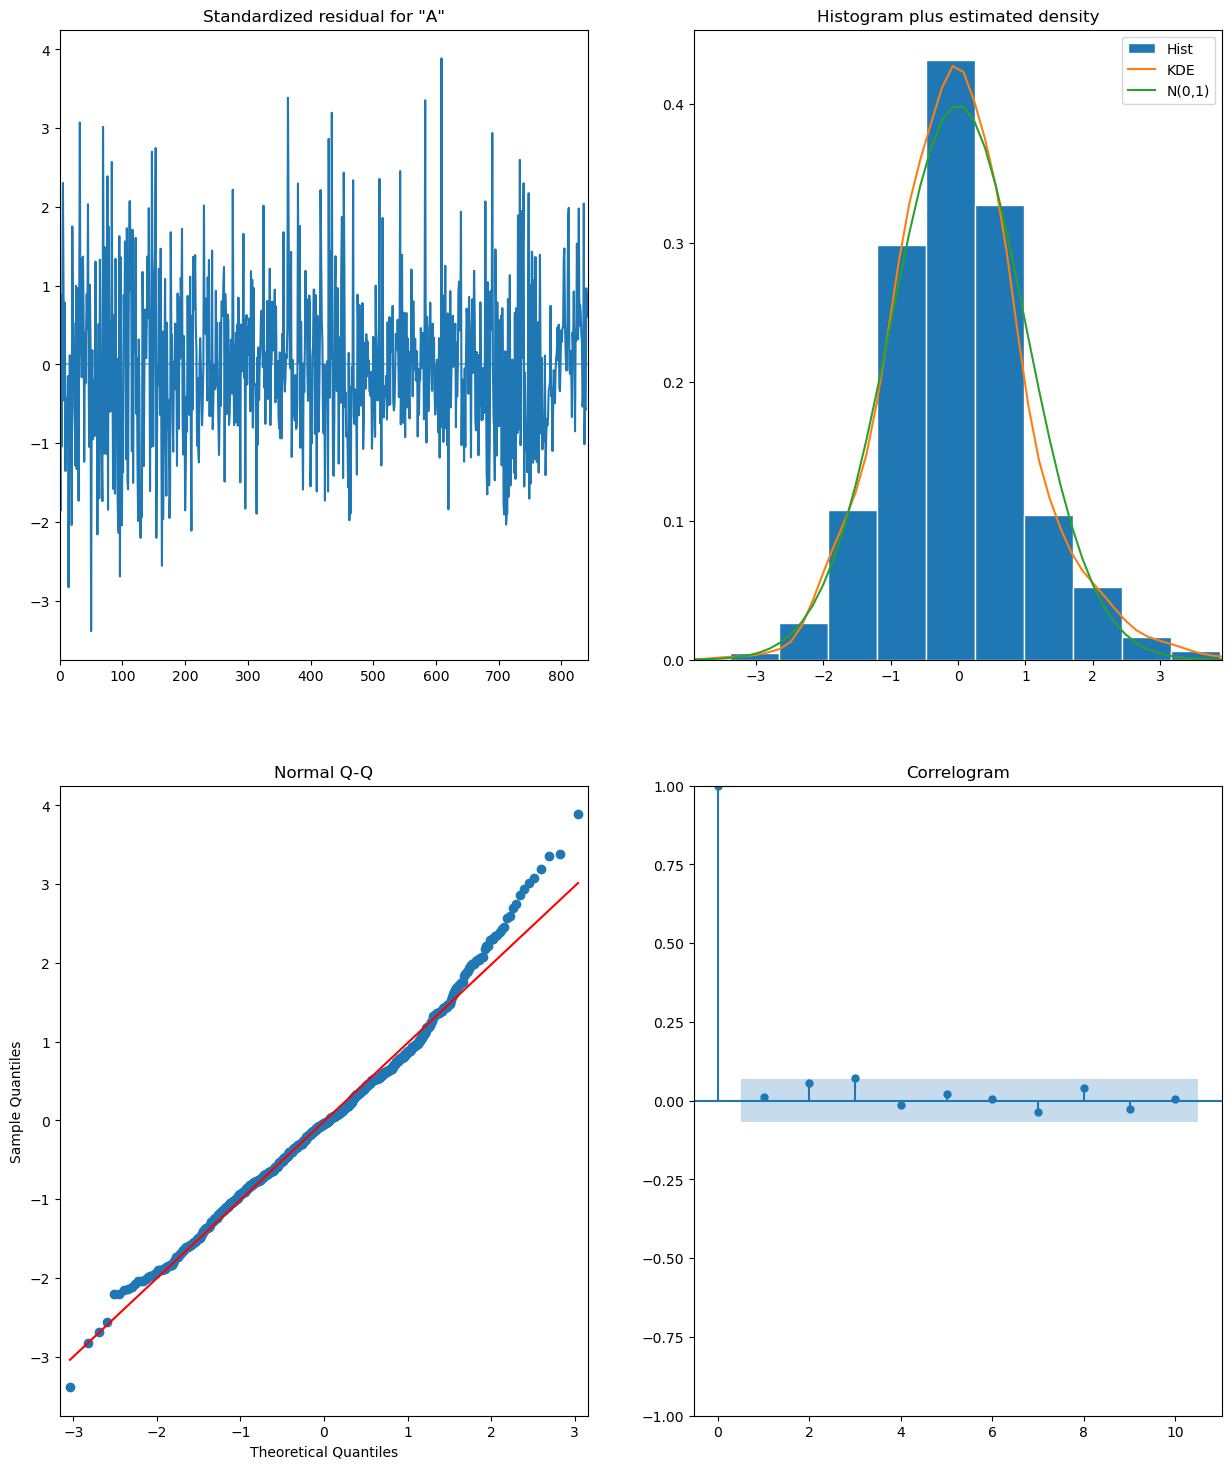

In [68]:
output.plot_diagnostics(figsize = (15, 18))
plt.show()

The top left plot maps the residuals over time, which doesn't seem to display any obvious seasonality. This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

The top right plot, N(0,1) is the standard notation for a normal distribution with a mean of 0 and standard deviation of 1, and the orange KDE line follows pretty closely with this line. This is a good indication that the residuals are normally distributed.

The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution with N(0, 1). Again, this is a strong indication that the residuals are normally distributed.

These observations lead us to conclude that our model has no correlations and provides a satisfactory fit to help forecast future values.

In [69]:
pred = output.get_prediction(start = pd.to_datetime('1997-06-23'), dynamic = False)
pred_conf = pred.conf_int()

In [70]:
NYL_Final_ts.isnull().count()

Attendance    896
dtype: int64

In [71]:
NYL_Final_ts_fill_diff['1997':]

,Attendance
Date,
1997-06-23,975.0
1997-06-26,-6328.0
1997-06-29,8849.0
1997-07-02,-8988.0
1997-07-04,1447.0
...,...
2022-08-12,-657.0
2022-08-14,4423.0
2022-08-17,-37.0


In [72]:
pred.predicted_mean

Date
1997-06-23       0.000000
1997-06-26       0.000000
1997-06-29    4414.078027
1997-07-02   -2038.250495
1997-07-04    3299.843611
                 ...     
2022-08-12    1083.559622
2022-08-14    1513.761161
2022-08-17   -2458.101876
2022-08-20   -1617.327992
2022-08-23   -2241.515481
Name: predicted_mean, Length: 895, dtype: float64

In [73]:
pred_conf.iloc[:, 0]

Date
1997-06-23   -3394.757202
1997-06-26   -6423.679166
1997-06-29   -2589.067793
1997-07-02   -9340.052023
1997-07-04   -4119.881575
                 ...     
2022-08-12   -4818.477635
2022-08-14   -4385.330443
2022-08-17   -8356.890873
2022-08-20   -7516.046914
2022-08-23   -8140.238373
Name: lower Attendance, Length: 895, dtype: float64

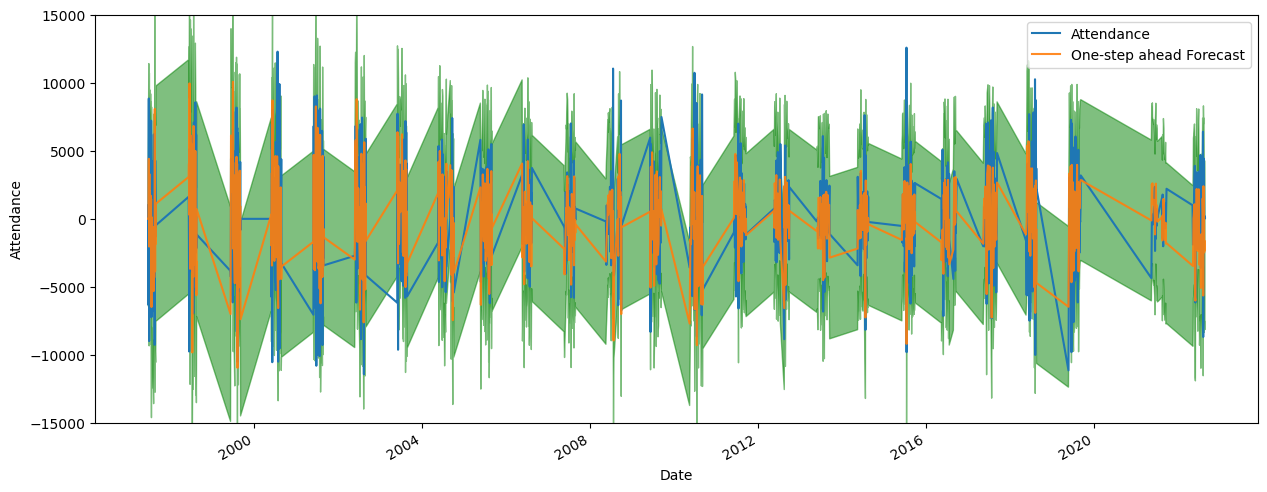

In [78]:
rcParams['figure.figsize'] = 15, 6

ax = NYL_Final_ts_fill_diff['1997':].plot(label = 'observed')

pred.predicted_mean.plot(ax = ax, label = 'One-step ahead Forecast', alpha = 0.9)

ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color = 'g', alpha = 0.5)

plt.ylim(-15000, 15000)

ax.set_xlabel('Date')
ax.set_ylabel('Attendance')
plt.legend()

plt.show()

In [79]:
Att_forecasted = pred.predicted_mean
Att_truth = NYL_Final_ts_fill_diff['1997-06-23':]

mse = ((Att_truth.iloc[:,0] - preds) **2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is nan


So running our forecast on the order = (0, 0, 2) & seasonal_order = (0, 2, 2, 12) that the SARIMAX suggested, seems to have bumped our MSE to over 200 initially, but now it's just giving me null values...not at all what we were hoping for, so maybe I need to go back and widen those metrics so that it would hopefully capture more accurate parameters.

## Conclusion

Based on my best model, we can pretty accurately predict how many attendees we can expect for any game, with a fairly minimal error. Next I just need to nail down the proper parameters so that we can forecast our game attendance!

Some other factors to keep in mind, which could really run up the attendance numbers, are the amazing players that the Liberty have brought onto the team this season. So definitely want to look into how that could affect our data, as well as do some reasearch into the drops in theintial data to see what could've possibly affected a dip in attendance (besides Covid, of course). As well, would like to play with some other ways to fill off-season data, maybe even run some models on monthly or weekly data, or potentially pull information on leagues that the teams/players take part in outside of the regular season.

Overall, we will be able to help our cross-functional partners plan out what they need for the upcoming season.